# Roman Persistence Analysis - Reorganized Workflow

This notebook performs Roman Space Telescope persistence analysis with a logical workflow:

## Workflow Overview:
1. **Setup & Configuration** - Imports, globals, helper functions
2. **Data Preparation** - Load overguide data, create star catalogs
3. **L1 Simulation** - Generate L1 ASDF files using romanisim
4. **L1 Processing** - Saturation detection, removal, up-the-ramp analysis
5. **L2 Calibration** - Process L1 through romancal pipeline
6. **L2 Analysis** - Photometry, persistence detection, visualization

---


## 1. Setup & Configuration
### Import Libraries

In [1]:
''' import standard and custom libraries '''

import argparse
import asdf
import copy
from datetime import datetime, timedelta
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from pprint import pprint

import astropy
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
import astropy.wcs as WCS

import crds
import stpsf

import glob
import galsim
import romanisim
from romanisim import gaia, bandpass, catalog, log, wcs, persistence, parameters, ris_make_utils as ris
from romanisim.wcs import get_wcs
import romancal
from romancal.pipeline import ExposurePipeline
import roman_datamodels as rdm
from roman_datamodels.dqflags import pixel as dqflags

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

import s3fs
import time
from typing import Dict, List, Tuple, Optional
from scipy import stats
from scipy.optimize import curve_fit

# set logging level (DEBUG | INFO | WARNING | ERROR)
logging.getLogger().setLevel(logging.WARNING)

### Global Variables and Constants

In [2]:
'''This cell contains global variables and constants used in the Roman Space Telescope persistence analysis simulation.
It includes parameters for the simulation, directories for input and output files, and settings for overguide data.
'''

# sample file for testing
l1_file = './L1_simulation_files/roman_sim_F146_WFI01_L1_uncal_1.asdf'

# Global variables
SCA = 1
SIM_OUTPUT_DIRECTORY = 'L1_simulation_files'
OUTPUT_DIRECTORY = 'L1_simulation_files'
FILTER = 'F146'
FIELD_CENTER = [80, 30]  # RA, Dec in degrees . define after read in overguide data
FIELD_ID = 0  
MA_TABLE = 3
SEED = 42

# Construct the file path using HOME environment variable
# HOME_DIR = Path('~')
PROJECT_DIRECTORY = 'teams/gbast/Roman_Analysis'
MAG = 10
CATALOG_FILE_NAME = f'star{MAG}.ecsv'

# Observation parameters
BASE_TIME = '2026-10-15T00:00:00' # Base time for the simulation
TIME_TO_RUN = 12.1*60 # Time to run the simulation in seconds (total run time will be 518400 seconds (72 day)) 
 
# Overguide data to generate the star catalog
OVERGUIDE_DATA_FILE_NAME = 'Hon_Overguide_Photometry_Full_1.csv'
OVERGUIDE_DATA_DIRECTORY = f'{PROJECT_DIRECTORY}/overguide_data/'
LOAD_ALL_OVERGUIDE_DATA = False  # Set to True to load all overguide data    
MINIMUM_HMAG = 10.0  # Minimum hmag for overguide sources
NROWS_IN_CATALOG = 100  # Number of rows to load in the catalog

sca_read_noise = {
    'WFI01': 17.49,  # SCU 1 (highest noise)
    'WFI02': 14.20,  # SCU 2
    'WFI03': 14.70,  # SCU 3  
    'WFI04': 15.76,  # SCU 4
    'WFI05': 13.64,  # SCU 5
    'WFI06': 13.65,  # SCU 6
    'WFI07': 13.21,  # SCU 7
    'WFI08': 12.49,  # SCU 8
    'WFI09': 12.39,  # SCU 9 (lowest noise)
    'WFI10': 15.75,  # SCU 10
    'WFI11': 13.94,  # SCU 11
    'WFI12': 13.73,  # SCU 12
    'WFI13': 16.17,  # SCU 13
    'WFI14': 13.46,  # SCU 14
    'WFI15': 13.46,  # SCU 15
    'WFI16': 13.49,  # SCU 16
    'WFI17': 12.64,  # SCU 17
    'WFI18': 12.42,  # SCU 18
}


### Helper Functions

In [3]:
def get_asdf_file(file_path):
    return asdf.open(file_path, 'rb')

def get_roman_dm_file(file_path):
    with asdf.open(file_path, 'rb') as fb:
        f = rdm.open(fb).copy()
    return f

def get_metadata(file_path):
    f = get_roman_dm_file(file_path)
    return f.meta

def get_data(file_path):
    f = get_roman_dm_file(file_path)
    return f.data

def get_data_quality_section(file_path):
    f = get_roman_dm_file(file_path)
    return f.dq

# get the list of the simulation output files in the directory
def get_list_of_asdf_files(directory):
    dir_path = Path(directory)
    if not dir_path.is_dir():
        raise NotADirectoryError(f"{directory} is not a valid directory.")
    
    asdf_files = list(dir_path.glob('*.asdf'))
    asdf_files.sort(key=lambda x: os.path.getctime(x))  # Sort by creation time
    return asdf_files

#Plot the resultant for a specific pixel in the ASDF file.
def plot_resultants_for_pixel(file, pixel_x, pixel_y):
    plt.figure(figsize=(6, 6), layout='tight')
    plt.title(f'Up-the-ramp samples for pixel {pixel_x}, {pixel_y}')
    plt.plot(file['data'][:, pixel_x, pixel_y])
    plt.xlabel('Resultant number', fontsize=16)
    plt.ylabel('Pixel value [DN]', fontsize=16)
    plt.show()

# get number of saturated pixels in the ASDF file
def get_saturated_pixel_count(file_path):
    f = get_asdf_file(file_path)
    # L1 files do not have data quality flags, so we check the level
    if f['romanisim']['level'] == 1:
        return None
    bit = 2
    definition = str(dqflags(bit)).split('.')[1]
    n_pix = np.sum(np.bool(f.dq.flatten() & (1 << bit)))
    print(f'Bit value {bit} corresponds to {definition}')
    print(f'Number of {definition} pixels: {n_pix:,} ({n_pix / f.dq.size:.2%})')
    return n_pix

def get_exposure_metadata(file_path):
    f = get_roman_dm_file(file_path)
    return f.meta.exposure

def get_exposure_start_time(file_path):
    f = get_roman_dm_file(file_path)
    start_time = Time(f.meta.exposure.start_time, format='isot', scale='utc')
    return start_time

def get_exposure_end_time(file_path):
    f = get_roman_dm_file(file_path)
    end_time = Time(f.meta.exposure.end_time, format='isot', scale='utc')
    return end_time

def get_effective_exposure_time(file_path):
    f = get_roman_dm_file(file_path)
    effective_exposure_time = f.meta.exposure.effective_exposure_time * u.s
    return effective_exposure_time

def get_exposure_time(file_path):
    f = get_roman_dm_file(file_path)
    exposure_time = f.meta.exposure.exposure_time * u.s
    return exposure_time

def get_frame_time(file_path):
    f = get_roman_dm_file(file_path)
    frame_time = f.meta.exposure.frame_time * u.s
    return frame_time

def get_number_of_resultants(file_path):
    f = get_roman_dm_file(file_path)
    return f.meta.exposure.nresultants

def get_dq_saturated_pixels(file_path):
    f = get_roman_dm_file(file_path)
    return f.pixels

def get_catalog(file_name):
    catalog = Table.read(file_name, format = "ascii.ecsv")
    return catalog

def galactic_to_equatorial(l, b):
    # Convert galactic coordinates to equatorial (RA, Dec).
    # Convert inputs to numpy arrays to handle both scalar and array inputs
    l = np.asarray(l, dtype=float)
    b = np.asarray(b, dtype=float)
    
    # Ensure we have valid values (remove any NaN or infinite values)
    valid_mask = np.isfinite(l) & np.isfinite(b)
    
    if not np.any(valid_mask):
        raise ValueError("No valid galactic coordinates found")
    
    # Create SkyCoord object with galactic coordinates
    # Explicitly specify units to avoid confusion
    coord = SkyCoord(l * u.degree, b * u.degree, frame='galactic')

    # Convert to equatorial coordinates (ICRS frame)
    equatorial = coord.icrs
    
    # Return RA and Dec in degrees
    # If input was scalar, output will be scalar; if array, output will be array
    return equatorial.ra.degree, equatorial.dec.degree


In [4]:
def run_romanisim_simulationapi(
    catalog_file,
    filter_name='F146',
    sca=1,
    level=1,
    exposure_params=None,
    pointing=(270.0, -30.0),
    date='2026-06-15T12:00:00',
    output_directory=OUTPUT_DIRECTORY,
    output_suffix="",
    previous_file=None,
    usecrds=True
):
    """
    Run a Roman I-Sim simulation to generate an ASDF file.

    This function uses romanisim to simulate a Roman WFI exposure, optionally including detector persistence
    from a previous exposure. It reads a source catalog, sets up simulation parameters, and writes the output
    to an ASDF file.

    Parameters
    ----------
    catalog_file : Path to the input catalog file (ECSV format) compatible with romanisim.
    filter_name : Name of the filter/bandpass to use (default: 'F146').
    sca : SCA (Sensor Chip Assembly) number, determines the detector (default: 1).
    level : Simulation level (default: 1).
    exposure_params : Dictionary of exposure parameters (e.g., MA table, RNG seed). If None, defaults are used.
    pointing : Tuple of (RA, Dec) for the field center in degrees (default: (270.0, -30.0)).
    date : Observation date/time in ISO format (default: '2026-06-15T12:00:00').
    output_directory : Directory to save the output ASDF file (default: SIM_OUTPUT_DIRECTORY).
    output_suffix : Suffix to append to the output filename (default: "").
    previous_file : Path to a previous exposure file for persistence simulation (default: None).

    Returns
    -------
    output_filename :  Path to the generated ASDF simulation file.

    Notes
    -----
    - If `previous_file` is provided, persistence from that file is included in the simulation.
    - The output file is named according to the filter, detector, level, and optional suffix.
    """
    
    detector = f'WFI0{sca:01d}'
    #filename = f'test_01101_0001_{detector}_L{level}.asdf'  # Output file name on disk. Only change the first part up to _WFI to change the rootname of the file.
    output_filename = (f"{output_directory}/roman_sim_{filter_name}_{detector}_L{level}{output_suffix}.asdf")
    
    ma_table_number = 3               # Multi-accumulation (MA) table number...must be an integer number from 3 - 17
    seed = 7                          # Galsim random number generator seed for reproducibility
    
    # Set other arguments for use in Roman I-Sim. The code expects a specific format for these, so this is a little complicated looking.
    parser = argparse.ArgumentParser()
    parser.set_defaults(usecrds=True, stpsf=True, level=level, filename=output_filename, drop_extra_dq=True, sca=sca, bandpass=filter_name, pretend_spectral=None)
    
    args = parser.parse_args([])
    
    # Set reference files to None for CRDS
    for k in parameters.reference_data:
        parameters.reference_data[k] = None
    
    # Set Galsim RNG object
    rng = galsim.UniformDeviate(seed)
    
    # Set persistance information
    if previous_file:
        persist = persistence.Persistence.read(previous_file)
    else:
        persist = persistence.Persistence()

    # Set metadata
    metadata = ris.set_metadata(date=date, bandpass=filter_name, sca=sca, ma_table_number=ma_table_number, usecrds=True)
    
    # Update the WCS info
    wcs.fill_in_parameters(metadata, SkyCoord(pointing[0], pointing[1], unit='deg', frame='icrs'), boresight=False, pa_aper=0.0)
    
    # create the catalog object
    catalog = astropy.table.Table.read(catalog_file)
    
    # Run the simulation
    #ris.simulate_image_file(args, metadata, catalog, rng, persist)
    
    return output_filename


---
## 2. Data Preparation
### Load Overguide Data and Create Star Catalogs


In [2]:
# Create catalog with single start at center:
#Center: RA=79.922971, Dec=30.034266
# we're using the center of the sensorfor the star location

# Create catalog files for stars with magnitudes from 10 to 15
mags =list(range(10,16))
for mag in mags:
    cat = Table()
    cat['ra'] =  [79.922971]
    cat['dec'] = [30.034266]
    cat['type'] = ['PSF']
    cat['n'] = [-1]
    cat['half_light_radius'] = [-1]
    cat['pa'] = [-1]
    cat['ba'] = [-1]
    cat['F146'] = [10**(-0.4*mag)]  # H=12 in maggies
    cat.write(f'star{mag}.ecsv', format='ascii.ecsv', overwrite=True)

    
''' generates files with catalog in this format

ra dec type n half_light_radius pa ba F146
79.922971 30.034266 PSF -1 -1 -1 -1 0.0001

'''

' generates files with catalog in this format\n\nra dec type n half_light_radius pa ba F146\n79.922971 30.034266 PSF -1 -1 -1 -1 0.0001\n\n'


---
## 3. L1 Simulation
### Generate L1 Uncalibrated Files using romanisim


In [5]:
from astropy.time import Time

# Construct the file path using HOME environment variable
home_dir = Path('~')
file_path = home_dir / 'teams/gbast/Roman_Analysis/star10.ecsv'

start_time = datetime.strptime(BASE_TIME, '%Y-%m-%dT%H:%M:%S')
end_time = start_time + timedelta(seconds=TIME_TO_RUN)
delta = timedelta(seconds=0)    # if you want any delay between end time of previous exposure, add it here

current_time = start_time
chunk = 1
previous_file = None  # Initialize previous_file to None

while current_time <= end_time:
    date_str = current_time.strftime('%Y-%m-%dT%H:%M:%S')
    output_suffix = f"_uncal_{chunk}"
    print(f"Processing chunk {chunk} at {date_str}")
    previous_file = run_romanisim_simulationapi(
        CATALOG_FILE_NAME,
        filter_name=FILTER,
        sca=SCA,
        level=1,
        exposure_params=None,
        pointing=(FIELD_CENTER),
        date=date_str,
        output_suffix=output_suffix,
        previous_file=previous_file
    )
    file_end_time = get_exposure_end_time(previous_file)
    current_time = file_end_time + delta  # Move to the end time of the current file plus delta
    chunk += 1

Processing chunk 1 at 2026-10-15T00:00:00
Processing chunk 2 at 2026-10-15T00:00:56
Processing chunk 3 at 2026-10-15T00:01:52
Processing chunk 4 at 2026-10-15T00:02:48
Processing chunk 5 at 2026-10-15T00:03:44
Processing chunk 6 at 2026-10-15T00:04:40
Processing chunk 7 at 2026-10-15T00:05:36
Processing chunk 8 at 2026-10-15T00:06:32
Processing chunk 9 at 2026-10-15T00:07:28
Processing chunk 10 at 2026-10-15T00:08:24
Processing chunk 11 at 2026-10-15T00:09:20
Processing chunk 12 at 2026-10-15T00:10:16
Processing chunk 13 at 2026-10-15T00:11:12



---
## 4. L1 Processing & Analysis
### 4.1 RomanL1ResultantAnalyzer Class Definition

This class handles all L1-level operations:
- Loading L1 files and extracting resultants
- Reference pixel correction
- Saturation detection and masking
- Up-the-ramp slope fitting (Casertano weighting)
- Persistence detection


In [5]:
class RomanL1ResultantAnalyzer:
    """
    Analyzer for individual resultants in Roman L1 files with proper MA table handling.
    """
    
    def __init__(self, l1_file_path: str):
        """
        Initialize with L1 file path.
        
        Parameters:
        -----------
        l1_file_path : str
            Path to L1 ASDF file (_uncal.asdf)
        """
        self.file_path = Path(l1_file_path)
        self.model = None
        
        # Data containers
        self.ramp_data = None  # (resultants, y, x)
        self.ref_pixels = None  # Reference pixel data if available
        self.resultants = {}   # Individual resultant arrays
        self.exposure_metadata = {}
        
        # MA table and timing information
        self.ma_table_info = {}
        self.read_pattern = []  # List of read groups per resultant
        self.resultant_times = None
        self.frame_times = None
        
        # Processed data
        self.slopes = None
        self.corrected_ramp = None
    
    ### Methods for casertano fitting ###
    def casertano_weighted_fit(self, times, counts, read_noise=10.0):
        """
        Implement Casertano (2022) optimal weighting scheme.
        """
        N = len(times)
        if N < 2:
            return 0.0, np.inf
        # FIX: Convert counts to float64 BEFORE subtraction to prevent overflow
        counts = np.asarray(counts, dtype=np.float64)
        times = np.asarray(times, dtype=np.float64)

        
        # FIX: Convert to float64 to prevent integer overflow
        counts = np.asarray(counts, dtype=np.float64)
        times = np.asarray(times, dtype=np.float64)
        
        # Calculate signal-to-noise ratio
        S_max = counts[-1] - counts[0]  # Maximum signal (safe with float64)
        if S_max <= 0:
            S_max = np.abs(counts[-1] - counts[0]) + 1.0
        
        S = S_max / np.sqrt(read_noise**2 + S_max)
        
        # Calculate optimal weights based on S/N
        weights = self.calculate_casertano_weights(times, S, read_noise)
        
        # Apply weighted least squares
        W = weights
        t_bar = times - times[0]  # Relative times
        
        # Auxiliary sums (Casertano method)
        F0 = np.sum(W)
        F1 = np.sum(W * t_bar)
        F2 = np.sum(W * t_bar**2)
        
        D = F0 * F2 - F1**2
        if abs(D) < 1e-15:
            return 0.0, np.inf
        
        # Coefficients and slope calculation
        K = (F0 * t_bar - F1) / D
        slope = np.sum(K * counts)
        
        # Calculate uncertainty
        tau = times - times[0]
        V_S = np.sum(K**2 * tau) + np.sum([2 * K[i] * K[j] * t_bar[i] 
                                        for i in range(N) for j in range(i+1, N)])
        V_R = np.sum(K**2) * read_noise**2
        V_total = V_S * abs(slope) + V_R
        slope_error = np.sqrt(max(V_total, 0))
        
        return slope, slope_error

    def calculate_casertano_weights(self, times, S, read_noise):
        """Calculate optimal weights based on S/N ratio."""
        N = len(times)
        
        # Low S/N: equal weighting (read noise dominated)
        if S < 0.1:
            return np.ones(N)
        
        # High S/N: first and last samples only (Poisson dominated)  
        elif S > 10.0:
            weights = np.zeros(N)
            weights[0] = 1.0   # First
            weights[-1] = 1.0  # Last
            return weights
        
        # Intermediate S/N: smooth transition
        else:
            equal_weights = np.ones(N)
            endpoint_weights = np.zeros(N)
            endpoint_weights[0] = 1.0
            endpoint_weights[-1] = 1.0
            
            # Sigmoid transition parameter
            alpha = 1.0 / (1.0 + np.exp(-2 * (S - 2)))
            weights = (1 - alpha) * equal_weights + alpha * endpoint_weights
            
            return weights
    #####################################                      

    def load_l1_file(self):
        """Load the L1 file and extract comprehensive metadata."""
        print(f"Loading L1 file: {self.file_path}")
        
        self.model = rdm.open(str(self.file_path))
        self.ramp_data = self.model.data
        
        # Extract detailed exposure metadata
        meta = self.model.meta
        exposure = meta.exposure
        
        self.exposure_metadata = {
            'type': exposure.type,
            'start_time': exposure.start_time,
            'mid_time': exposure.mid_time,
            'end_time': exposure.end_time,
            'nresultants': exposure.nresultants,
            'frame_time': exposure.frame_time,
            'exposure_time': exposure.exposure_time,
            'effective_exposure_time': exposure.effective_exposure_time,
            'ma_table_name': exposure.ma_table_name,
            'ma_table_number': exposure.ma_table_number,
            'truncated': exposure.truncated,
            'data_problem': exposure.data_problem,
            'detector': meta.instrument.detector,
            'optical_element': meta.instrument.optical_element,
            'read_noise': sca_read_noise[meta.instrument.detector]
        }
        
        # Extract the actual read pattern (MA table structure)
        self.read_pattern = exposure.read_pattern
        print(f"Found MA table read pattern with {len(self.read_pattern)} resultants")
  
        # Process the MA table information
        self._process_ma_table()
        
        print(f"Loaded ramp data: {self.ramp_data.shape}")
        print(f"MA table {self.exposure_metadata.get('ma_table_number', '?')}: "
                   f"{len(self.read_pattern)} resultants")
        
    def _process_ma_table(self):
        """Process the MA table read pattern to understand timing."""
        
        frame_time = self.exposure_metadata['frame_time']
        
        # Calculate timing for each resultant based on the read pattern
        self.resultant_times = []
        self.frame_times = []
        
        for i, read_group in enumerate(self.read_pattern):
            # Each read_group is a list of frame numbers
            # For resultant timing, we use the time of the last frame in the group
            if len(read_group) > 0:
                last_frame_number = max(read_group)
                resultant_time = last_frame_number * frame_time
                
                self.resultant_times.append(resultant_time)
                self.frame_times.append(read_group)
                
                print(f"Resultant {i}: frames {read_group}, time = {resultant_time:.2f}s")
        
        self.resultant_times = np.array(self.resultant_times)
        
        # Store MA table analysis
        self.ma_table_info = {
            'total_frames': max([max(group) for group in self.read_pattern if group]),
            'total_time': self.resultant_times[-1] if len(self.resultant_times) > 0 else 0,
            'resultant_count': len(self.read_pattern),
            'frame_time': frame_time
        }
        
        print(f"MA table analysis:")
        print(f"  Total frames: {self.ma_table_info['total_frames']}")
        print(f"  Total time: {self.ma_table_info['total_time']:.2f} s")
        print(f"  Frame time: {frame_time} s")
        
    def extract_all_resultants(self):
        """Extract individual resultant arrays with proper MA table context."""
        print("Extracting individual resultants with MA table context...")

        for i in range(self.exposure_metadata["nresultants"]):
            resultant_name = f"resultant_{i:02d}"
            self.resultants[resultant_name] = self.ramp_data[i, :, :].copy()
            
            # Get information about this resultant from MA table
            if i < len(self.read_pattern):
                read_group = self.read_pattern[i]
                n_frames_averaged = len(read_group) 
                resultant_time = self.resultant_times[i] if i < len(self.resultant_times) else 0
            else:
                n_frames_averaged = 1
                resultant_time = 0
            
            # Basic statistics
            valid_mask = np.isfinite(self.resultants[resultant_name])
            if np.any(valid_mask):
                mean_val = np.mean(self.resultants[resultant_name][valid_mask])
                median_val = np.median(self.resultants[resultant_name][valid_mask])
                print(f"  {resultant_name}: time={resultant_time:.2f}s, "
                           f"frames_avg={n_frames_averaged}, "
                           f"mean={mean_val:.1f} DN, median={median_val:.1f} DN")
        
        print(f"Extracted {len(self.resultants)} resultants")
        return self.resultants
   
    def extract_reference_pixels(self, resultant):
        """Extract reference pixels according to official Roman WFI layout."""
        # Official layout: 4096x4096 total, with 4-pixel border
        # Active region: 4088x4088 (pixels 4:4092 in both dimensions)
        
        ref_pixels = {
            'top_rows': resultant[:4, :],        # Rows 0-3 (full width)
            'bottom_rows': resultant[-4:, :],    # Rows 4092-4095 (full width) 
            'left_cols': resultant[4:-4, :4],    # Cols 0-3 (active region only)
            'right_cols': resultant[4:-4, -4:], # Cols 4092-4095 (active region only)
        }
        # Convert to single 1D array
        all_ref_pixels = np.concatenate([
            ref_pixels['top_rows'].flatten(),
            ref_pixels['bottom_rows'].flatten(),
            ref_pixels['left_cols'].flatten(),
            ref_pixels['right_cols'].flatten()
    ])
        return all_ref_pixels
    
    # while the pixel values are 0 for the romanisim files, we should have this in the analysis for real data  
    def reference_pixel_correction(self, method='median_subtract'):
        """
        Apply reference pixel correction accounting for MA table structure.
        
        Parameters:
        -----------
        method : str
            Method for reference pixel correction ('median_subtract', 'mean_subtract', 'none')
        """
        print(f"Applying reference pixel correction: {method}")
        
        if method == 'none':
            self.corrected_ramp = self.ramp_data.copy()
            return
        
        self.corrected_ramp = self.ramp_data.copy()
        
        # Roman WFI reference pixels - more sophisticated correction
        for i in range(self.corrected_ramp.shape[0]):
            resultant = self.corrected_ramp[i, :, :]
            
            # For Roman WFI, reference pixels are typically:
            # - Top and bottom 4 rows (overscan)
            # - Left and right 4 columns (overscan) 
            # - Every 4th column has additional reference pixels
            
            # Extract reference pixels from edges
            ref_pixels = self.extract_reference_pixels(resultant)
            
            # Convert to numpy array and filter valid pixels
            ref_pixels = np.array(ref_pixels)
            valid_ref = ref_pixels[np.isfinite(ref_pixels)]
            
            if len(valid_ref) > 10:  # Need sufficient reference pixels
                if method == 'median_subtract':
                    ref_level = np.median(valid_ref)
                elif method == 'mean_subtract':
                    ref_level = np.mean(valid_ref)
                
                # Subtract reference level from science region only
                # (avoid double-correcting reference pixels)
                science_region = resultant[4:-4, 4:-4] if resultant.shape[0] > 8 and resultant.shape[1] > 8 else resultant
                science_region = science_region - ref_level
                
                # Get frames averaged for this resultant for noise scaling
                if i < len(self.read_pattern):
                    n_frames = len(self.read_pattern[i]) if isinstance(self.read_pattern[i], list) else 1
                    ref_noise = np.std(valid_ref) / np.sqrt(n_frames)  # Reduced by averaging
                else:
                    ref_noise = np.std(valid_ref)
                
                print(f"  Resultant {i}: ref_level = {ref_level:.2f} DN, "
                           f"ref_noise = {ref_noise:.3f} DN")
        
        print("Reference pixel correction completed")

    def fit_up_the_ramp_slopes(self, method='casertano', read_noise=10.0):
        """Fit slopes using Casertano optimal weighting."""
        
        data_to_fit = self.corrected_ramp if self.corrected_ramp is not None else self.ramp_data
        ny, nx = data_to_fit.shape[1:]
        self.slopes = np.zeros((ny, nx))
        slope_errors = np.zeros((ny, nx))
        
        # No global weights needed for Casertano - calculated per pixel
        
        for y in range(ny):
            for x in range(nx):
                pixel_ramp = data_to_fit[:, y, x]
                valid_mask = np.isfinite(pixel_ramp)
                
                if np.sum(valid_mask) >= 3:
                    times = self.resultant_times[valid_mask]
                    counts = pixel_ramp[valid_mask]
                    
                    # Use Casertano weighting (pixel-specific)
                    try:
                        slope, std_err = self.casertano_weighted_fit(times, counts, read_noise)
                    except Exception as e:
                        print(f'{x},{y}')
                        
                    self.slopes[y, x] = slope
                    slope_errors[y, x] = std_err
        
        return self.slopes, slope_errors 
               
    def detect_persistence_ma_aware(self, threshold_sigma=5.0):
        """
        Detect persistence using MA table timing for proper analysis.
        
        Parameters:
        -----------
        threshold_sigma : float
            Threshold in sigma for persistence detection
        """
        print(f"Detecting persistence with MA table awareness (threshold: {threshold_sigma}σ)")
        
        if self.slopes is None:
            print("Slopes not calculated. Running slope fitting first.")
            self.fit_up_the_ramp_slopes()
        
        data_to_analyze = self.corrected_ramp if self.corrected_ramp is not None else self.ramp_data
        ny, nx = data_to_analyze.shape[1:]
        persistence_map = np.zeros((ny, nx), dtype=bool)
        persistence_strength = np.zeros((ny, nx))
        
        for y in range(ny):
            for x in range(nx):
                pixel_ramp = data_to_analyze[:, y, x]
                valid_mask = np.isfinite(pixel_ramp)
                
                if np.sum(valid_mask) >= 4:
                    times = self.resultant_times[valid_mask]
                    counts = pixel_ramp[valid_mask]
                    
                    try:
                        # Fit linear model
                        slope, intercept = np.polyfit(times, counts, 1)
                        linear_model = slope * times + intercept
                        residuals = counts - linear_model
                        
                        # Weight residuals by MA table frame averaging
                        weighted_residuals = residuals.copy()
                        if self.read_pattern:
                            for i, valid_idx in enumerate(np.where(valid_mask)[0]):
                                if valid_idx < len(self.read_pattern):
                                    read_group = self.read_pattern[valid_idx]
                                    # Scale residual by sqrt(n_frames) for noise
                                    weighted_residuals[i] /= np.sqrt(len(read_group))
                        
                        residual_std = np.std(weighted_residuals)
                        max_residual = np.max(np.abs(weighted_residuals))
                        
                        # Check for early-time excess (persistence signature)
                        if len(weighted_residuals) >= 3:
                            early_residuals = weighted_residuals[:3]
                            early_excess = np.mean(early_residuals)
                            
                            # Persistence criteria
                            if (max_residual > threshold_sigma * residual_std or 
                                early_excess > threshold_sigma * residual_std):
                                persistence_map[y, x] = True
                                persistence_strength[y, x] = max_residual / residual_std
                                
                    except Exception:
                        continue
        
        persistence_pixels = np.sum(persistence_map)
        persistence_fraction = persistence_pixels / (ny * nx)
        
        print(f"Detected {persistence_pixels} persistence pixels ({persistence_fraction:.3%})")
        
        return persistence_map, persistence_strength
        
    def analyze_ma_table_effects(self):
        """Analyze how the MA table affects data quality."""
        print("Analyzing MA table effects on data quality...")
        
        if not self.read_pattern:
            print("No MA table information available")
            return {}
        
        analysis = {
            'ma_table_number': self.exposure_metadata['ma_table_number'],
            'resultant_info': [],
            'timing_analysis': {},
            'noise_analysis': {},
        }
        
        # Analyze each resultant
        for i, read_group in enumerate(self.read_pattern):
            n_frames = len(read_group)
            time = self.resultant_times[i] if i < len(self.resultant_times) else 0
            
            # Expected read noise improvement from averaging
            read_noise_improvement = np.sqrt(n_frames)
            
            resultant_info = {
                'resultant': i,
                'frames': read_group,
                'n_frames': n_frames,
                'time': time,
                'read_noise_improvement': read_noise_improvement,
            }
            
            analysis['resultant_info'].append(resultant_info)
            
            print(f"  Resultant {i}: {n_frames} frames @ {time:.1f}s "
                        f"(noise improvement: {read_noise_improvement:.2f}×)")
    
        # Timing analysis
        time_intervals = np.diff(self.resultant_times)
        analysis['timing_analysis'] = {
            'mean_interval': np.mean(time_intervals),
            'min_interval': np.min(time_intervals),
            'max_interval': np.max(time_intervals),
            'interval_std': np.std(time_intervals),
        }
        
        print(f"Timing intervals: mean={np.mean(time_intervals):.1f}s, "
                   f"range=[{np.min(time_intervals):.1f}, {np.max(time_intervals):.1f}]s")
        
        return analysis
        
    def plot_ma_table_structure(self):
        """Visualize the MA table structure and timing."""
        if not self.read_pattern:
            print("No MA table data to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Frame grouping structure
        ax = axes[0, 0]
        resultant_numbers = []
        frame_numbers = []
        colors = []
        
        for i, read_group in enumerate(self.read_pattern):
            if isinstance(read_group, list):
                for frame in read_group:
                    resultant_numbers.append(i)
                    frame_numbers.append(frame)
                    colors.append(len(read_group))  # Color by number of frames averaged
        
        scatter = ax.scatter(frame_numbers, resultant_numbers, c=colors, cmap='viridis', s=50, alpha=0.7)
        ax.set_xlabel('Frame Number')
        ax.set_ylabel('Resultant Number')
        ax.set_title('MA Table Frame Grouping')
        plt.colorbar(scatter, ax=ax, label='Frames per Resultant')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Resultant timing
        ax = axes[0, 1]
        resultant_indices = range(len(self.resultant_times))
        ax.plot(resultant_indices, self.resultant_times, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Resultant Number')
        ax.set_ylabel('Time (seconds)')
        ax.set_title('Resultant Timing')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frames per resultant
        ax = axes[1, 0]
        frames_per_resultant = [len(group) if isinstance(group, list) else 1 for group in self.read_pattern]
        bars = ax.bar(range(len(frames_per_resultant)), frames_per_resultant, alpha=0.7)
        ax.set_xlabel('Resultant Number')
        ax.set_ylabel('Number of Frames Averaged')
        ax.set_title('Frame Averaging per Resultant')
        ax.grid(True, alpha=0.3)
        
        # Add text labels on bars
        for i, (bar, count) in enumerate(zip(bars, frames_per_resultant)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   str(count), ha='center', va='bottom')
        
        # Plot 4: Expected read noise improvement
        ax = axes[1, 1]
        noise_improvement = [np.sqrt(len(group)) if isinstance(group, list) else 1 for group in self.read_pattern]
        ax.plot(range(len(noise_improvement)), noise_improvement, 's-', linewidth=2, markersize=8, color='red')
        ax.set_xlabel('Resultant Number')
        ax.set_ylabel('Read Noise Improvement Factor')
        ax.set_title('Expected Read Noise Reduction')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle(f'MA Table {self.exposure_metadata.get("ma_table_number", "?")} Structure Analysis', 
                     y=1.02, fontsize=14, fontweight='bold')
        plt.show()
        
    def create_comprehensive_report(self):
        """Create a comprehensive analysis report."""
        report = []
        report.append("=" * 70)
        report.append("ROMAN L1 COMPREHENSIVE RESULTANT ANALYSIS")
        report.append("=" * 70)
        
        # File and basic info
        report.append(f"File: {self.file_path.name}")
        report.append(f"Type: {self.exposure_metadata.get('type', 'Unknown')}")
        report.append(f"Detector: {self.exposure_metadata.get('detector', 'Unknown')}")
        report.append(f"Filter: {self.exposure_metadata.get('optical_element', 'Unknown')}")
        report.append("")
        
        # MA table information
        report.append("MA TABLE INFORMATION:")
        report.append(f"  MA Table Number: {self.exposure_metadata.get('ma_table_number', 'Unknown')}")
        report.append(f"  MA Table Name: {self.exposure_metadata.get('ma_table_name', 'Unknown')}")
        report.append(f"  Number of Resultants: {self.exposure_metadata.get('nresultants', 0)}")
        report.append(f"  Frame Time: {self.exposure_metadata.get('frame_time', 0)} s")
        report.append(f"  Total Exposure Time: {self.exposure_metadata.get('exposure_time', 0)} s")
        report.append(f"  Effective Exposure Time: {self.exposure_metadata.get('effective_exposure_time', 0)} s")
        report.append(f"  Truncated: {self.exposure_metadata.get('truncated', False)}")
        report.append("")
        
        # Read pattern details
        if self.read_pattern:
            report.append("READ PATTERN (frames per resultant):")
            for i, read_group in enumerate(self.read_pattern):
                if isinstance(read_group, list):
                    time = self.resultant_times[i] if i < len(self.resultant_times) else 0
                    report.append(f"  Resultant {i}: frames {read_group} @ {time:.1f}s ({len(read_group)} frames avg)")
            report.append("")
        
        # Data analysis results
        if self.slopes is not None:
            valid_slopes = self.slopes[np.isfinite(self.slopes)]
            report.append("SLOPE FITTING RESULTS:")
            report.append(f"  Mean slope: {np.mean(valid_slopes):.3f} DN/s")
            report.append(f"  Median slope: {np.median(valid_slopes):.3f} DN/s")
            report.append(f"  Slope std: {np.std(valid_slopes):.3f} DN/s")
            report.append(f"  Slope range: [{np.min(valid_slopes):.3f}, {np.max(valid_slopes):.3f}] DN/s")
            report.append("")
        
        report.append("=" * 70)
        
        return "\n".join(report)



### 4.2 Saturation Detection and Removal

Identify saturated pixels and create unsaturated versions of L1 files.


In [8]:
importlib.reload(parameters)

def get_saturated_pixels_and_neighbors(data, threshold):
    """
    Returns a list of coordinates of saturated pixels and their neighbors.
    
    Parameters:
    - data: 2D array-like structure containing pixel values.
    - threshold: Value above which a pixel is considered saturated.
    
    Returns:
    - List of tuples representing the coordinates of saturated pixels and their neighbors.
    """
    pixel_count = 0
    saturated_neighbors = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] >= threshold:
                pixel_count += 1
                saturated_neighbors.append((i, j))
                # Check neighbors
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if (di != 0 or dj != 0) and 0 <= i + di < data.shape[0] and 0 <= j + dj < data.shape[1]:
                            saturated_neighbors.append((i + di, j + dj))
    
    print(f'total saturated pixels (no neighbors) {pixel_count}')
    return list(set(saturated_neighbors))  # Remove duplicates       
               
def replace_saturated_pixels(data, indices, replacement_value=np.nan):
    """
    Replaces saturated pixels in the data with a specified replacement value.
    
    Parameters:
    - data: 2D array-like structure containing pixel values.
    - indices: List of pixel coordinates to replace.
    - replacement_value: Value to replace saturated pixels with (default is nan).
    
    Returns:
    - Modified data with saturated pixels replaced.
    """
    modified_data = data.copy()
    for index in indices:
        modified_data[index] = replacement_value
    return modified_data
 
 
def update_unsaturated_resultant(file_name, resultants_data):
    """
    Updates all resultants in the file at once.
    
    Parameters:
    - file_name: Path to the ASDF file
    - resultants_data: List of 2D arrays, one for each resultant
    """
    with rdm.open(file_name) as model:
        new_model = model.copy()
        for i, data in enumerate(resultants_data):
            new_model.data[i, :, :] = data
        new_model.save(file_name.replace(f'.asdf', '_unsat.asdf'))
        
# Get saturation level from parameters
saturated_level = parameters.reference_data['saturation'].value 
replacement_value = np.nan  # Now you can use NaN!

# Cycle through all 9 resultants of the L1 file and remove saturated pixels and neighbors
list_of_files = get_list_of_asdf_files("./L1_simulation_files") 

for l1 in list_of_files:
    l1_file = str(l1)
    print(f'Processing file: {l1_file}')
    activator = RomanL1ResultantAnalyzer(l1_file)
    activator.load_l1_file()
    
    resultants = activator.extract_all_resultants()
    
    # Initialize set to accumulate all saturated pixels across resultants
    accumulated_saturated_pixels = set()
    
    # Store modified data for all resultants
    modified_resultants = []
    
    i = 0
    for resultant in resultants:
        # Start with a copy of the current resultant - CONVERT TO FLOAT
        data = resultants[resultant].astype(np.float64)
        
        # First, apply accumulated saturated pixels from previous resultants
        # This maintains the replacement value for previously saturated pixels

        ##only need data -> apply mask to data and only save 10x10 pixels used.Extract just one region of whole thing
        if accumulated_saturated_pixels:
            data = replace_saturated_pixels(
                data, list(accumulated_saturated_pixels), replacement_value
            )
        
        # Now find NEW saturated pixels in the current (modified) resultant
        new_saturated_pixels = get_saturated_pixels_and_neighbors(
            data, saturated_level
        )
        
        # Add new saturated pixels to accumulated set
        accumulated_saturated_pixels.update(new_saturated_pixels)
        
        # Apply the new saturated pixels to current resultant
        data = replace_saturated_pixels(
            data, new_saturated_pixels, replacement_value
        )
        
        print(f'Resultant {i}: New saturated pixels: {len(new_saturated_pixels)}, '
              f'Total accumulated: {len(accumulated_saturated_pixels)}')
        
        modified_resultants.append(data)
        i += 1
    
    # Save all modified resultants at once
    update_unsaturated_resultant(l1_file, modified_resultants)
    
    print(f'File complete. Total saturated pixels across all resultants: '
          f'{len(accumulated_saturated_pixels)}')

Processing file: L1_simulation_files/roman_sim_F146_WFI01_L1_32.asdf
Loading L1 file: L1_simulation_files/roman_sim_F146_WFI01_L1_32.asdf
Found MA table read pattern with 5 resultants
Resultant 0: frames [1], time = 3.16s
Resultant 1: frames [2, 3], time = 9.49s
Resultant 2: frames [4, 5, 6, 7, 8, 9], time = 28.46s
Resultant 3: frames [10, 11, 12, 13, 14, 15, 16, 17], time = 53.76s
Resultant 4: frames [18], time = 56.92s
MA table analysis:
  Total frames: 18
  Total time: 56.92 s
  Frame time: 3.16247 s
Loaded ramp data: (5, 4096, 4096)
MA table 3: 5 resultants
Extracting individual resultants with MA table context...
  resultant_00: time=3.16s, frames_avg=1, mean=45.5 DN, median=13.0 DN
  resultant_01: time=9.49s, frames_avg=2, mean=52.4 DN, median=22.0 DN
  resultant_02: time=28.46s, frames_avg=6, mean=74.6 DN, median=45.0 DN
  resultant_03: time=53.76s, frames_avg=8, mean=116.9 DN, median=87.0 DN
  resultant_04: time=56.92s, frames_avg=1, mean=144.3 DN, median=114.0 DN
Extracted 5 r

/opt/conda/envs/roman-cal/lib/python3.12/site-packages/asdf/tags/core/ndarray.py:402: RuntimeWarning: invalid value encountered in cast
  self._make_array().__setitem__(*args)


File complete. Total saturated pixels across all resultants: 23858


In [9]:
# reset variables to current ...
mag = MAG
pic = 1
sat = '_unsat'  # make '' if want to use images with saturation
CATALOG_FILE_NAME = f'star{mag}.ecsv'
#file_name = f'./L2_simulation_files/roman_sim_F146_WFI01_L2_cal_{pic}{sat}.asdf'
file_name = f'./L1_simulation_files/roman_sim_F146_WFI01_L1_32.asdf'
cat = get_catalog(CATALOG_FILE_NAME)


### 4.3 Up-the-Ramp Analysis on Unsaturated L1 Files

Perform slope fitting on L1 resultants data before pipeline processing.


Loading L1 file: L1_simulation_files/roman_sim_F146_WFI01_L1_32_unsat.asdf
Found MA table read pattern with 5 resultants
Resultant 0: frames [1], time = 3.16s
Resultant 1: frames [2, 3], time = 9.49s
Resultant 2: frames [4, 5, 6, 7, 8, 9], time = 28.46s
Resultant 3: frames [10, 11, 12, 13, 14, 15, 16, 17], time = 53.76s
Resultant 4: frames [18], time = 56.92s
MA table analysis:
  Total frames: 18
  Total time: 56.92 s
  Frame time: 3.16247 s
Loaded ramp data: (5, 4096, 4096)
MA table 3: 5 resultants
Extracting individual resultants with MA table context...
  resultant_00: time=3.16s, frames_avg=1, mean=18.0 DN, median=12.0 DN
  resultant_01: time=9.49s, frames_avg=2, mean=24.9 DN, median=21.0 DN
  resultant_02: time=28.46s, frames_avg=6, mean=46.9 DN, median=45.0 DN
  resultant_03: time=53.76s, frames_avg=8, mean=88.9 DN, median=87.0 DN
  resultant_04: time=56.92s, frames_avg=1, mean=116.2 DN, median=114.0 DN
Extracted 5 resultants
Image dimensions: 4096 x 4096

Analyzing center pixel:

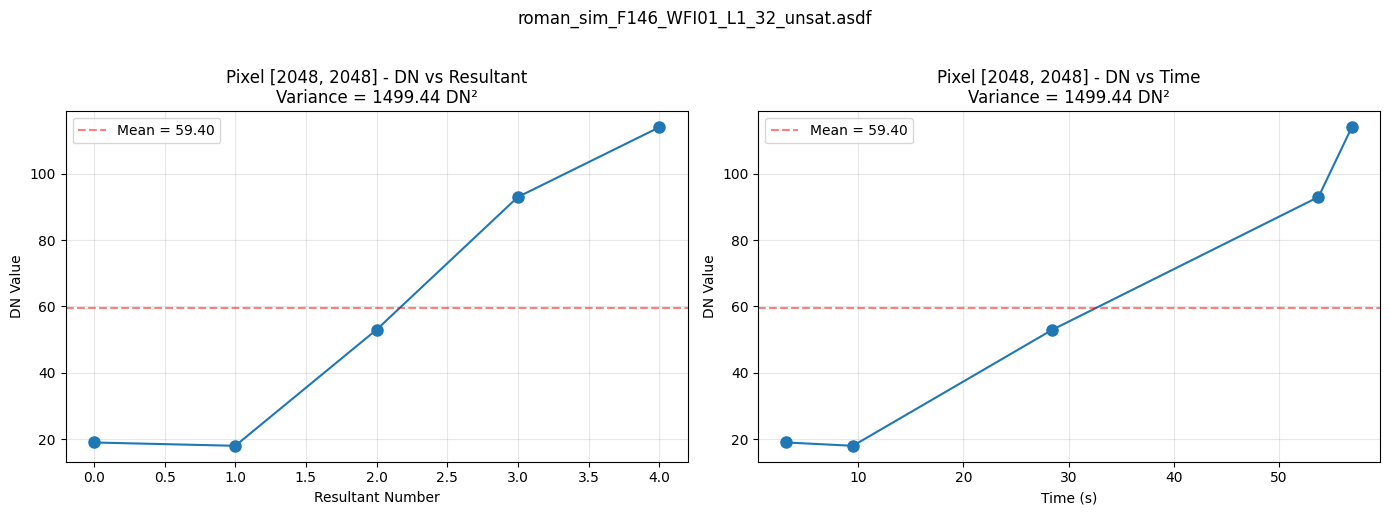

Center pixel variance: 1499.44 DN²

Analyzing multiple pixels: [(2048, 2048), (1998, 2048), (2098, 2048), (2048, 1998), (2048, 2098)]


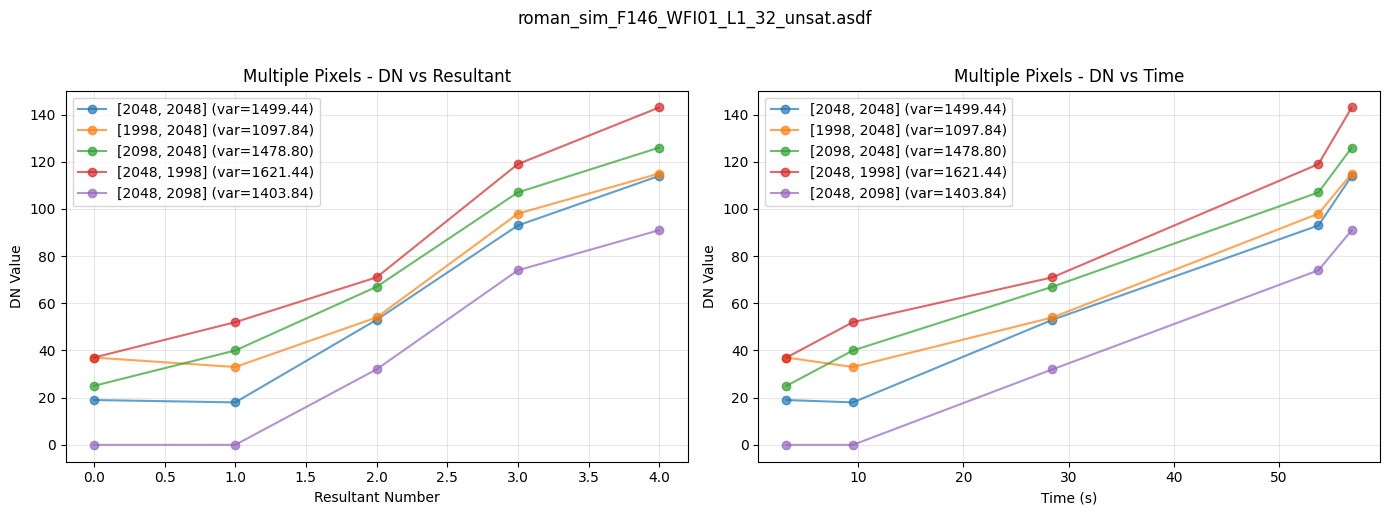


Pixel Variances:
  Pixel (2048, 2048): 1499.44 DN²
  Pixel (1998, 2048): 1097.84 DN²
  Pixel (2098, 2048): 1478.80 DN²
  Pixel (2048, 1998): 1621.44 DN²
  Pixel (2048, 2098): 1403.84 DN²


In [10]:
def calculate_single_pixel_variance(analyzer, pixel_y, pixel_x):
    """
    Calculate variance of a single pixel across all resultants.
    
    Parameters:
    -----------
    analyzer : RomanL1ResultantAnalyzer
        The analyzer object containing the ramp data
    pixel_y : int
        Y coordinate of pixel
    pixel_x : int
        X coordinate of pixel
    
    Returns:
    --------
    variance : float
        Variance of the pixel values across all resultants
    pixel_data : dict
        Dictionary containing pixel values for each resultant
    """
    
    pixel_data = {}
    values = []
    
    # Extract value for each resultant
    for i in range(analyzer.ramp_data.shape[0]):
        value = analyzer.ramp_data[i, pixel_y, pixel_x]
        pixel_data[f'resultant_{i}'] = value
        if np.isfinite(value):  # Exclude NaN/inf values
            values.append(value)
    
    # Calculate variance
    variance = np.var(values) if len(values) > 0 else np.nan
    
    return variance, pixel_data


def plot_single_pixel_with_variance(analyzer, pixel_y, pixel_x, filename=None):
    """Plot DN value vs resultant for a single pixel and show variance"""
    
    variance, pixel_data = calculate_single_pixel_variance(analyzer, pixel_y, pixel_x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    resultants = range(len(pixel_data))
    values_list = [pixel_data[f'resultant_{i}'] for i in resultants]
    
    # Plot 1: DN vs Resultant number
    ax1.plot(resultants, values_list, 'o-', markersize=8)
    ax1.set_xlabel('Resultant Number')
    ax1.set_ylabel('DN Value')
    ax1.set_title(f'Pixel [{pixel_y}, {pixel_x}] - DN vs Resultant\nVariance = {variance:.2f} DN²')
    ax1.grid(True, alpha=0.3)
    
    # Add mean line
    mean_val = np.nanmean(values_list)
    ax1.axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean = {mean_val:.2f}')
    ax1.legend()
    
    # Plot 2: DN vs Time
    if analyzer.resultant_times is not None:
        ax2.plot(analyzer.resultant_times, values_list, 'o-', markersize=8)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('DN Value')
        ax2.set_title(f'Pixel [{pixel_y}, {pixel_x}] - DN vs Time\nVariance = {variance:.2f} DN²')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean = {mean_val:.2f}')
        ax2.legend()
    
    # Add filename to suptitle if provided
    if filename:
        fig.suptitle(filename, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return variance, pixel_data


def plot_multiple_pixels_variance(analyzer, pixel_coords, filename=None):
    """
    Plot DN values for multiple pixels and compare their variances.
    
    Parameters:
    -----------
    analyzer : RomanL1ResultantAnalyzer
    pixel_coords : list of tuples
        List of (y, x) coordinates to plot
    filename : str, optional
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    variances = {}
    
    for pixel_y, pixel_x in pixel_coords:
        variance, pixel_data = calculate_single_pixel_variance(analyzer, pixel_y, pixel_x)
        resultants = range(len(pixel_data))
        values_list = [pixel_data[f'resultant_{i}'] for i in resultants]
        
        label = f'[{pixel_y}, {pixel_x}] (var={variance:.2f})'
        variances[(pixel_y, pixel_x)] = variance
        
        # Plot 1: DN vs Resultant
        ax1.plot(resultants, values_list, 'o-', label=label, markersize=6, alpha=0.7)
        
        # Plot 2: DN vs Time
        if analyzer.resultant_times is not None:
            ax2.plot(analyzer.resultant_times, values_list, 'o-', label=label, markersize=6, alpha=0.7)
    
    ax1.set_xlabel('Resultant Number')
    ax1.set_ylabel('DN Value')
    ax1.set_title('Multiple Pixels - DN vs Resultant')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if analyzer.resultant_times is not None:
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('DN Value')
        ax2.set_title('Multiple Pixels - DN vs Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    if filename:
        fig.suptitle(filename, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPixel Variances:")
    for coords, var in variances.items():
        print(f"  Pixel {coords}: {var:.2f} DN²")
    
    return variances


# ===== EXAMPLE USAGE =====

# Process a single file
directory_path = './L1_simulation_files'
file_list = glob.glob(os.path.join(directory_path, 'roman_sim_*_unsat.asdf'))

if file_list:
    # Load first file as example
    analyzer = RomanL1ResultantAnalyzer(file_list[0])
    analyzer.load_l1_file()
    analyzer.extract_all_resultants()
    
    # Get image dimensions
    ny, nx = analyzer.ramp_data.shape[1:]
    print(f"Image dimensions: {ny} x {nx}")
    
    # Example 1: Plot center pixel with variance
    cy, cx = ny//2, nx//2
    print(f"\nAnalyzing center pixel: [{cy}, {cx}]")
    variance, pixel_data = plot_single_pixel_with_variance(analyzer, cy, cx, filename=os.path.basename(file_list[0]))
    print(f"Center pixel variance: {variance:.2f} DN²")
    
    # Example 2: Plot multiple pixels with their variances
    pixel_coords = [
        (cy, cx),           # center
        (cy-50, cx),        # 50 pixels up
        (cy+50, cx),        # 50 pixels down
        (cy, cx-50),        # 50 pixels left
        (cy, cx+50),        # 50 pixels right
    ]
    print(f"\nAnalyzing multiple pixels: {pixel_coords}")
    variances = plot_multiple_pixels_variance(analyzer, pixel_coords, filename=os.path.basename(file_list[0]))


---
## 5. L2 Calibration Pipeline
### Process L1 Files Through romancal ExposurePipeline

Now that L1 processing is complete, calibrate the unsaturated L1 files to produce L2 products.

**Pipeline Configuration:**
- Input: L1 unsaturated files (`*_unsat.asdf`)
- Output: L2 calibrated files (`*_cal.asdf`)
- Intermediate products: Saved to separate directory


In [11]:
# Step 1: Get all L1 images from the input directory and filter for _unsat files
all_l1_files = get_list_of_asdf_files(SIM_OUTPUT_DIRECTORY)
l1_files = [f for f in all_l1_files if '_unsat' in str(f)]

if not l1_files:
    raise FileNotFoundError(f"No _unsat ASDF files found in {SIM_OUTPUT_DIRECTORY}. Please run the saturation removal first.")

print(f"Found {len(l1_files)} unsaturated files to process")

# Define output directories
L2_OUTPUT_DIRECTORY = './L2_simulation_files'
INTERMEDIATE_OUTPUT_DIRECTORY = './L2_simulation_files/L2_intermediate_products'

# Create directories if they don't exist
os.makedirs(L2_OUTPUT_DIRECTORY, exist_ok=True)
os.makedirs(INTERMEDIATE_OUTPUT_DIRECTORY, exist_ok=True)

# Configure pipeline to save intermediate products to the intermediate directory
pipeline = ExposurePipeline()
pipeline.save_results = True  # Save all intermediate step results
pipeline.output_dir = INTERMEDIATE_OUTPUT_DIRECTORY  # Directory for intermediate products

processed_count = 0

for i, l1_file in enumerate(l1_files):
    file = os.path.basename(l1_file)
    print(f"Processing {i+1}/{len(l1_files)}: {file}")
    try:
        # Set output filename for intermediate products
        output_basename = str(l1_file).replace('L1', 'L2').replace('_uncal', '_cal')
        output_basename = os.path.basename(output_basename)
        
        # Configure output to intermediate directory (for _segm, _sourcecatalog, _wcs, .parquet)
        pipeline.output_file = os.path.join(INTERMEDIATE_OUTPUT_DIRECTORY, output_basename)
        print(f"Intermediate products will be saved to: {INTERMEDIATE_OUTPUT_DIRECTORY}")
        
        # Process L1 file through pipeline
        l2_model = pipeline.process(l1_file)
        
        # Save the final L2 calibrated file to the L2 directory
        l2_output_path = os.path.join(L2_OUTPUT_DIRECTORY, output_basename)
        l2_model.save(l2_output_path)
        
        print(f"✓ Processed L1: {os.path.basename(l1_file)}")
        print(f"  L2 file saved to: {l2_output_path}")
        print(f"  Intermediate products saved to: {INTERMEDIATE_OUTPUT_DIRECTORY}")
        processed_count += 1
        
    except Exception as e:
        print(f"✗ Error processing {l1_file}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*60}")
print(f"Successfully processed {processed_count}/{len(l1_files)} files")
print(f"L2 calibrated files saved to: {L2_OUTPUT_DIRECTORY}")
print(f"Intermediate products saved to: {INTERMEDIATE_OUTPUT_DIRECTORY}")
print(f"{'='*60}")

# List all generated files
print("\nL2 Calibrated files:")
l2_files = glob.glob(os.path.join(L2_OUTPUT_DIRECTORY, '*_cal.asdf'))
for f in l2_files:
    print(f"  - {os.path.basename(f)}")

print("\nIntermediate products:")
for ext in ['_segm.asdf', '_sourcecatalog.asdf', '_wcs.asdf', '.parquet']:
    matching_files = glob.glob(os.path.join(INTERMEDIATE_OUTPUT_DIRECTORY, f'*{ext}'))
    if matching_files:
        print(f"\n{ext} files ({len(matching_files)}):")
        for f in matching_files:
            print(f"  - {os.path.basename(f)}")

2026-01-19 15:42:03 INFO     ExposurePipeline instance created.
2026-01-19 15:42:03 INFO     DQInitStep instance created.
2026-01-19 15:42:03 INFO     SaturationStep instance created.
2026-01-19 15:42:03 INFO     RefPixStep instance created.
2026-01-19 15:42:03 INFO     LinearityStep instance created.
2026-01-19 15:42:03 INFO     DarkCurrentStep instance created.
2026-01-19 15:42:03 INFO     RampFitStep instance created.
2026-01-19 15:42:03 INFO     AssignWcsStep instance created.
2026-01-19 15:42:03 INFO     FlatFieldStep instance created.
2026-01-19 15:42:03 INFO     PhotomStep instance created.
2026-01-19 15:42:03 INFO     SourceCatalogStep instance created.
2026-01-19 15:42:03 INFO     TweakRegStep instance created.
2026-01-19 15:42:03 INFO     Starting Roman exposure calibration pipeline ...


Found 1 unsaturated files to process
Processing 1/1: roman_sim_F146_WFI01_L1_32_unsat.asdf
Intermediate products will be saved to: ./L2_simulation_files/L2_intermediate_products


2026-01-19 15:42:03 INFO     Step dq_init running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7fcfe586b650>,).
2026-01-19 15:42:07 INFO     Step dq_init done
2026-01-19 15:42:07 INFO     Step saturation running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fcfe5876000>,).
2026-01-19 15:42:09 INFO     Detected 72897 saturated pixels
2026-01-19 15:42:10 INFO     Detected 5460427 A/D floor pixels
2026-01-19 15:42:10 INFO     Step saturation done
2026-01-19 15:42:10 INFO     Step refpix running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fcfe5876000>,).
2026-01-19 15:42:10 DEBUG    Opening the science data: <roman_datamodels.datamodels._datamodels.RampModel object at 0x7fcfe5876000>
2026-01-19 15:42:10 DEBUG    Opening the reference file: /home/lmjames503/crds_cache/references/roman/wfi/roman_wfi_refpix_0013.asdf
2026-01-19 15:42:10 DEBUG    Running the reference pixel correction
2026-01-19 15:4

✓ Processed L1: roman_sim_F146_WFI01_L1_32_unsat.asdf
  L2 file saved to: ./L2_simulation_files/roman_sim_F146_WFI01_L2_32_unsat.asdf
  Intermediate products saved to: ./L2_simulation_files/L2_intermediate_products

Successfully processed 1/1 files
L2 calibrated files saved to: ./L2_simulation_files
Intermediate products saved to: ./L2_simulation_files/L2_intermediate_products

L2 Calibrated files:

Intermediate products:

_segm.asdf files (2):
  - roman_sim_F146_WFI01_L1_32_unsat_segm.asdf
  - roman_sim_F146_WFI01_L1_uncal_1_unsat_segm.asdf

_sourcecatalog.asdf files (1):
  - roman_sim_F146_WFI01_L1_uncal_1_unsat_sourcecatalog.asdf

_wcs.asdf files (14):
  - roman_sim_F146_WFI01_L1_uncal_6_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_uncal_2_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_uncal_11_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_uncal_8_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_uncal_4_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_uncal_13_unsat_wcs.asdf
  - roman_sim_F146_WFI01_L1_


---
## 6. L2 Analysis & Visualization
### Photometry and Persistence Detection on Calibrated Images


In [14]:
#Check to be in correct L2 Directory
pic = 1
sat = '_unsat'
file_name = f'./L2_simulation_files/roman_sim_F146_WFI01_L2_32{sat}.asdf'

image_model = get_roman_dm_file(file_name)
print(image_model.data)
image = image_model.data.copy()
err = image_model.err.copy()
dq = np.bool(image_model.dq.copy())
meta = copy.deepcopy(image_model.meta)
wcs = copy.deepcopy(image_model.meta.wcs)

ra_center, dec_center = wcs(2044, 2044)  # Try center of image
print(f"Center: RA={ra_center:.6f}, Dec={dec_center:.6f}")
signal_center = image.data[2044,2044]
signal_point = image.data[2000, 2000]
#signal_center = image.data[0,2044,2044]      # dimensions to read L1 asdf file
#signal_point = image.data[0,2000, 2000]
print(f'Center signal: {signal_center}')
print(f'Star location signal: {signal_point}')
#ra_list, dec_list = wcs(x_pixels,y_pixels)
#ra_list, dec_list = world_coords.ra.deg, world_coords.dec.deg

# Check corners of your image
ny, nx = image.shape  
corners = [(0, 0), (nx-1, 0), (nx-1, ny-1), (0, ny-1)]
for x, y in corners:
    ra_, dec_ = wcs(x, y)
    signal = image.data[x,y]
    # signal = image.data[0,x,y]      # to read L1 asdf 
    print(f"Corner ({x}, {y}): RA={ra_:.6f}, Dec={dec_:.6f}")
    print(f'signal: {signal}')
          
# now take ra, dec and find pixel location
x_pix, y_pix = wcs.invert(ra_center, dec_center)

print(x_pix)
print(y_pix)

[[1.3669267 1.8427896 1.7227497 ... 1.8865118 1.4720534 1.3345326]
 [1.4115909 1.8841467 1.501101  ... 1.8615757 1.7222693 1.498215 ]
 [1.8439226 2.0774019 1.8632807 ... 1.6962458 1.5628945 1.721982 ]
 ...
 [2.0032587 1.8280807 1.741327  ... 2.0008802 2.0107305 2.3466682]
 [1.8384743 1.5086317 1.6456484 ... 2.3895886 2.3353527 1.9507303]
 [1.73795   1.6225661 1.8425473 ... 0.        1.4104036 2.2457974]]
Center: RA=79.921408, Dec=30.035592
Center signal: 1.8288378715515137
Star location signal: 0.0
Corner (0, 0): RA=79.993847, Dec=29.974280
signal: 1.366926670074463
Corner (4087, 0): RA=79.849668, Dec=29.974604
signal: 1.7379499673843384
Corner (4087, 4087): RA=79.848646, Dec=30.097431
signal: 2.2457973957061768
Corner (0, 4087): RA=79.993772, Dec=30.097214
signal: 1.334532618522644
2044.000000218102
2044.0000002466659


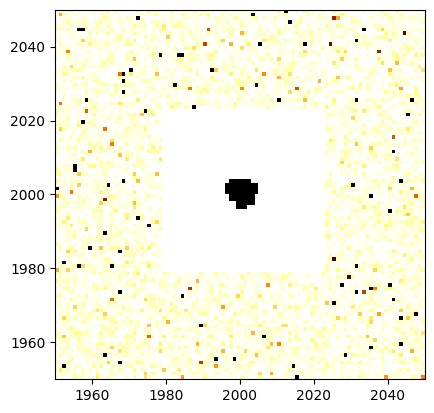

In [15]:
norm = simple_norm(image_model.data[1,:], 'log', percent=90)
plt.imshow(image_model.data[1950:2050, 1950:2050], norm=norm, cmap='afmhot', origin='lower',
           extent=[1950, 2050, 1950, 2050]);

Number of stars: 1
Number of galaxies: 0
    ra       dec    type  n  ...  F146          x                  y         
--------- --------- ---- --- ... ------ ------------------ ------------------
79.922971 30.034266  PSF  -1 ... 0.0001 2000.0096709752497 2000.0034257725233


/tmp/ipykernel_895/515508478.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.xaxis.set_inverted(True)


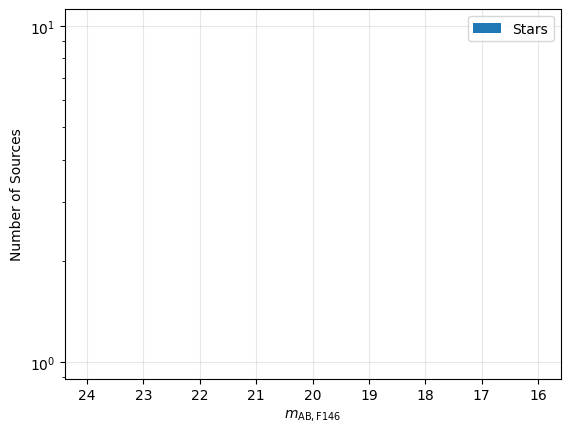

In [16]:
from astropy.table import Table
from astropy.stats import SigmaClip, sigma_clipped_stats
import asdf
import crds
import copy
import matplotlib.pyplot as plt
import numpy as np
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import roman_datamodels as rdm
import os
import s3fs
import stpsf
import glob



cat = Table.read(CATALOG_FILE_NAME)

x_cat, y_cat = wcs.invert(cat["ra"].data, cat["dec"].data)
cat['x'] = x_cat
cat['y'] = y_cat

mask = (np.isfinite(x) & np.isfinite(y))
#print(f"Number of sources on detector: {sum(mask)}")
stars = cat[mask & (cat["type"] == "PSF")]
galaxies = cat[mask & (cat["type"] == "SER")]

print(f"Number of stars: {len(stars)}\nNumber of galaxies: {len(galaxies)}")
print(stars)
stars['abmag'] = -2.5 * np.log10(stars['F146'])
fig, ax = plt.subplots()
ax.hist(stars['abmag'], bins=50, range=[16, 24], log=True, label='Stars')
ax.set_xlabel(r'$m_{\mathrm{AB, F146}}$')
ax.set_ylabel('Number of Sources')
ax.xaxis.set_inverted(True)
ax.legend()

ax.grid(alpha=0.3)

In [17]:

crds_result = crds.getreferences({'ROMAN.META.INSTRUMENT.DETECTOR': meta.instrument.detector,
                                  'ROMAN.META.INSTRUMENT.NAME': meta.instrument.name,
                                  'ROMAN.META.EXPOSURE.START_TIME': meta.exposure.start_time.isot}, 
                                 observatory='roman', reftypes=['area'], ignore_cache=False)

print(crds_result)

{'area': '/home/lmjames503/crds_cache/references/roman/wfi/roman_wfi_area_0009.asdf'}


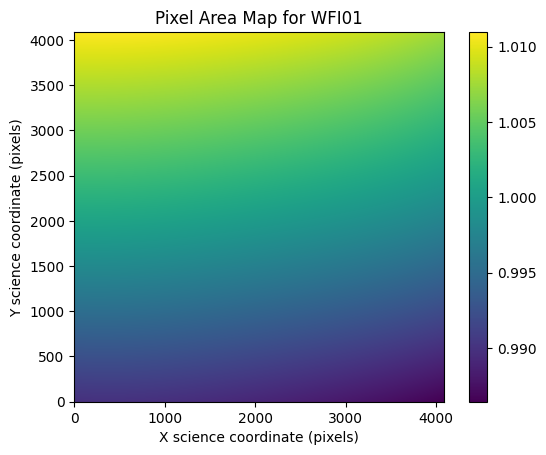

In [18]:
pam = rdm.open(crds_result['area'])

fig, ax = plt.subplots()
img = ax.imshow(pam.data, origin='lower')
ax.set_xlabel('X science coordinate (pixels)')
ax.set_ylabel('Y science coordinate (pixels)')
ax.set_title(f'Pixel Area Map for {pam.meta.instrument.detector}')
plt.colorbar(img);


Processing image 1 of 15
Loading: ./L2_simulation_files/roman_sim_F146_WFI01_L2_32_unsat.asdf
Center: RA=79.921408, Dec=30.035592
Center signal: 1.8288378715515137
Star location signal: 0.0

Corner coordinates:
Corner (0, 0): RA=79.993847, Dec=29.974280, Signal=1.366926670074463
Corner (4087, 0): RA=79.849668, Dec=29.974604, Signal=1.7379499673843384
Corner (4087, 4087): RA=79.848646, Dec=30.097431, Signal=2.2457973957061768
Corner (0, 4087): RA=79.993772, Dec=30.097214, Signal=1.334532618522644
Inverted center coordinates: x=2044.00, y=2044.00


/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


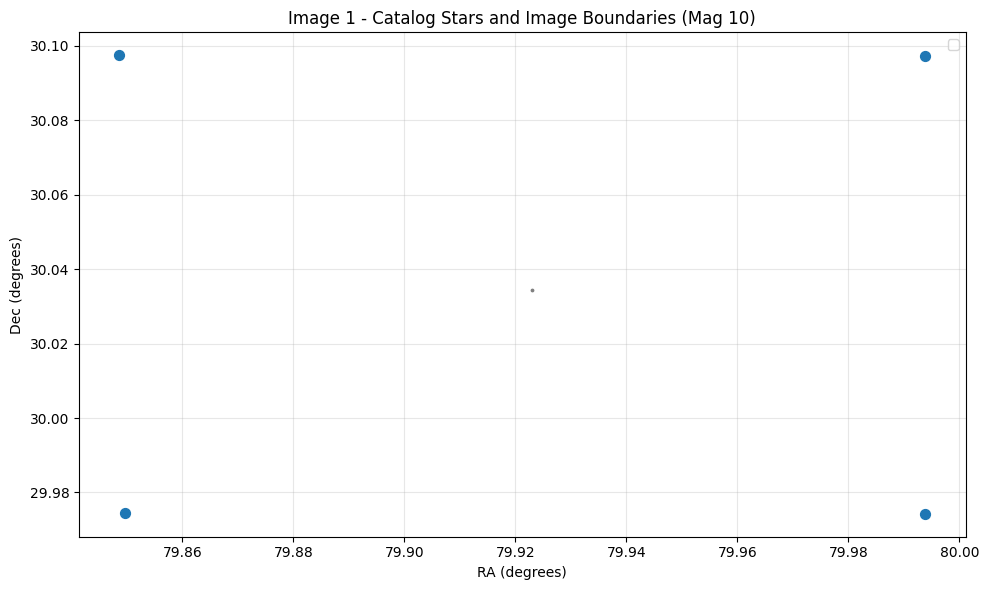

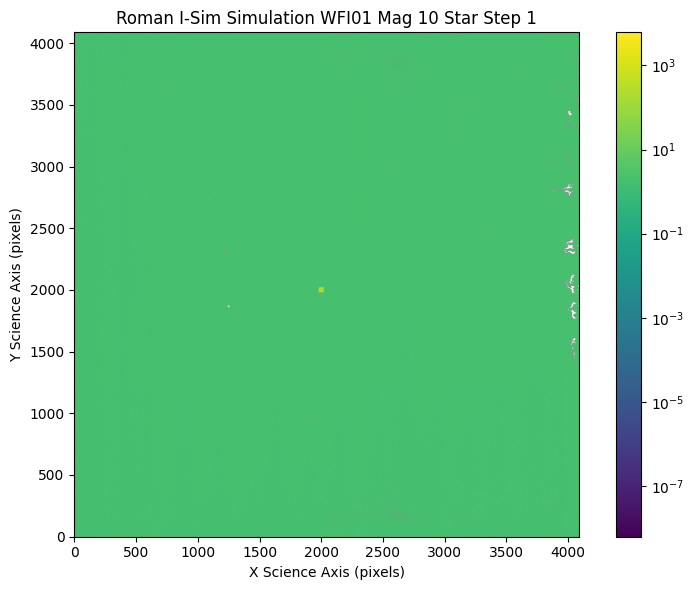

Signal range for zoom: -43259.859375, 6105.1181640625


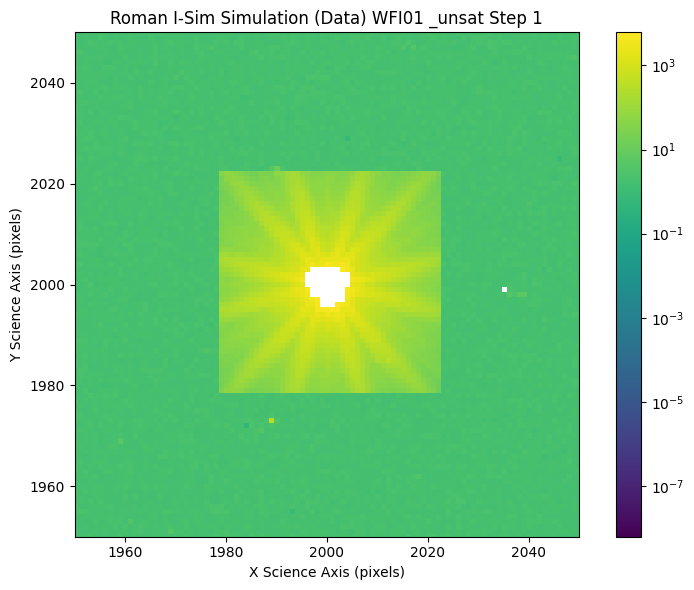

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


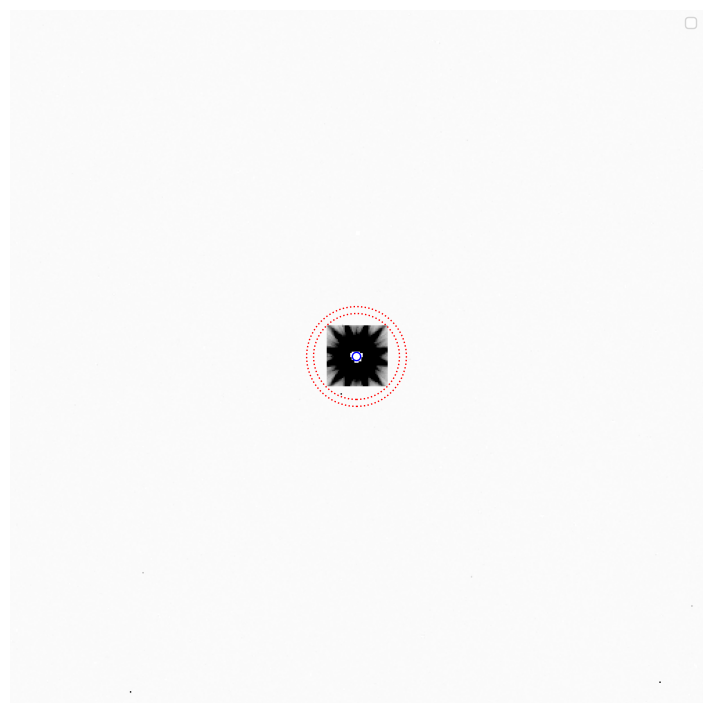

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 1
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


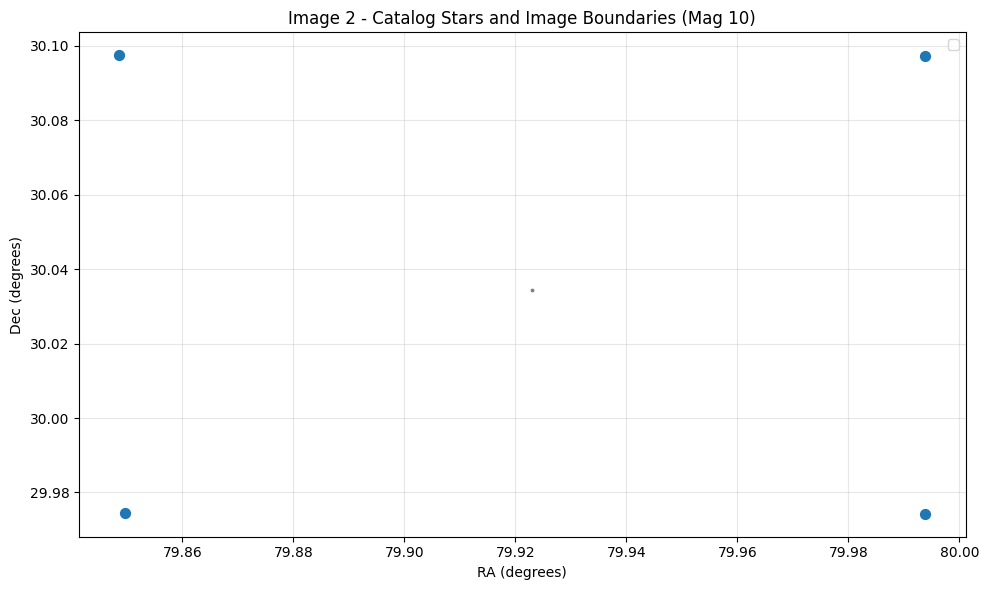

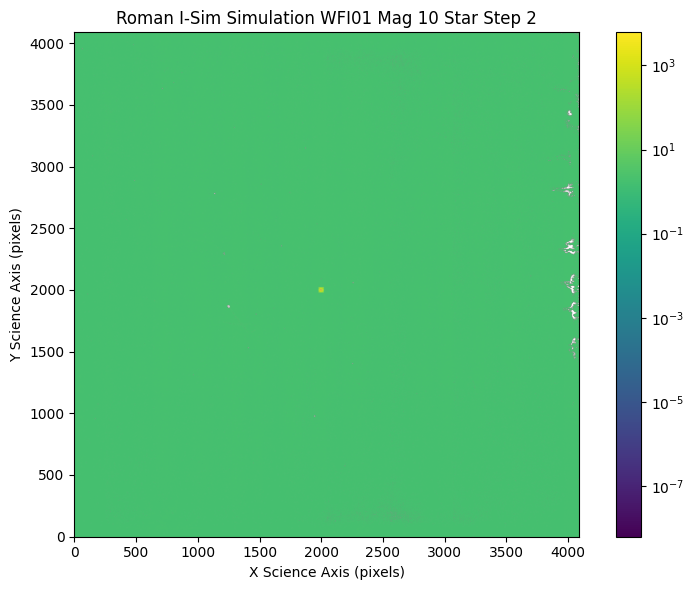

Signal range for zoom: -43259.859375, 6105.1181640625


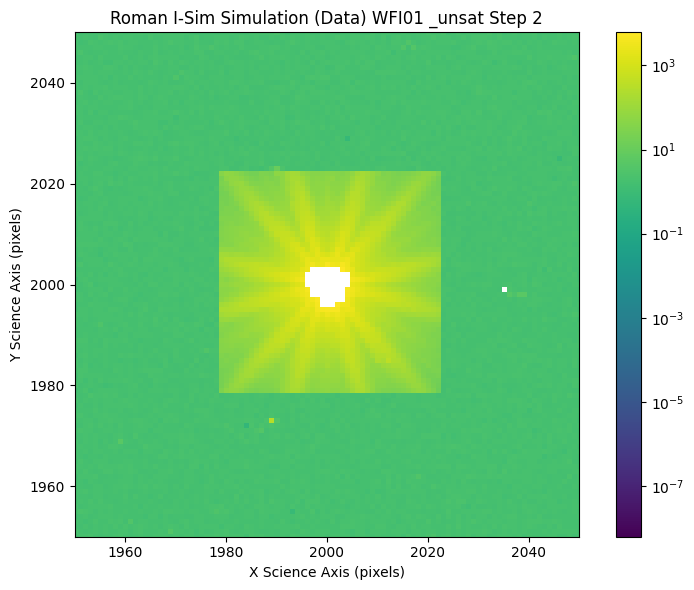

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


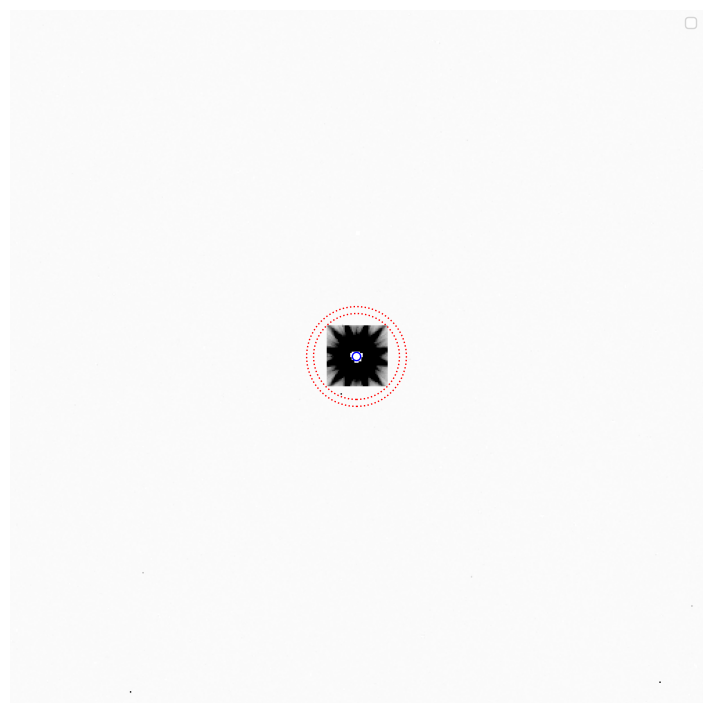

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 2
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


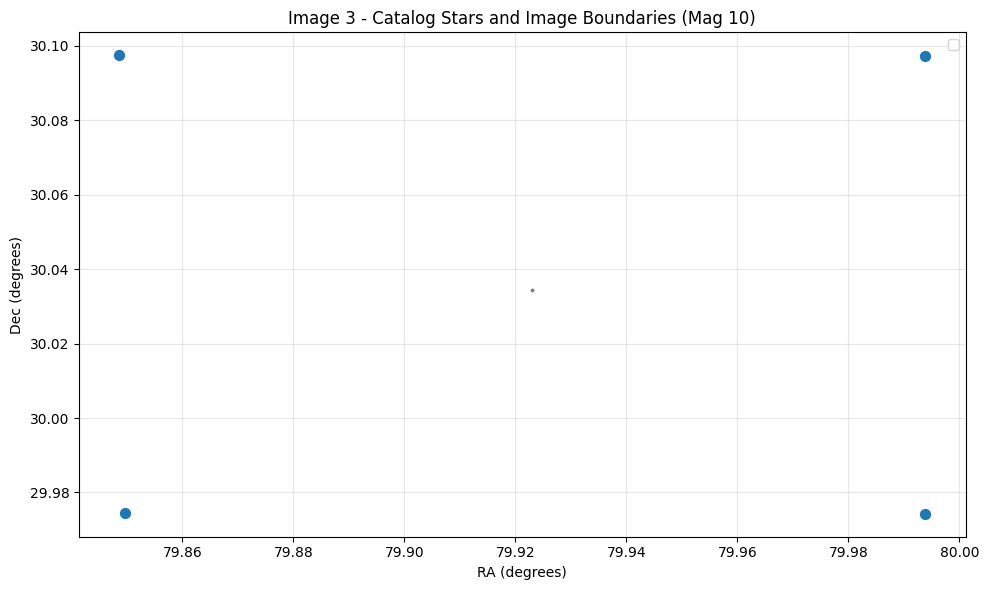

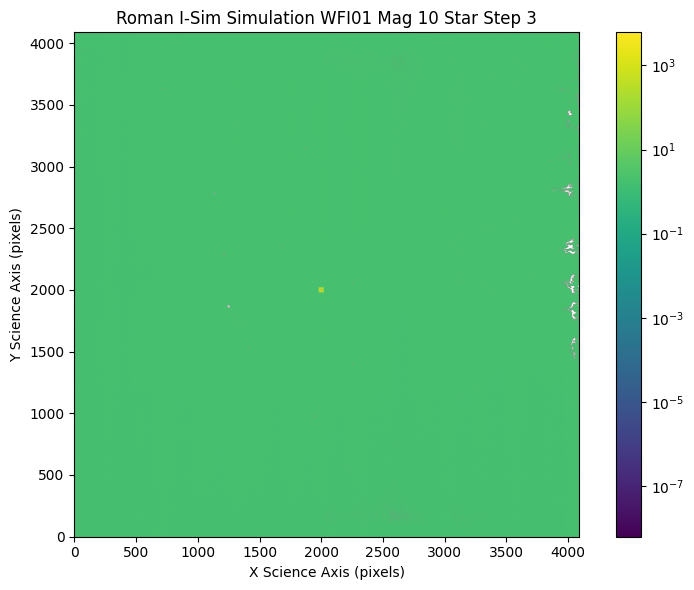

Signal range for zoom: -43259.859375, 6105.1181640625


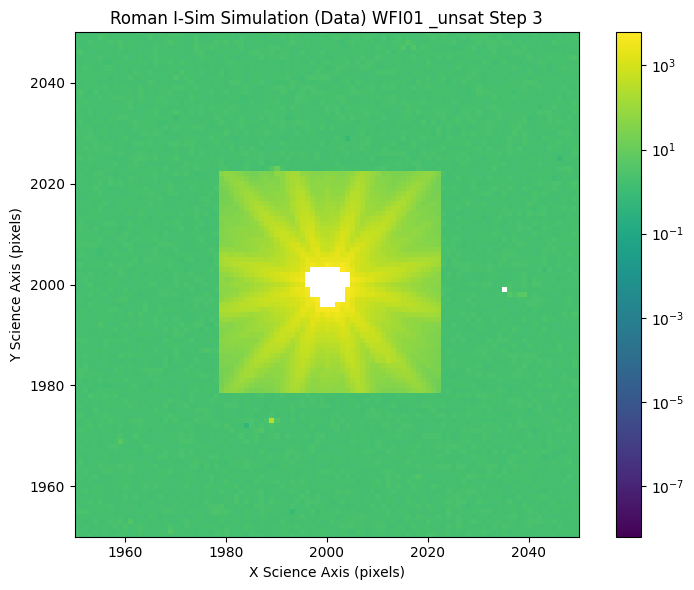

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


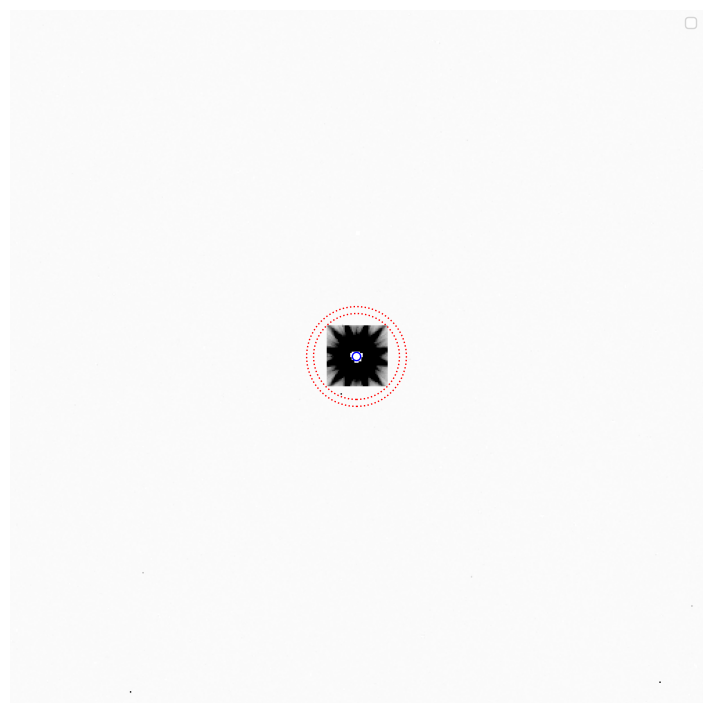

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 3
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


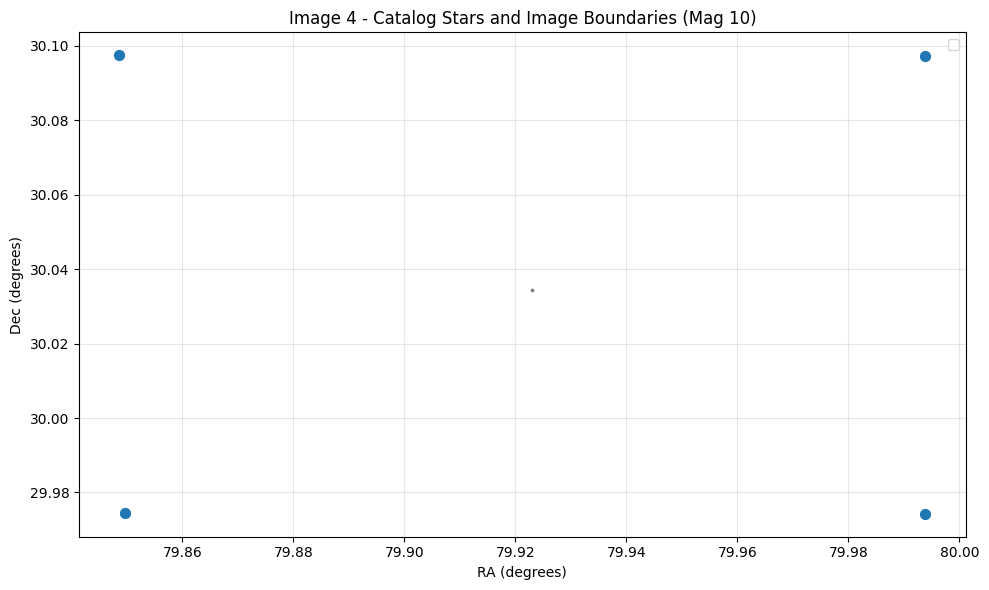

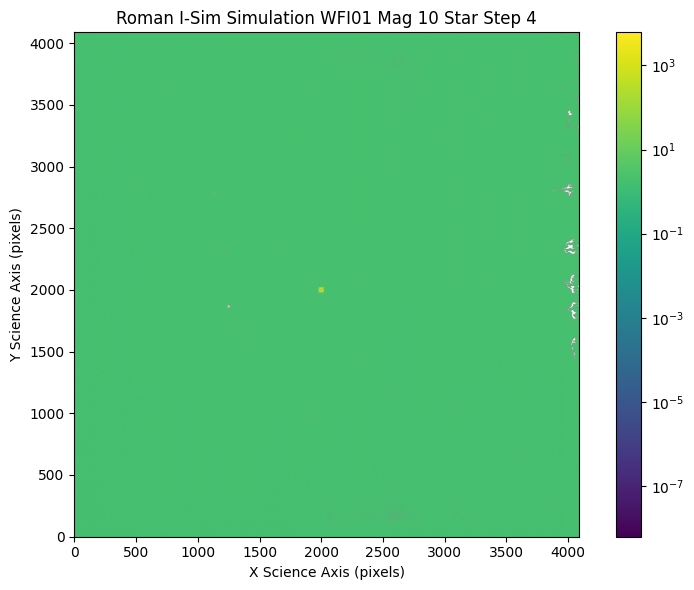

Signal range for zoom: -43259.859375, 6105.1181640625


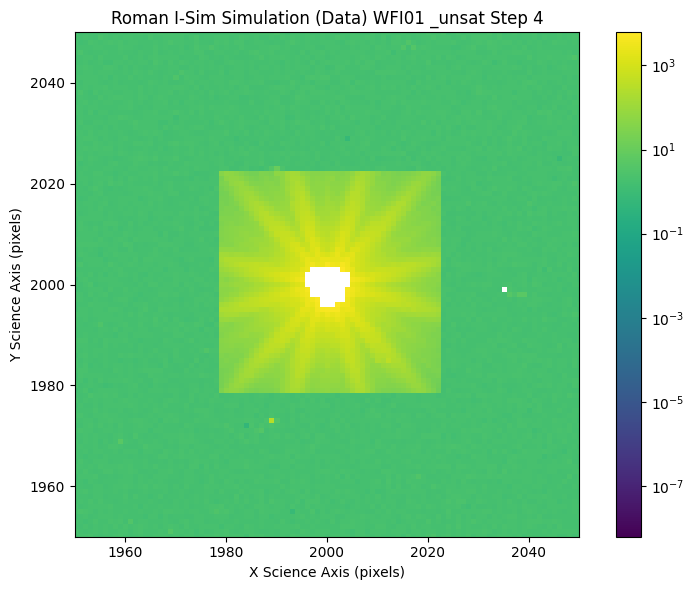

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


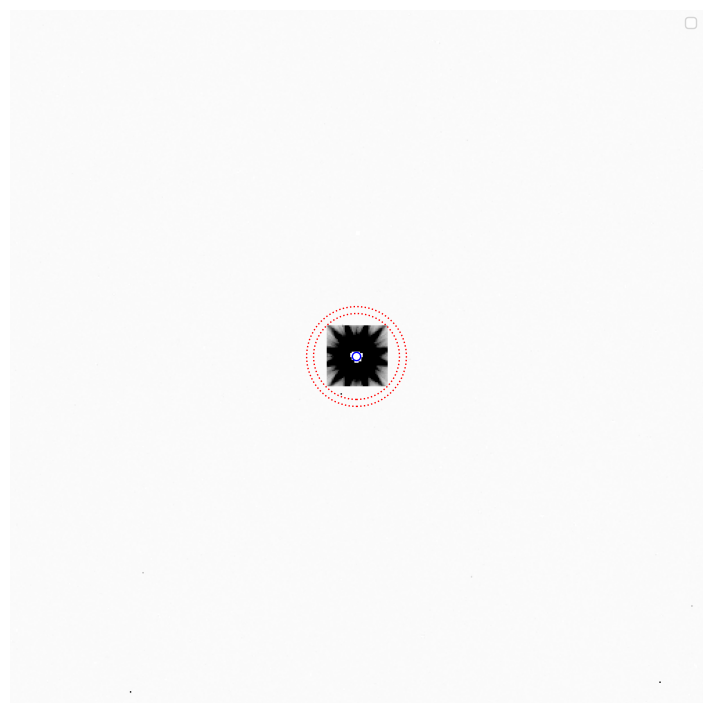

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 4
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


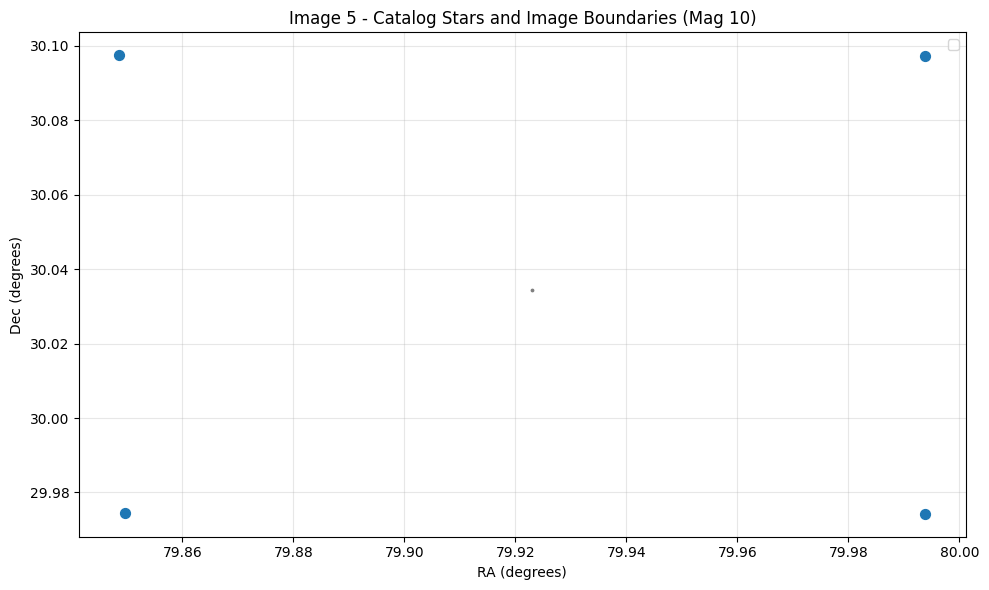

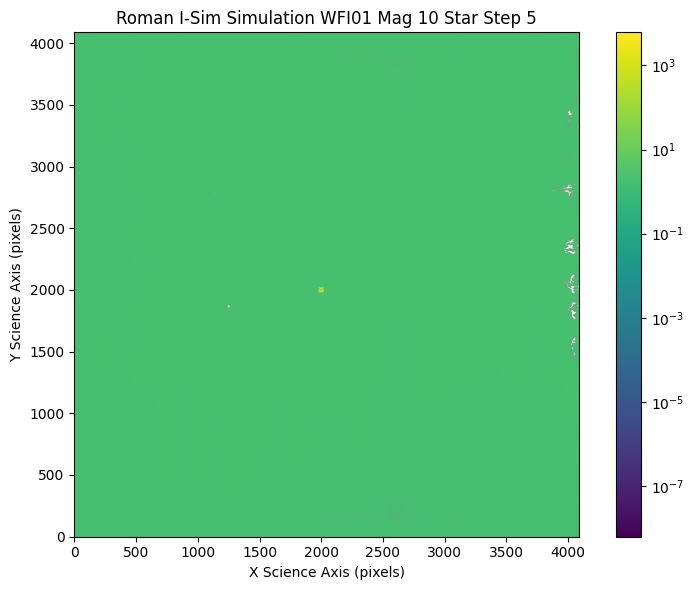

Signal range for zoom: -43259.859375, 6105.1181640625


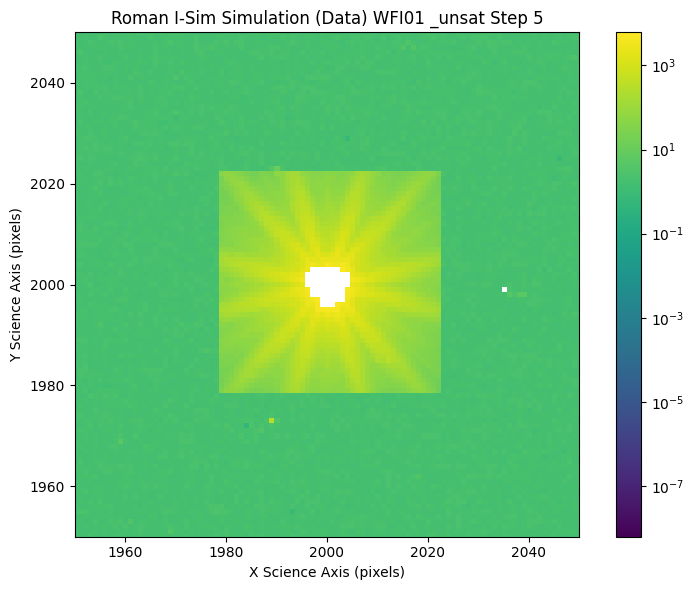

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


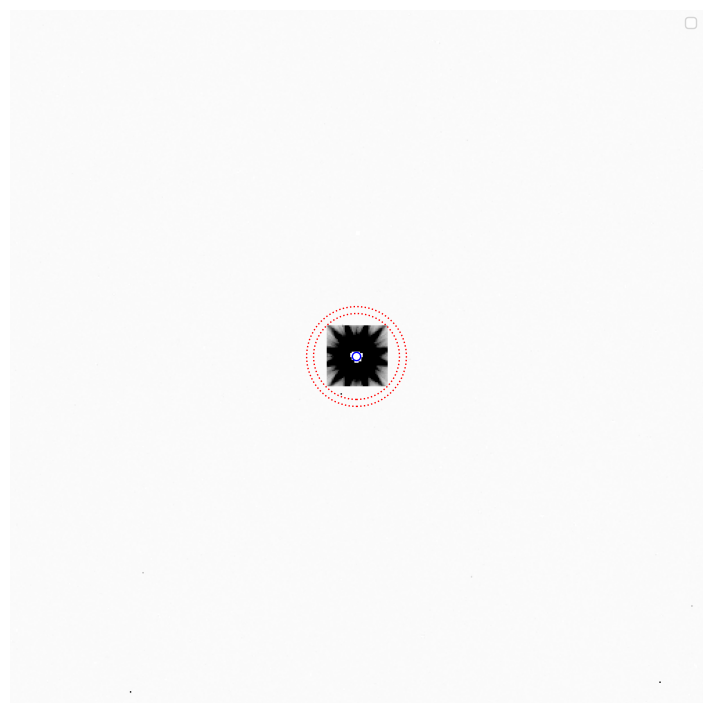

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 5
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


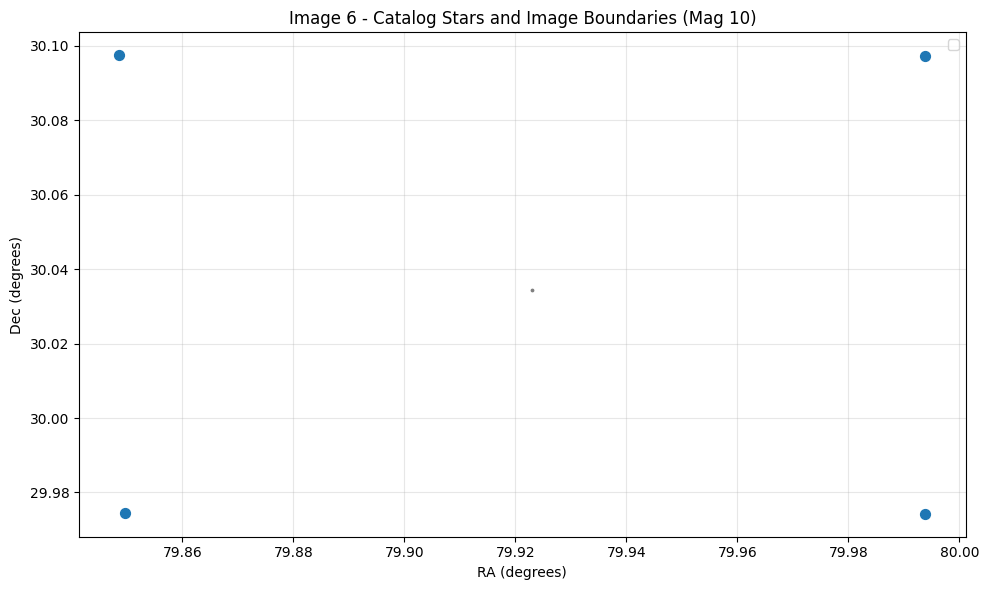

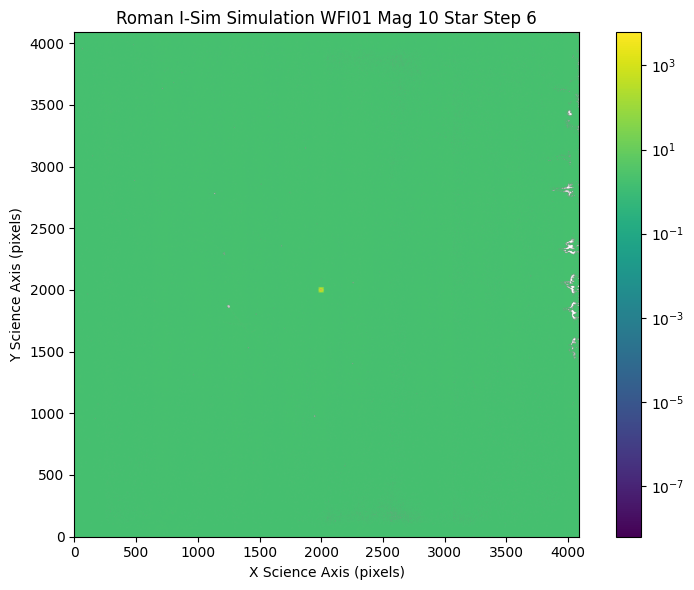

Signal range for zoom: -43259.859375, 6105.1181640625


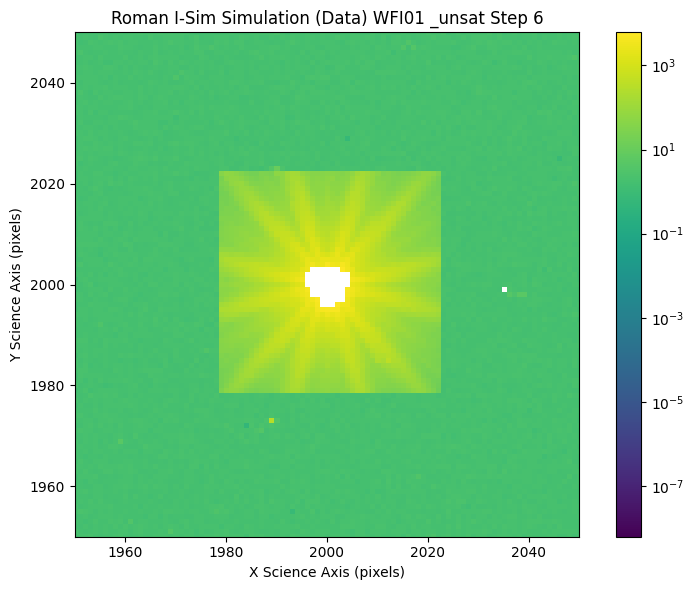

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


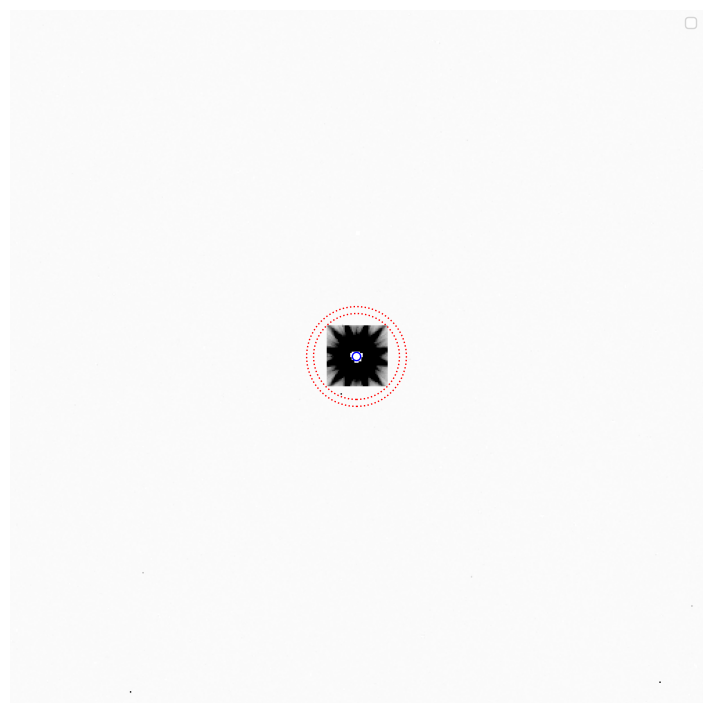

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 6
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


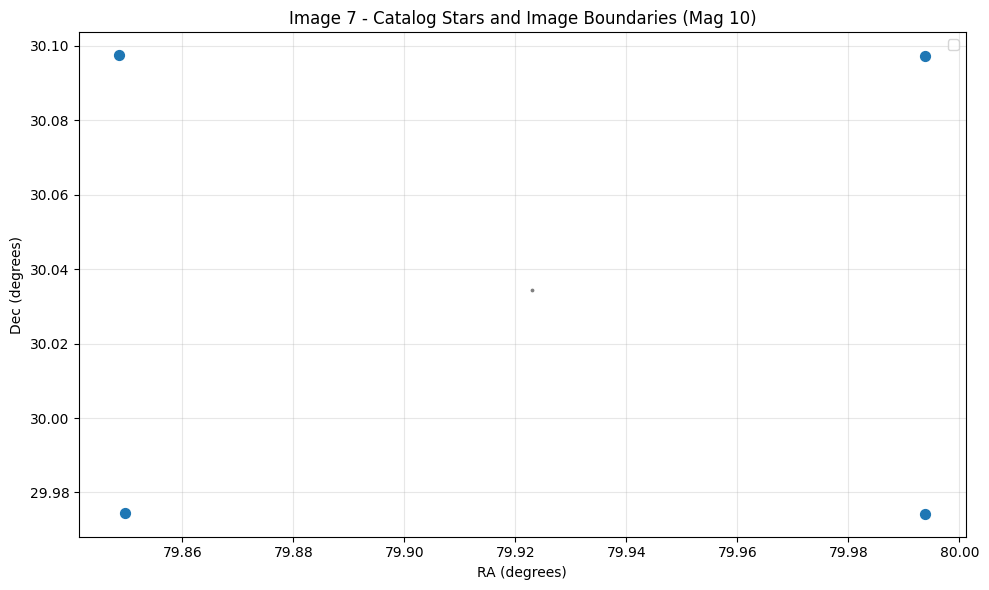

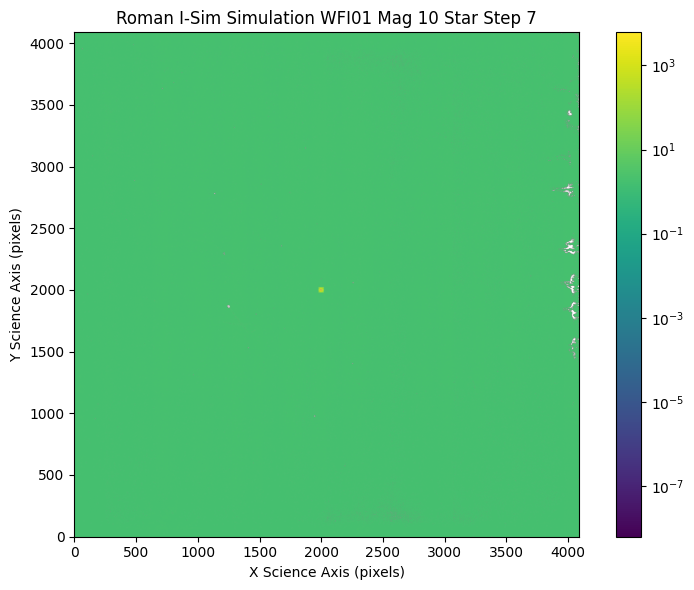

Signal range for zoom: -43259.859375, 6105.1181640625


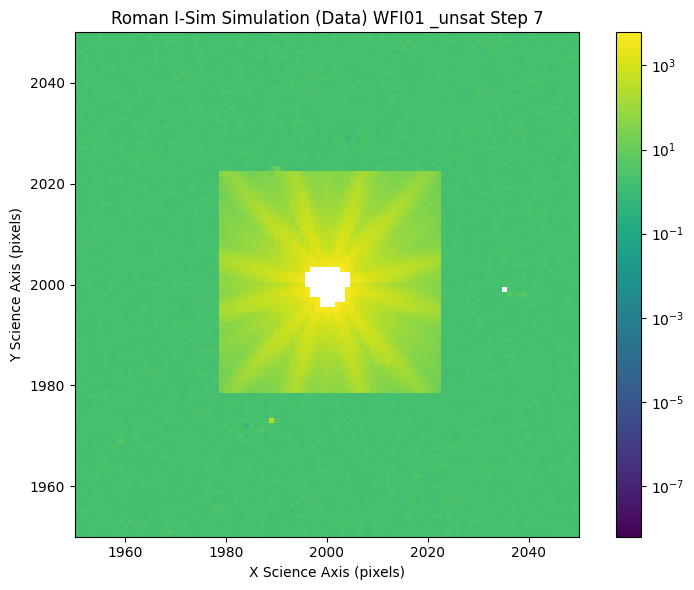

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


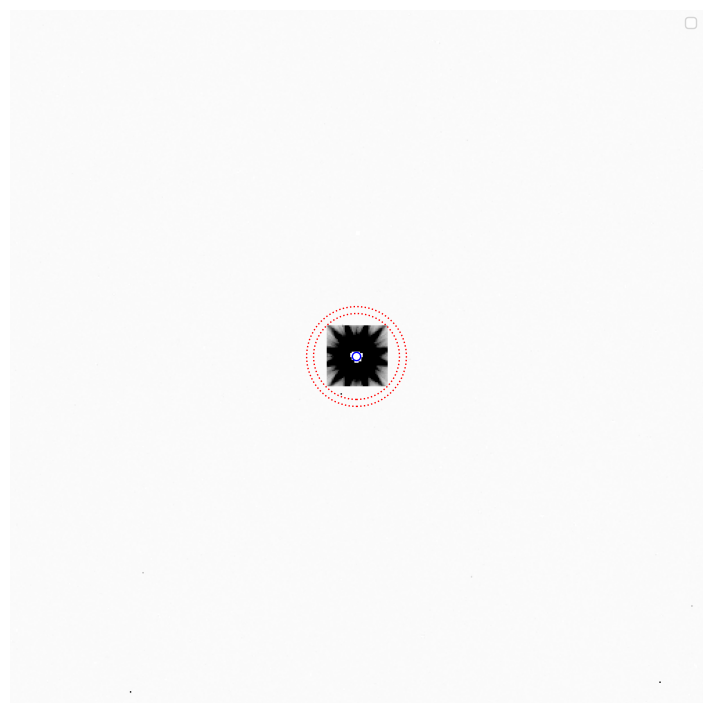

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 7
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


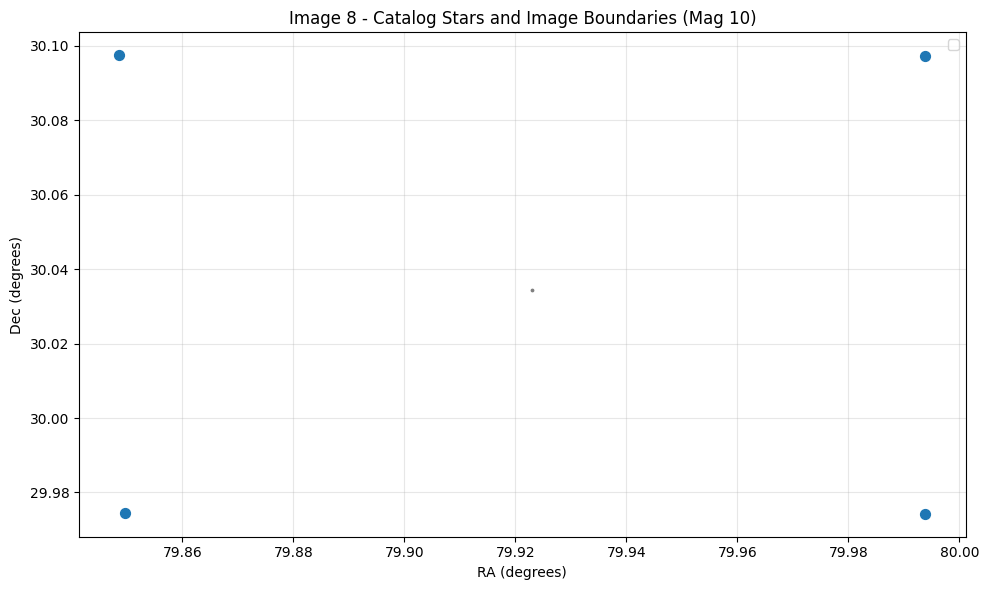

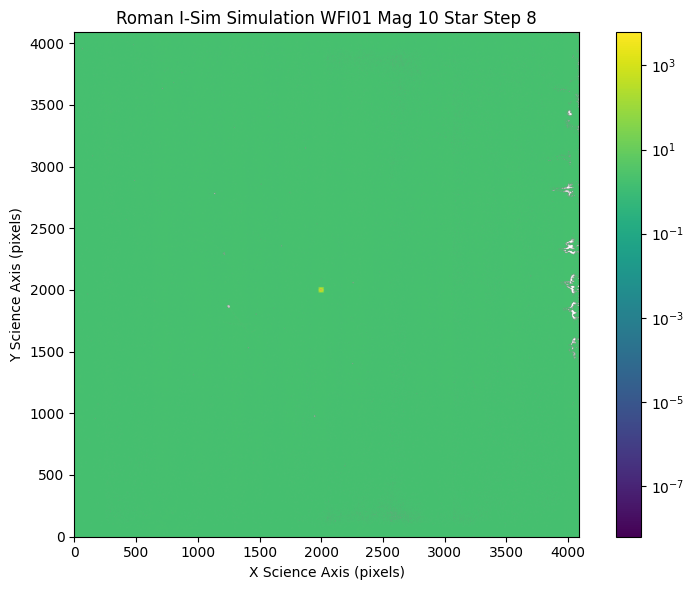

Signal range for zoom: -43259.859375, 6105.1181640625


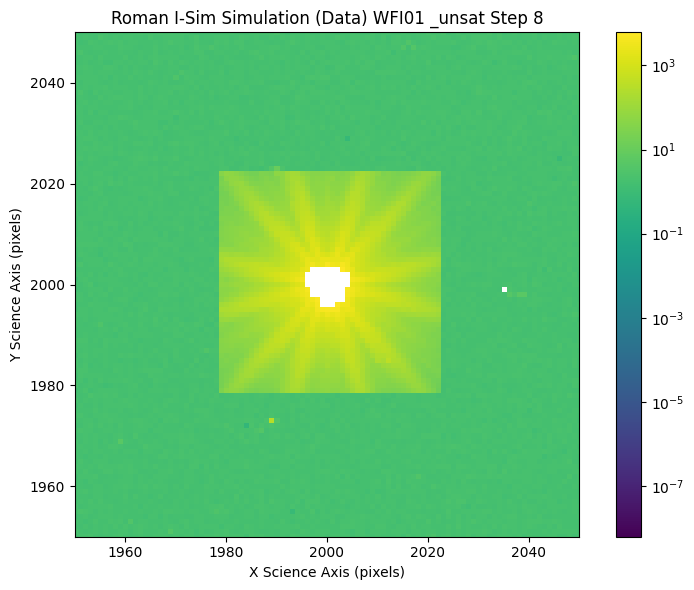

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


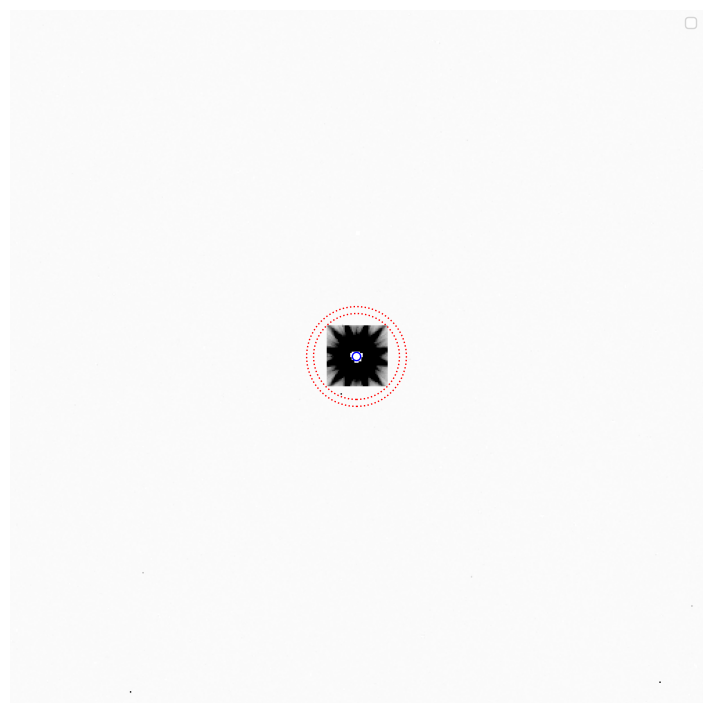

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 8
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


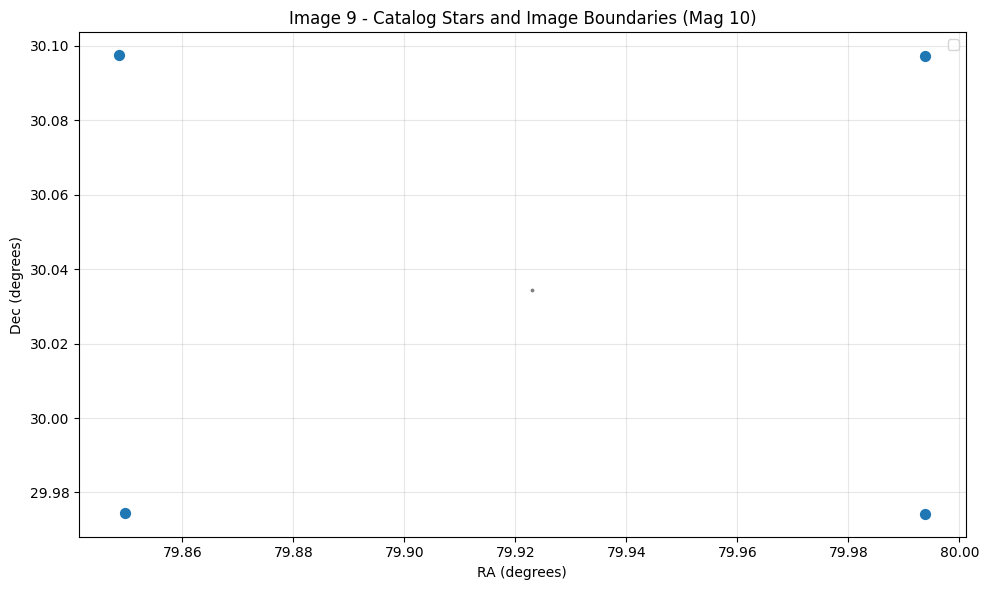

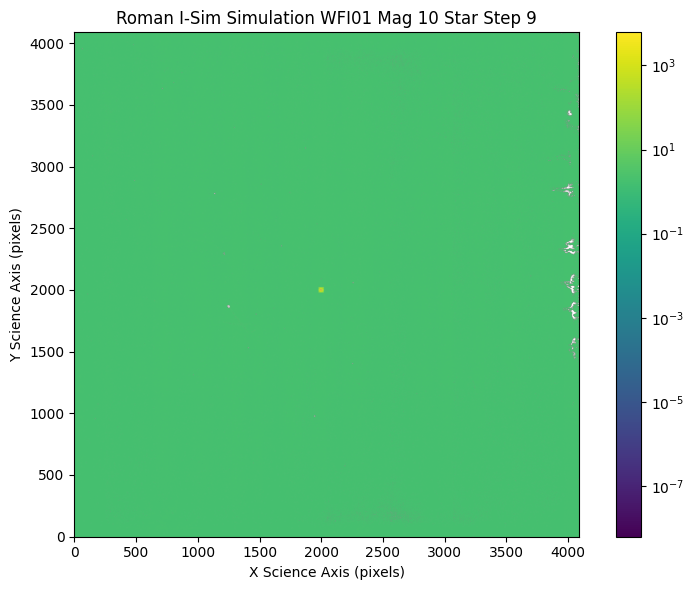

Signal range for zoom: -43259.859375, 6105.1181640625


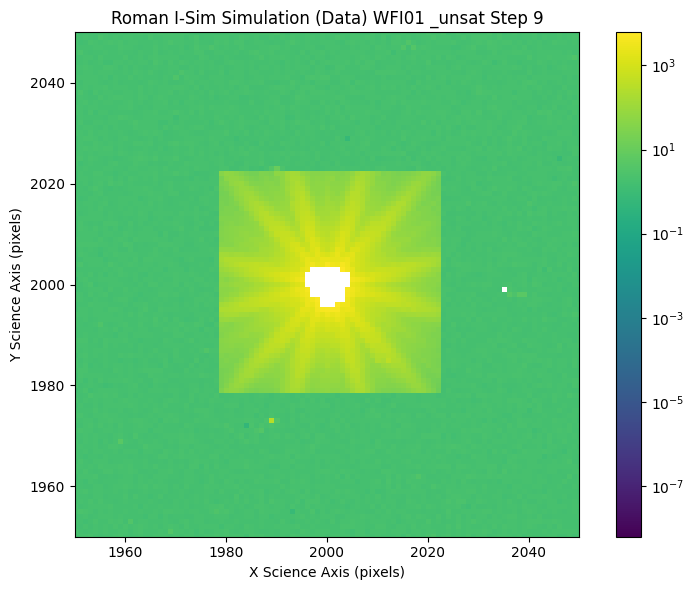

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


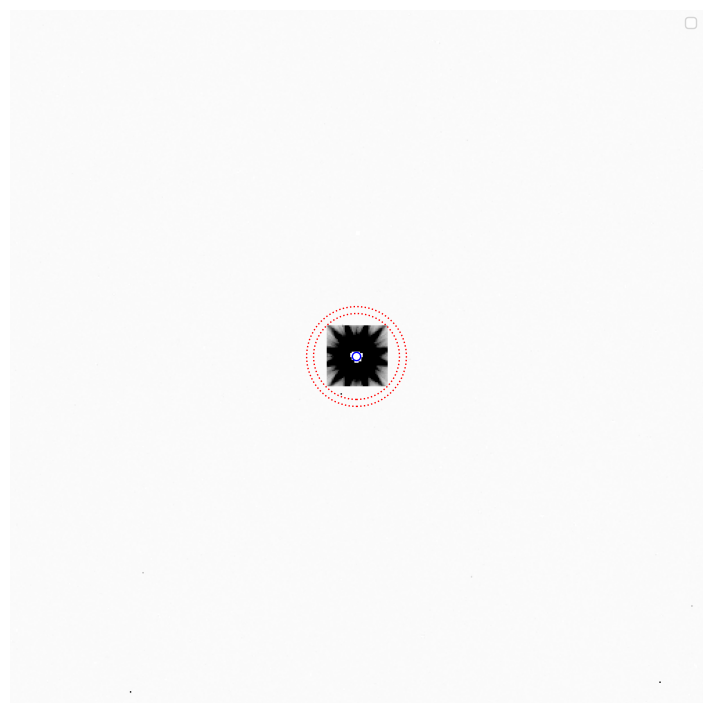

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 9
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

-------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


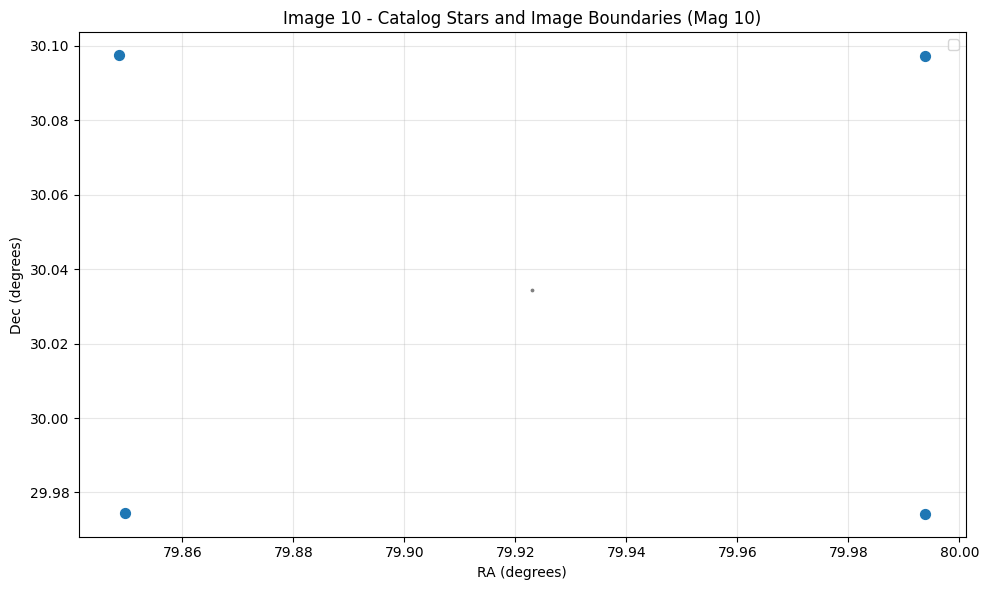

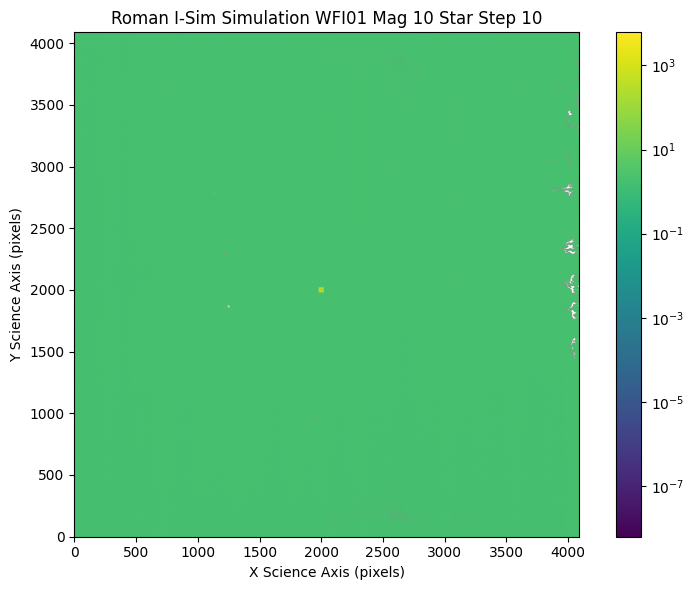

Signal range for zoom: -43259.859375, 6105.1181640625


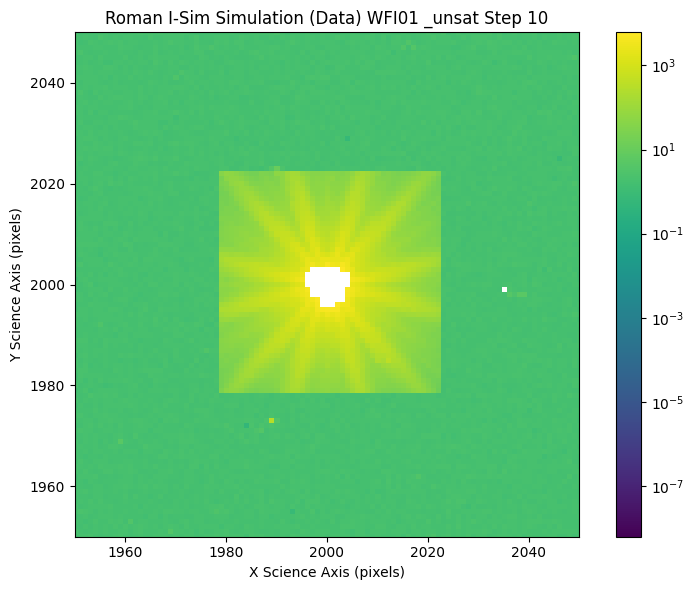

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


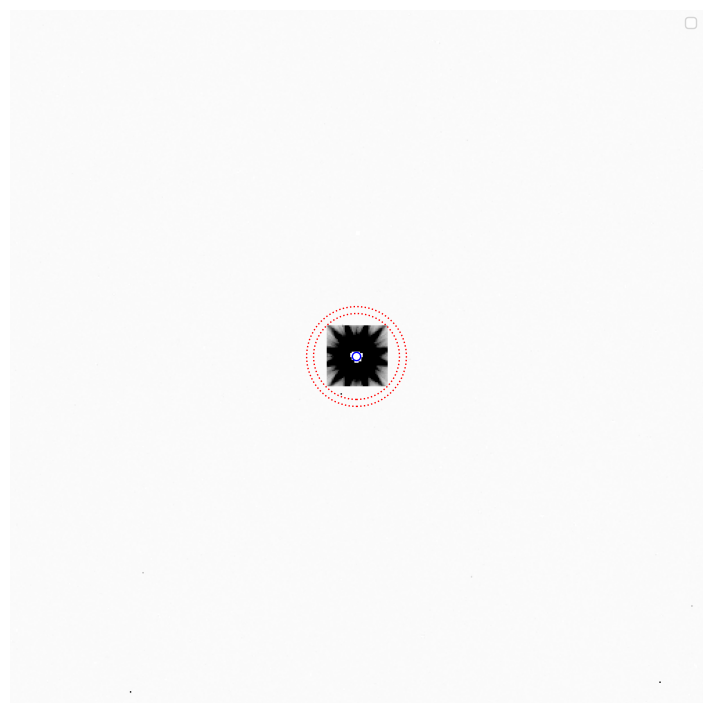

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 10
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


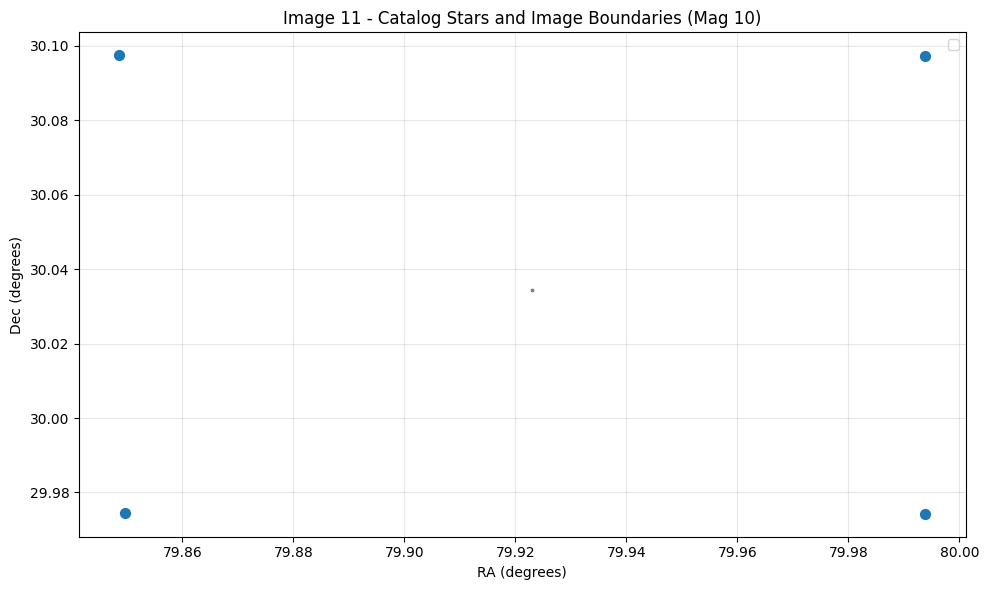

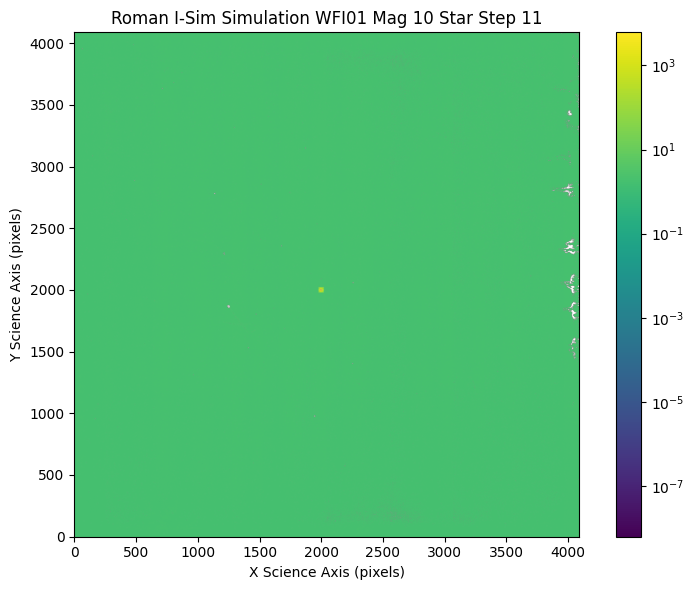

Signal range for zoom: -43259.859375, 6105.1181640625


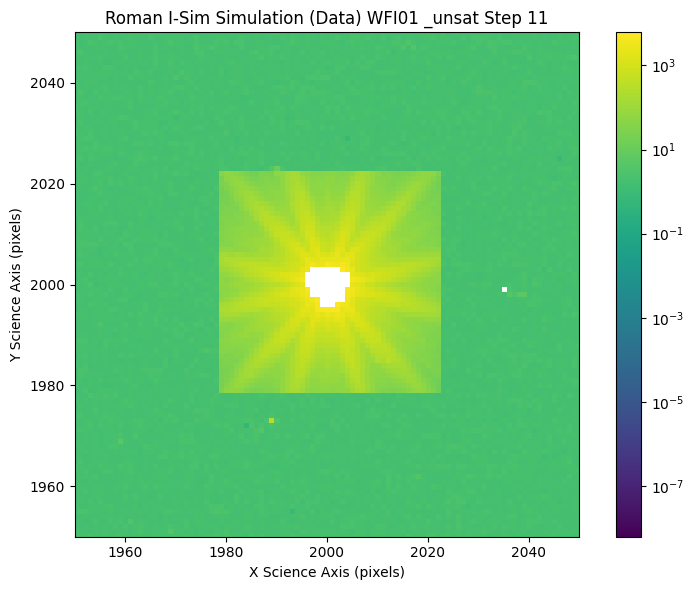

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


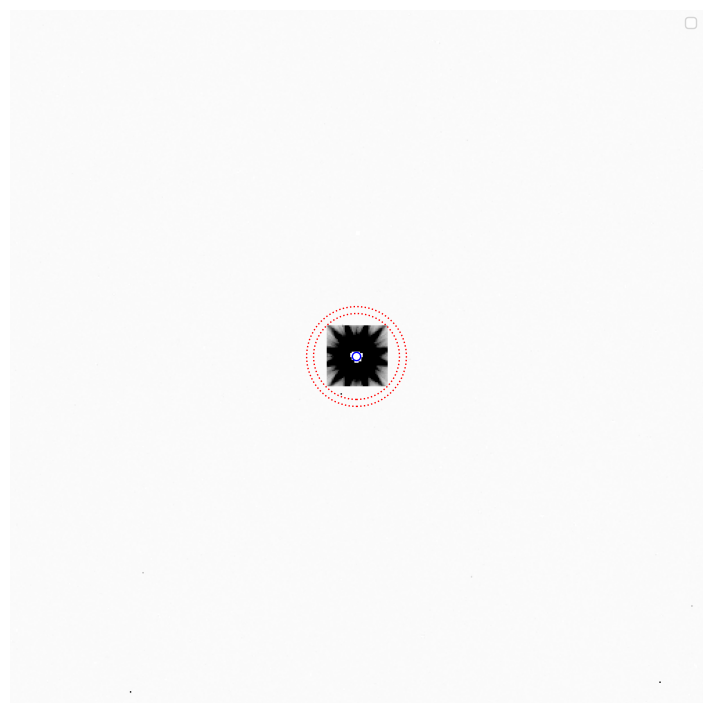

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 11
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


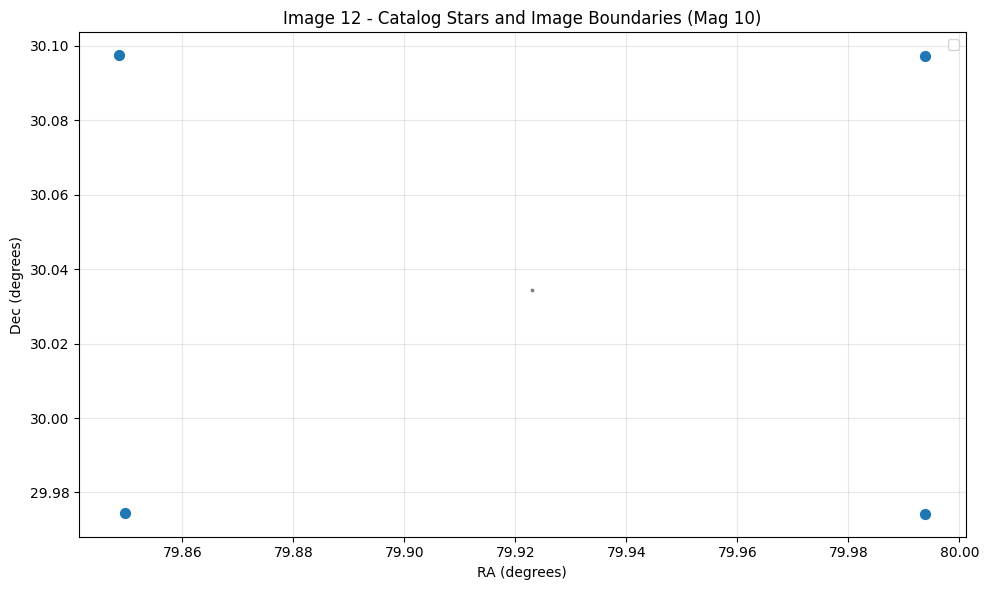

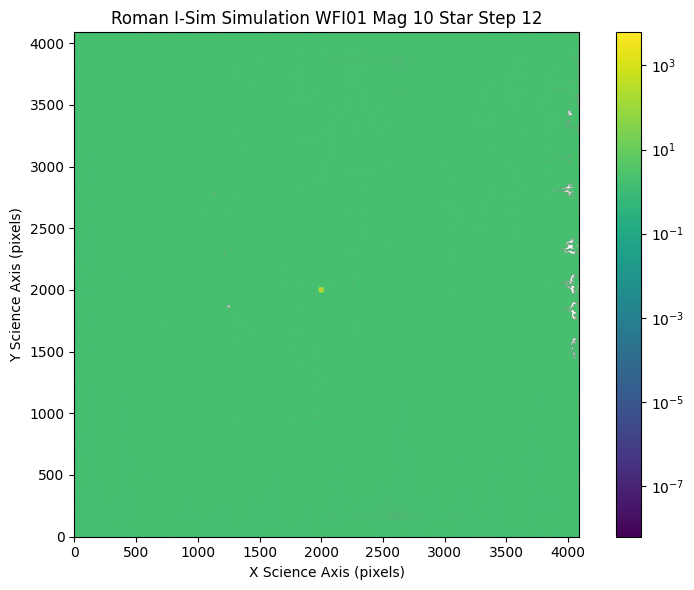

Signal range for zoom: -43259.859375, 6105.1181640625


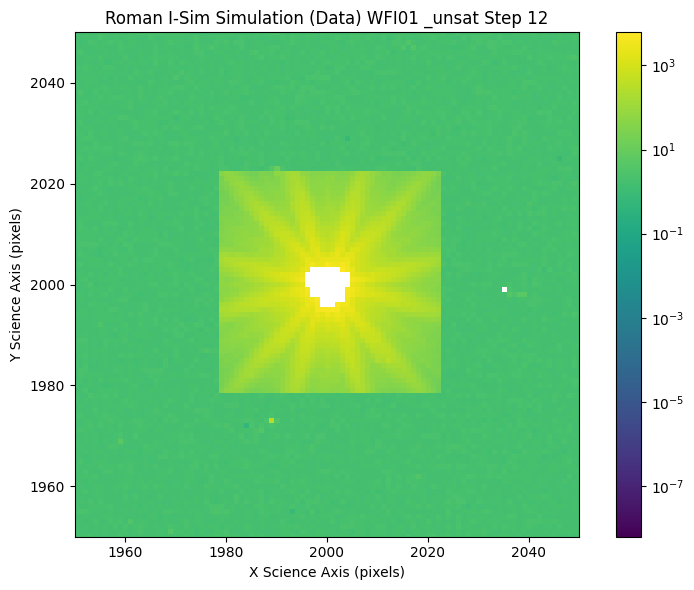

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


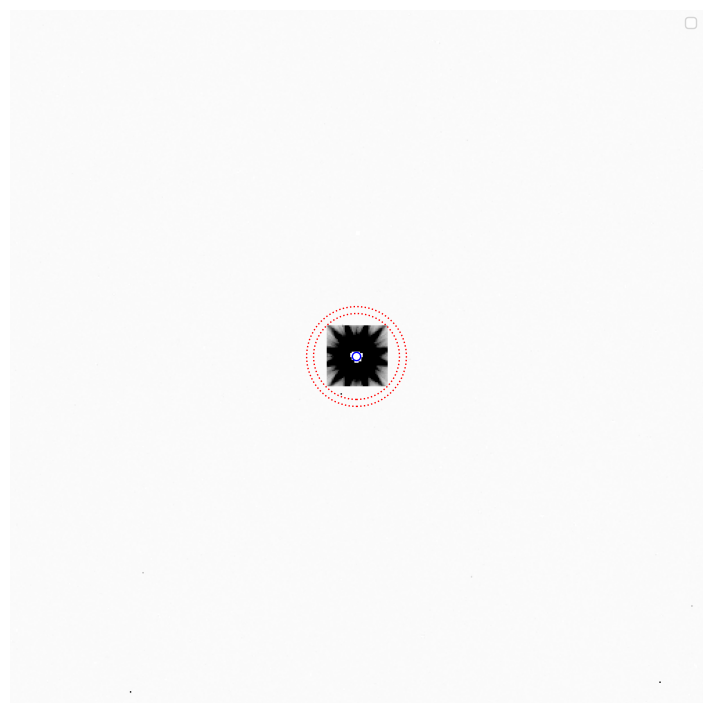

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 12
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


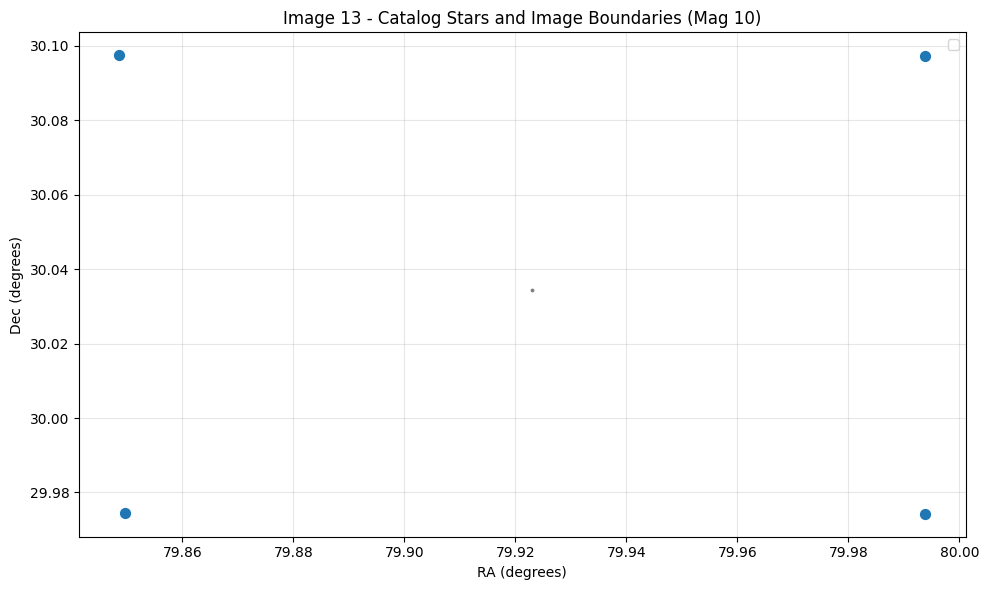

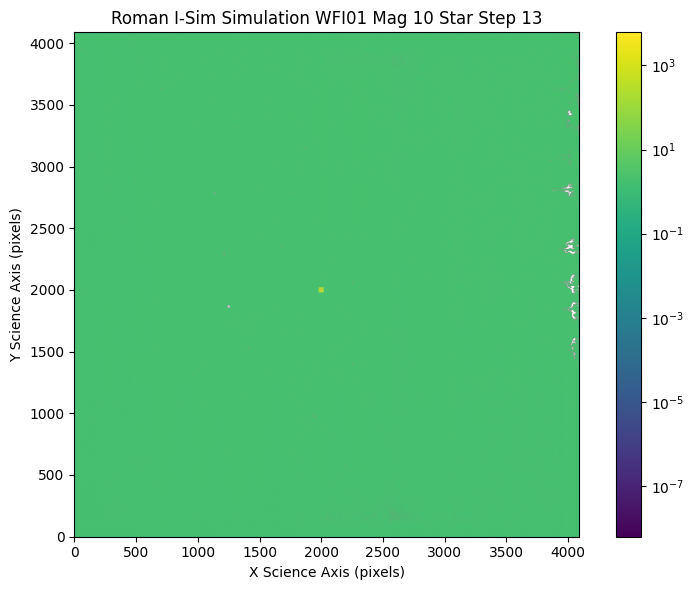

Signal range for zoom: -43259.859375, 6105.1181640625


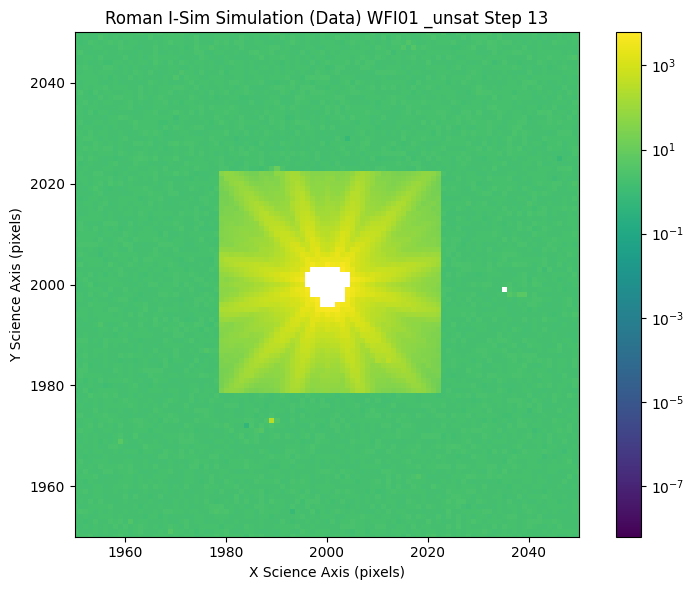

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


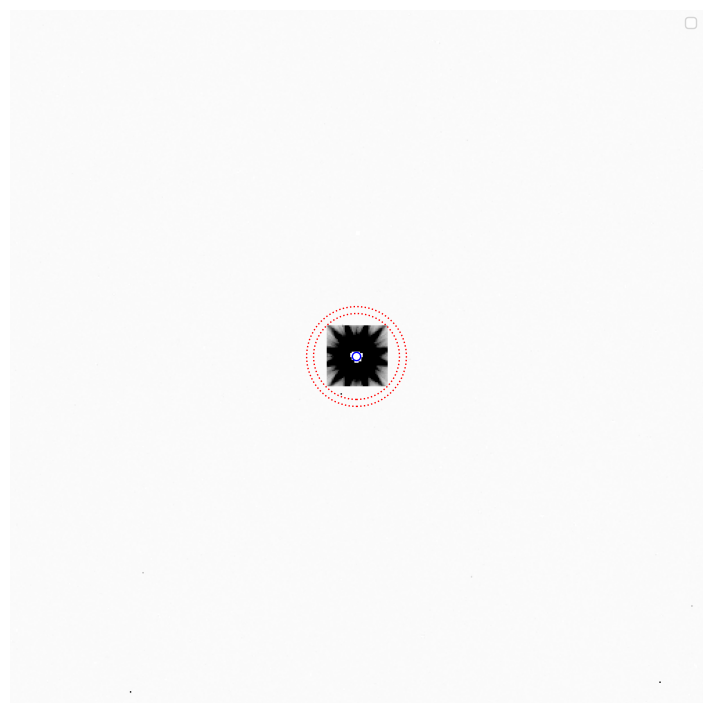

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 13
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


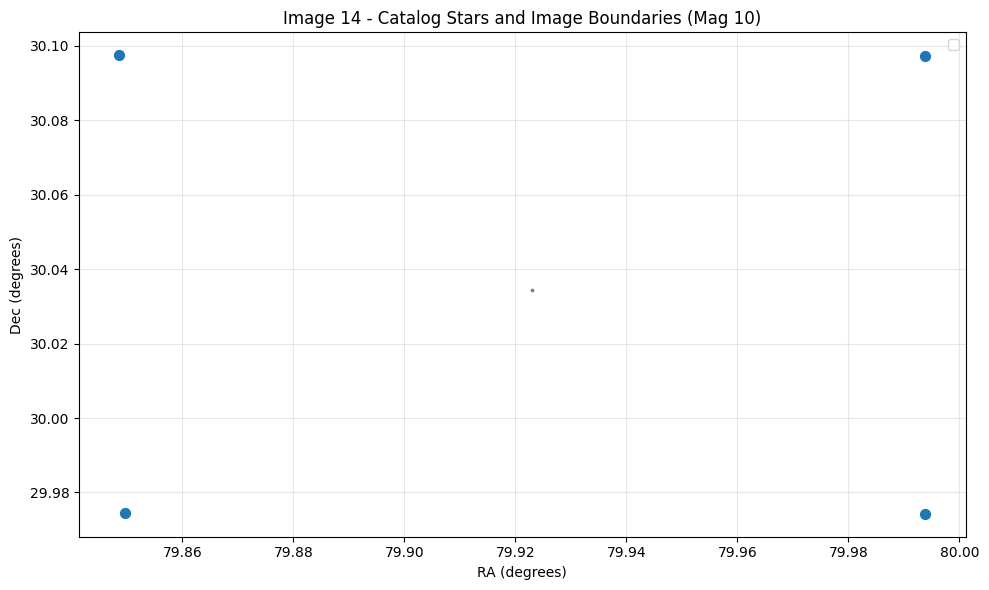

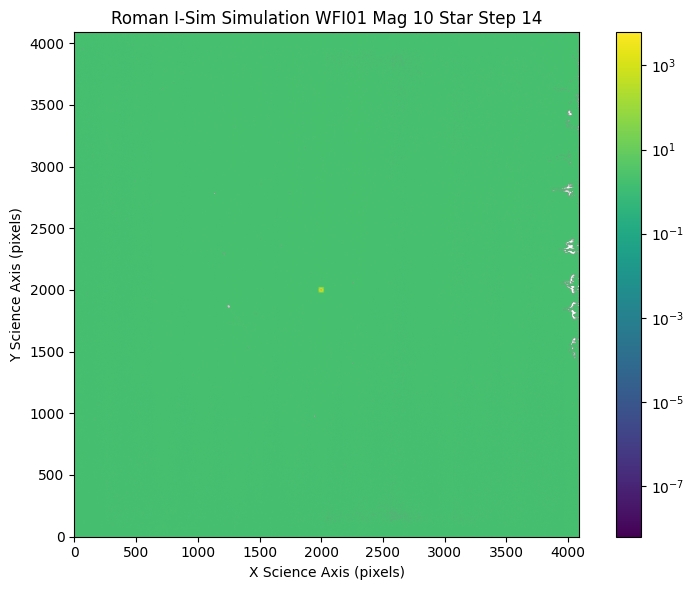

Signal range for zoom: -43259.859375, 6105.1181640625


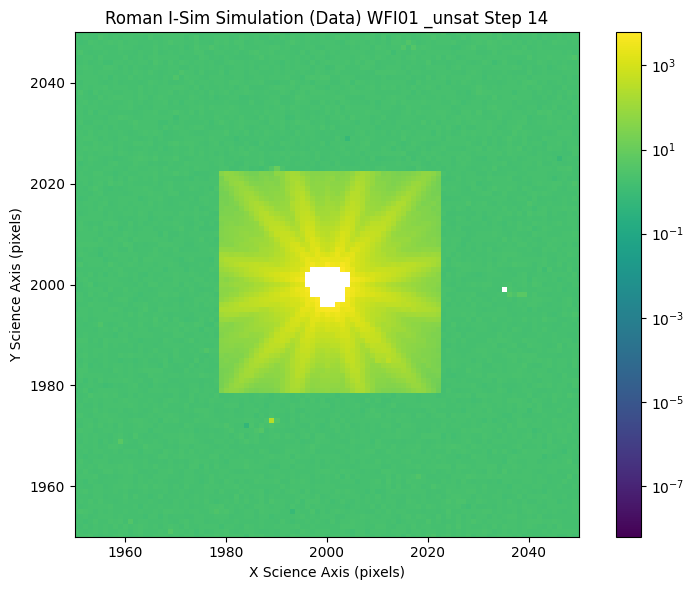

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


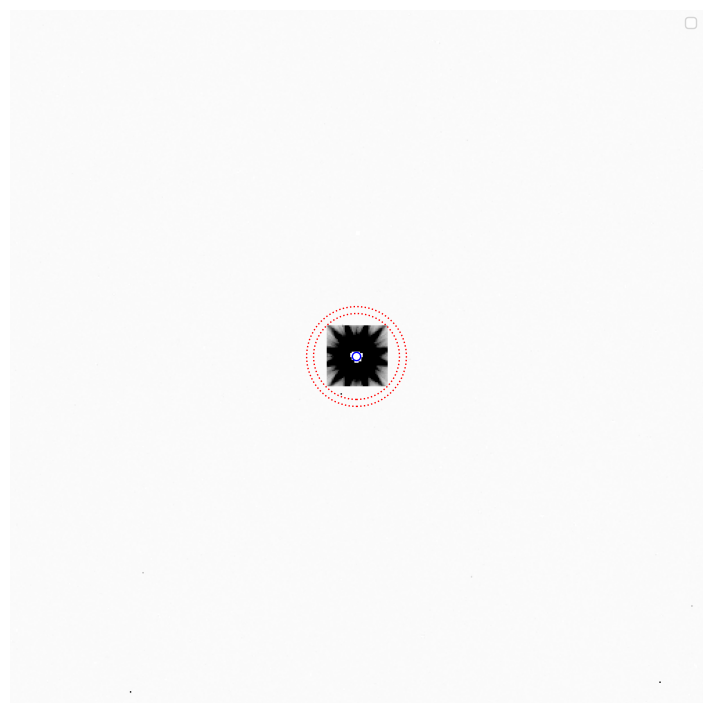

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


<Figure size 640x480 with 0 Axes>


PHOTOMETRY ANALYSIS - IMAGE 14
Calculating star photometry...
First 5 star measurements:
 id xcentroid ycentroid        sum             sum_err      
--- --------- --------- ----------------- ------------------
  1       nan       nan 32.87924501321191 1.7240320067085562

Calculating background photometry...
First 5 background measurements:
 id     xcentroid          ycentroid            median              std       
--- ------------------ ------------------ ------------------ -----------------
  1 1999.9509330735734 2000.0478541074642 1.8868910074234009 0.185621773180074
Star Background Sum Error: [5.85314401]
Zeropoint = 0.24039322273833708 (MJy/sr) / (DN/s)
Pixel area = 2.8083389953727505e-13
Background-subtracted flux: [-20.47134133]
Basic photometry table:
 id xcentroid ycentroid ...      sum_err               flux_jy        
--- --------- --------- ... ------------------ -----------------------
  1       nan       nan ... 1.7240320067085562 -1.3820318433372068e-06

------------

/tmp/ipykernel_895/3267117163.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


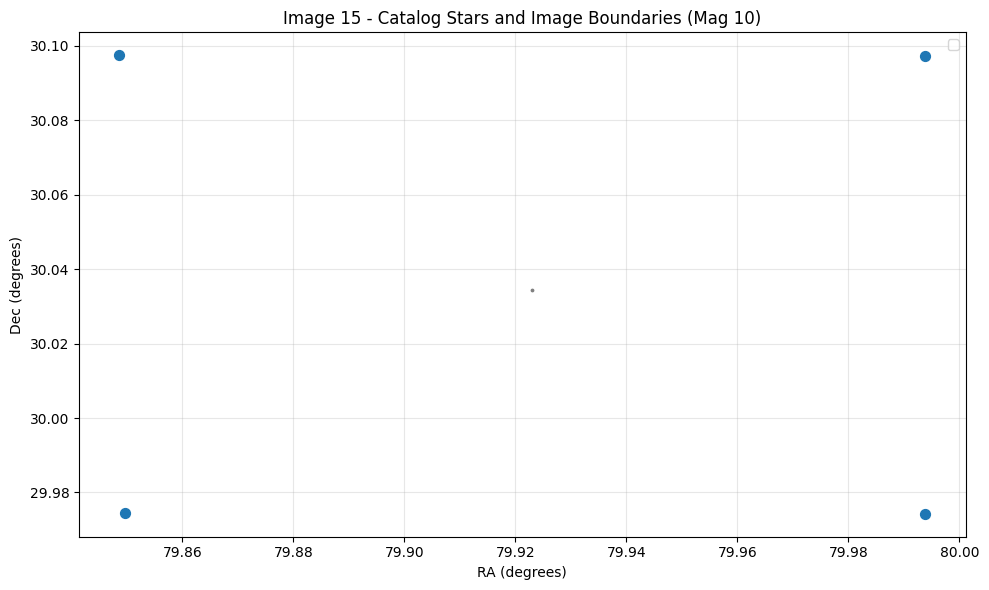

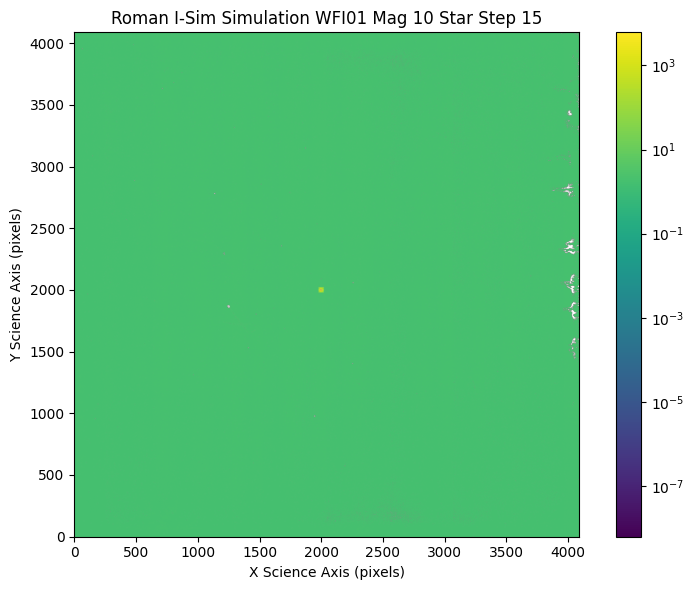

Signal range for zoom: -43259.859375, 6105.1181640625


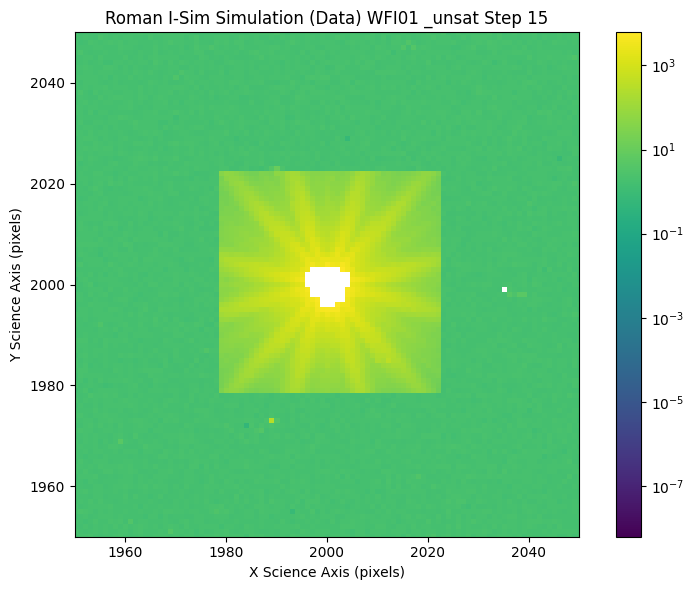

/tmp/ipykernel_895/3267117163.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


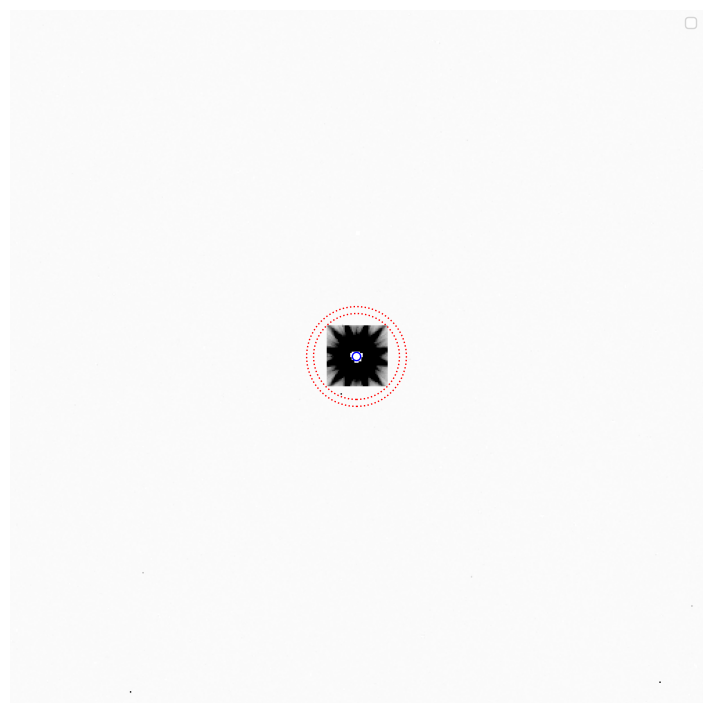

/tmp/ipykernel_895/3267117163.py:148: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [23]:
import csv
from astropy.table import vstack

# Set constants
mag = MAG
sat = '_unsat'  # make '' if want to use images with saturation
CATALOG_FILE_NAME = f'star{mag}.ecsv'
pics = list(range(1, 16))
df = pd.DataFrame()

all_phot_tables = []

# Load catalog once (assuming it's the same for all images)
cat = get_catalog(CATALOG_FILE_NAME)

# Process each image
for pic in pics:
    print(f"\n{'='*50}")
    print(f"Processing image {pic} of {len(pics)}")
    print(f"{'='*50}")
    
    # Construct file name for current image
    file_name = f'./L2_simulation_files/roman_sim_F146_WFI01_L2_32{sat}.asdf'
    print(f"Loading: {file_name}")
    
    try:
        # Load the image file and find information
        image_model = get_roman_dm_file(file_name)
        image = image_model.data.copy()
        err = image_model.err.copy()
        dq = np.bool(image_model.dq.copy())
        meta = copy.deepcopy(image_model.meta)
        wcs = copy.deepcopy(image_model.meta.wcs)
        
        # Get center coordinates
        ra_center, dec_center = wcs(2044, 2044)  # Try center of image
        print(f"Center: RA={ra_center:.6f}, Dec={dec_center:.6f}")
        
        # Check signal at different locations
        signal_center = image.data[2044, 2044]
        signal_point = image.data[2000, 2000]
        print(f'Center signal: {signal_center}')
        print(f'Star location signal: {signal_point}')
        
        # Check corners of the image
        ny, nx = image.shape  
        corners = [(0, 0), (nx-1, 0), (nx-1, ny-1), (0, ny-1)]
        print("\nCorner coordinates:")
        corner_coords = []
        
        for x, y in corners:
            ra_, dec_ = wcs(x, y)
            signal = image.data[x, y]
            print(f"Corner ({x}, {y}): RA={ra_:.6f}, Dec={dec_:.6f}, Signal={signal}")
            corner_coords.append((ra_, dec_))
        
        # Verify coordinate transformation
        x_pix, y_pix = wcs.invert(ra_center, dec_center)
        print(f"Inverted center coordinates: x={x_pix:.2f}, y={y_pix:.2f}")
        
        # Create coordinate plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot catalog stars
        ax.scatter(cat['ra'], cat['dec'], color='grey', s=3)
        
        # Plot image corners
        corner_ra = [coord[0] for coord in corner_coords]
        corner_dec = [coord[1] for coord in corner_coords]
        ax.scatter(corner_ra, corner_dec, s=50)
        
        
        ax.set_xlabel('RA (degrees)')
        ax.set_ylabel('Dec (degrees)')
        ax.set_title(f'Image {pic} - Catalog Stars and Image Boundaries (Mag {mag})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Create image visualization
        plt.close()  # Close the previous figure
        vmin = np.nanmin(image)
        vmax = np.nanmax(image)
        
        norm = simple_norm(image_model.data, 'log', vmin=0, vmax=100)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.imshow(image_model.data,  norm=LogNorm(vmax=vmax), origin='lower')
        ax.set_xlabel('X Science Axis (pixels)')
        ax.set_ylabel('Y Science Axis (pixels)')
        ax.set_title(f'Roman I-Sim Simulation WFI01 Mag {mag} Star Step {pic}')
        plt.colorbar(sc, ax=ax)
        plt.tight_layout();
       # plt.savefig(f'./L1_simulation_files/Images/Roman I-Sim Simulation WFI01 Mag {mag} Star_{pic}.png')
        plt.show()
        

        # Create zoomed-in image
        plt.close()  # Close the previous figure
        print(f'Signal range for zoom: {vmin}, {vmax}')
        
        # Make new figure zoomed in on 1950 <= X <= 2050 and 1950 <= Y <= 2050:
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.imshow(image_model.data,  norm=LogNorm(vmax=vmax), origin='lower')
        ax.set_xlabel('X Science Axis (pixels)')
        ax.set_ylabel('Y Science Axis (pixels)')
        ax.set_title(f'Roman I-Sim Simulation (Data) WFI{SCA:02d} {sat} Step {pic}')
        ax.set_xlim(1950, 2050)
        ax.set_ylim(1950, 2050)
        plt.colorbar(sc, ax=ax)
        plt.tight_layout();
        plt.savefig(f'./L1_simulation_files/Images/Roman I-Sim Simulation WFI01 Mag {mag} Star Zoom{sat}_{pic}.png')
        plt.show()
        
        # Aperature
        # multiply science data and uncertainty array by the PAM
        image *= pam.data
        err *= pam.data 
        
        # Create apertures at each star location
        rad = 3  # aperture radius in pixels
        
        star_positions = [(x, y) for y, x in zip(stars['y'].data, stars['x'].data)]
        
        star_apertures = CircularAperture(positions=star_positions, r=rad)
        
        # create annulus to calculate background measurement
        star_bkg_apertures = CircularAnnulus(positions=star_positions, r_in=31, r_out=36)
        
        fig, ax = plt.subplots(figsize=(9, 9))
        
        # show the simulated image
        ax.imshow(image, origin='lower', vmin=0, vmax=100, cmap='gray_r')
        
        # plot circles over bright galaxies and stars
        star_apertures.plot(color='b')
        star_bkg_apertures.plot(color='red', ls=':')
        
        # zoom in on 1/16th of the image
        ax.set_xlim(1750, 2250)
        ax.set_ylim(1750, 2250)
        ax.legend()
        plt.axis('off')
        plt.show()
        
        # Add colorbar
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label('Signal (DN/s)', rotation=270, labelpad=15)
        
        plt.tight_layout()
        plt.show()

        # PHOTOMETRY ANALYSIS
        print("\n" + "="*60)
        print(f"PHOTOMETRY ANALYSIS - IMAGE {pic}")
        print("="*60)
        
        # Perform aperture photometry on stars
        print("Calculating star photometry...")
        columns = ('id', 'xcentroid', 'ycentroid', 'sum', 'sum_err')
        star_phot = ApertureStats(image, star_apertures, error=err)
        phot_tab = star_phot.to_table(columns)
        print("First 5 star measurements:")
        print(phot_tab[:5])
        
        # Perform background measurements
        print("\nCalculating background photometry...")
        bkg_columns = ('id', 'xcentroid', 'ycentroid', 'median', 'std')
        sigclip = SigmaClip(sigma=3.0, maxiters=5)
        star_bkg = ApertureStats(image, star_bkg_apertures, sigma_clip=sigclip, 
                               mask=dq, error=err)
        bkg_tab = star_bkg.to_table(bkg_columns)
        print("First 5 background measurements:")
        print(bkg_tab[:5])
        print(f"Star Background Sum Error: {star_bkg.sum_err}")
        
        # Get conversion factors from metadata
        try:
            zpt = meta.photometry.conversion_megajanskys
            pixel_area = meta.photometry.pixel_area
            print(f'Zeropoint = {zpt} (MJy/sr) / (DN/s)')
            print(f'Pixel area = {pixel_area}')
            
            # Calculate background-subtracted flux
            flux_bkgsub = star_phot.sum - (star_bkg.median * star_apertures.area)
            print(f'Background-subtracted flux: {flux_bkgsub}')
            
            # Basic flux conversion
            phot_tab['flux_jy'] = flux_bkgsub * zpt * 1e6 * pixel_area
            print("Basic photometry table:")
            print(phot_tab)
            
            # COMPREHENSIVE ERROR PROPAGATION
            print("\n" + "-"*40)
            print("ERROR PROPAGATION ANALYSIS")
            print("-"*40)
            
            # 1. Error in source measurement
            source_err_mean = phot_tab['sum_err'].data
            source_err_median = phot_tab['sum_err'].data * np.sqrt(np.pi/2)
            
            # 2. Error in background measurement
            bkg_area = star_bkg_apertures.area  # Number of pixels in background aperture
            bkg_mean_err = star_bkg.sum_err / np.sqrt(bkg_area)
            bkg_median_err = bkg_mean_err * np.sqrt(np.pi/2)
            
            # 3. Error in total background flux (background per pixel × aperture area)
            bkg_total_err = bkg_mean_err * star_apertures.area
            
            # 4. Error in background-subtracted flux (quadrature addition)
            flux_bkgsub_err = np.sqrt(source_err_mean**2 + bkg_total_err**2)
            
            # 5. Error in final flux (error propagates through linear conversion)
            conversion_factor = zpt * 1e6 * pixel_area
            flux_jy_err = flux_bkgsub_err * conversion_factor
            
            # Add final flux and error to table
            phot_tab['flux_jy_final'] = flux_bkgsub * conversion_factor
            phot_tab['flux_jy_err'] = flux_jy_err
            
            # Calculate signal-to-noise ratio
            phot_tab['snr'] = phot_tab['flux_jy_final'] / phot_tab['flux_jy_err']
            
            print("Final photometry table with errors:")
            print(phot_tab)
            
            # Print detailed results for first star
            if len(phot_tab) > 0:
                print(f"\nFirst star detailed results:")
                print(f"Flux: {phot_tab['flux_jy_final'][0]:.6e} ± {phot_tab['flux_jy_err'][0]:.6e} Jy")
                print(f"Signal-to-noise ratio: {phot_tab['snr'][0]:.1f}")
                print(f"Background Mean Error: {(bkg_mean_err) * star_apertures.area}")
                print(f"Background Median Error: {bkg_median_err * star_apertures.area}")
                print(f"Source Mean Error: {source_err_mean * star_apertures.area}")
                print(f"Source Median Error: {source_err_median * star_apertures.area}")
            
            # Calculate mean flux if multiple stars
            if len(phot_tab) > 1:
                mean_flux = np.mean(phot_tab['flux_jy_final'])
                error_on_mean = np.sqrt(np.sum(phot_tab['flux_jy_err']**2)) / len(phot_tab)
                print(f"\nMean flux from {len(phot_tab)} stars: {mean_flux:.6e} ± {error_on_mean:.6e} Jy")
            
            # MAGNITUDE CONVERSION WITH ERROR PROPAGATION
            print("\n" + "-"*40)
            print("MAGNITUDE CONVERSION")
            print("-"*40)
            
            # Check for positive flux values (required for magnitude calculation)
            positive_flux_mask = phot_tab['flux_jy_final'] > 0
            
            # Initialize magnitude columns
            phot_tab['magnitude'] = np.nan
            phot_tab['magnitude_err'] = np.nan
            
            # Calculate magnitudes only for positive flux values
            if np.any(positive_flux_mask):
                # AB magnitude zeropoint for flux in Janskys
                ab_zeropoint = 8.90
                
                # Convert flux to magnitude
                flux_positive = phot_tab['flux_jy_final'][positive_flux_mask]
                phot_tab['magnitude'][positive_flux_mask] = -2.5 * np.log10(flux_positive) + ab_zeropoint
                
                # Error propagation for magnitude
                # For m = -2.5 * log10(f) + C, σ_m = (2.5/ln(10)) * (σ_f/f) = 1.0857 * (σ_f/f)
                flux_err_positive = phot_tab['flux_jy_err'][positive_flux_mask]
                relative_flux_err = flux_err_positive / flux_positive
                phot_tab['magnitude_err'][positive_flux_mask] = 1.0857 * relative_flux_err
            
            # Print magnitude results
            print("Magnitude conversion results:")
            print("="*50)
            for i in range(min(len(phot_tab), 10)):  # Limit to first 10 stars
                if positive_flux_mask[i]:
                    print(f"Star {i+1}:")
                    print(f"  Flux: {phot_tab['flux_jy_final'][i]:.6e} ± {phot_tab['flux_jy_err'][i]:.6e} Jy")
                    print(f"  Magnitude: {phot_tab['magnitude'][i]:.3f} ± {phot_tab['magnitude_err'][i]:.3f} mag")
                    print(f"  SNR: {phot_tab['snr'][i]:.1f}")
                else:
                    print(f"Star {i+1}: Negative flux - cannot calculate magnitude")
                print()
            
            if len(phot_tab) > 10:
                print(f"... and {len(phot_tab) - 10} more stars")
            
            # Display the complete summary table
            print("Complete photometry summary:")
            summary_columns = ['id', 'flux_jy_final', 'flux_jy_err', 'magnitude', 'magnitude_err', 'snr']
            available_columns = [col for col in summary_columns if col in phot_tab.colnames]
            print(phot_tab[available_columns])
            
            # ADD IMAGE ID COLUMN AND PREPARE FOR COMBINING
            phot_tab['image_id'] = pic  # Add image identifier
            
            # Store this image's photometry table for later combination
            all_phot_tables.append(phot_tab.copy())
            print(f"Stored photometry data for image {pic} ({len(phot_tab)} stars)")
            
        except AttributeError as e:
            print(f"Could not access photometry metadata: {e}")
            print("Skipping flux conversion and magnitude calculation")
        except Exception as e:
            print(f"Error in photometry analysis: {e}")

        # Print summary statistics for this image
        print(f"\nImage {pic} Summary:")
        print(f"  Image shape: {image.shape}")
        print(f"  Signal range: {vmin:.3f} to {vmax:.3f} DN/s")
        print(f"  Center signal: {signal_center:.3f} DN/s")
        print(f"  Mean signal: {np.nanmean(image):.3f} DN/s")
        print(f"  Median signal: {np.nanmedian(image):.3f} DN/s")
        print(f"  Std deviation: {np.nanstd(image):.3f} DN/s")
        
    except Exception as e:
        print(f"Error processing image {pic}: {str(e)}")
        continue

print(f"\n{'='*50}")
print("Processing complete!")
print(f"Processed {len(pics)} images with magnitude {mag} stars")
print(f"{'='*50}")

# COMBINE ALL PHOTOMETRY DATA INTO ONE CSV FILE
if len(all_phot_tables) > 0:
    print(f"\n{'='*60}")
    print("COMBINING PHOTOMETRY DATA")
    print(f"{'='*60}")
    
    # Combine all photometry tables into one master table
    print("Combining all photometry tables...")
    master_phot_table = vstack(all_phot_tables)
    
    # Reorder columns for better organization
    column_order = ['image_id', 'id', 'xcentroid', 'ycentroid', 'sum', 'sum_err', 
                   'flux_jy', 'flux_jy_final', 'flux_jy_err', 'magnitude', 'magnitude_err', 'snr']
    
    # Only include columns that actually exist
    available_columns = [col for col in column_order if col in master_phot_table.colnames]
    remaining_columns = [col for col in master_phot_table.colnames if col not in available_columns]
    final_columns = available_columns + remaining_columns
    
    master_phot_table = master_phot_table[final_columns]
    
    # Save the combined photometry table
    combined_csv_path = f'./roman_persistence_analysis/Photometry_Mag_{mag}.csv'
    master_phot_table.write(combined_csv_path, format='csv', overwrite=True)
    
    print(f"SUCCESS: Combined photometry saved to '{combined_csv_path}'")
    print(f"Total measurements: {len(master_phot_table)}")
    print(f"From {len(all_phot_tables)} images")  
    print(f"Columns: {len(master_phot_table.colnames)}")
    
    # Show preview of the combined data
    print(f"\n Preview of combined photometry table:")
    print("="*80)
    preview_columns = ['image_id', 'id', 'flux_jy_final', 'flux_jy_err', 'magnitude', 'magnitude_err', 'snr']
    available_preview = [col for col in preview_columns if col in master_phot_table.colnames]
    print(master_phot_table[available_preview][:10])  # Show first 10 rows
    if len(master_phot_table) > 10:
        print(f"... and {len(master_phot_table) - 10} more rows")
    
    # Show summary statistics
    print(f"\n Summary by image:")
    for pic in pics:
        image_data = master_phot_table[master_phot_table['image_id'] == pic]
        if len(image_data) > 0:
            mean_snr = np.nanmean(image_data['snr']) if 'snr' in image_data.colnames else 'N/A'
            median_mag = np.nanmedian(image_data['magnitude']) if 'magnitude' in image_data.colnames else 'N/A'
            print(f"   Image {pic}: {len(image_data)} stars, Mean SNR: {mean_snr:.1f}, Median Mag: {median_mag:.2f}")
    
else:
    print("No photometry data was successfully processed!")
    print("Check that 'stars', 'pam', and metadata are properly defined.")

print(f"\n{'='*50}")
print("ANALYSIS COMPLETE!")
print(f"{'='*50}")

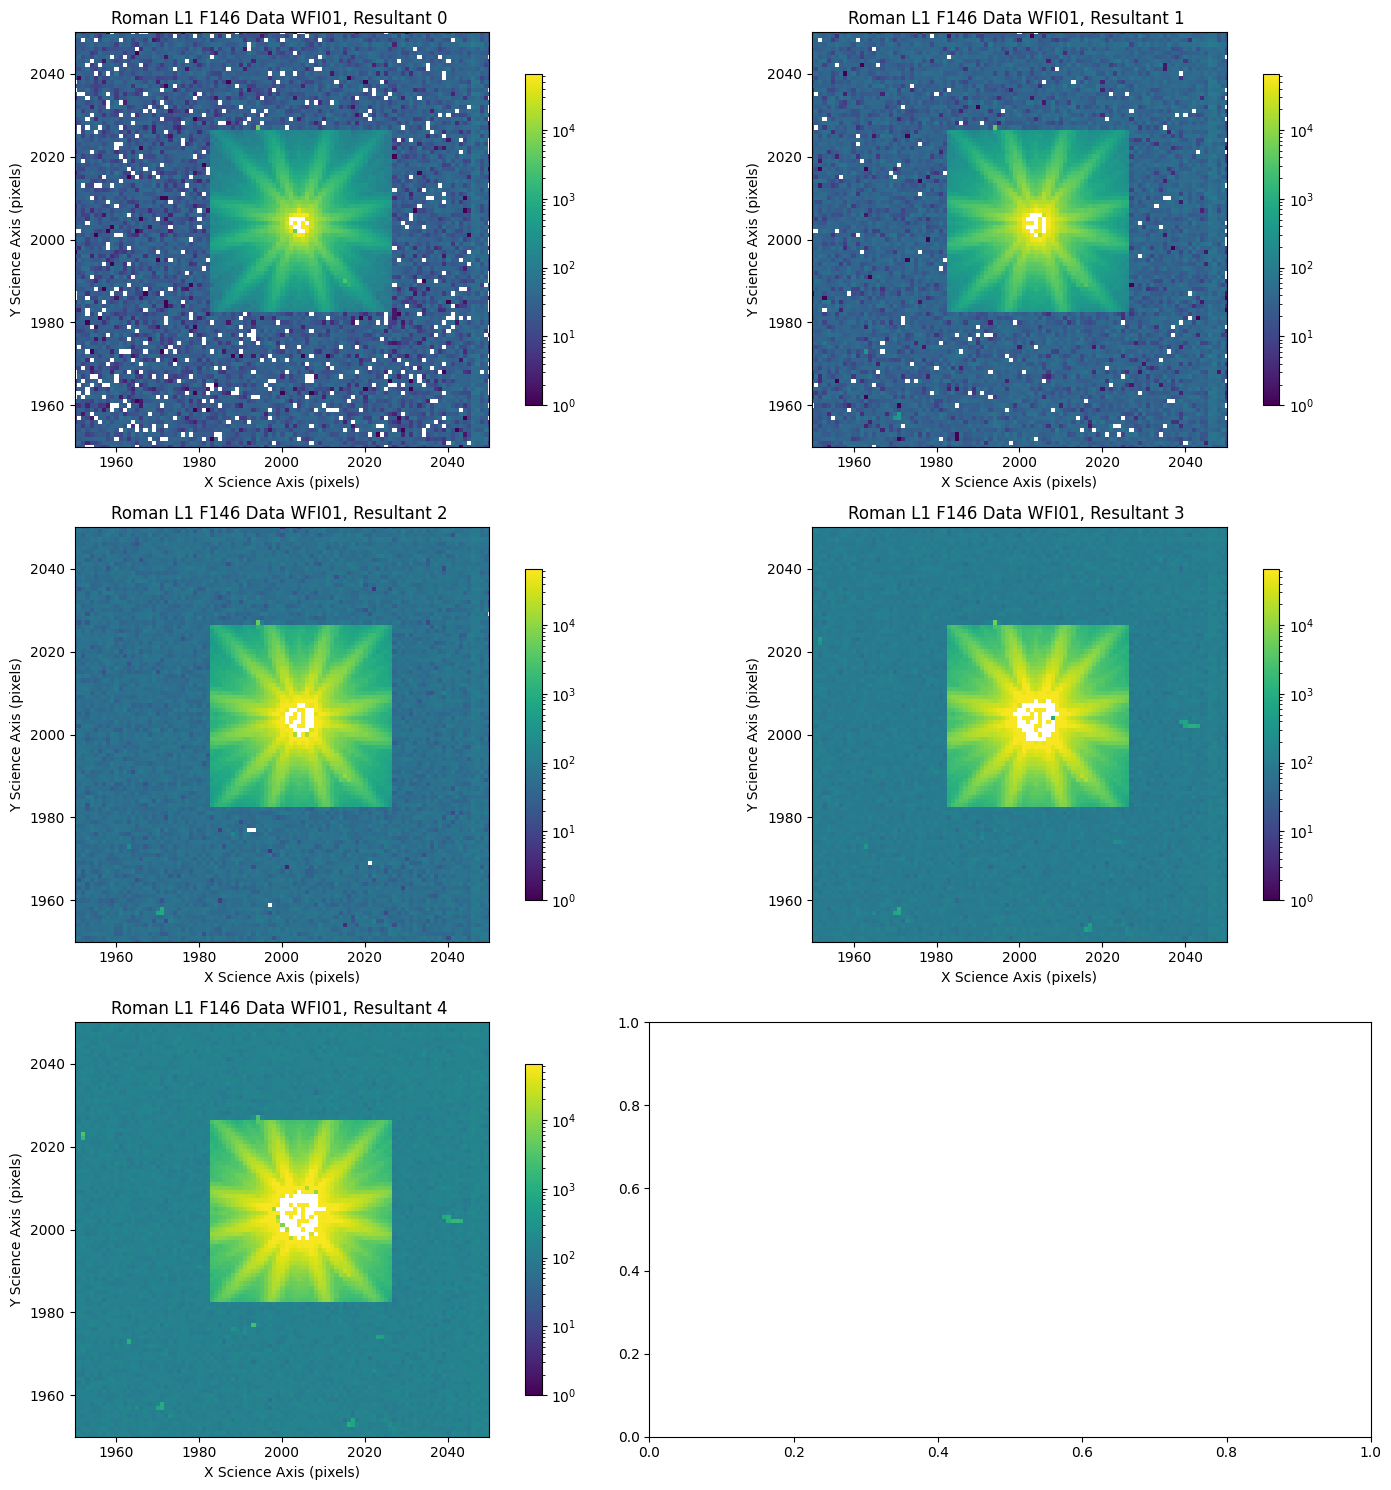

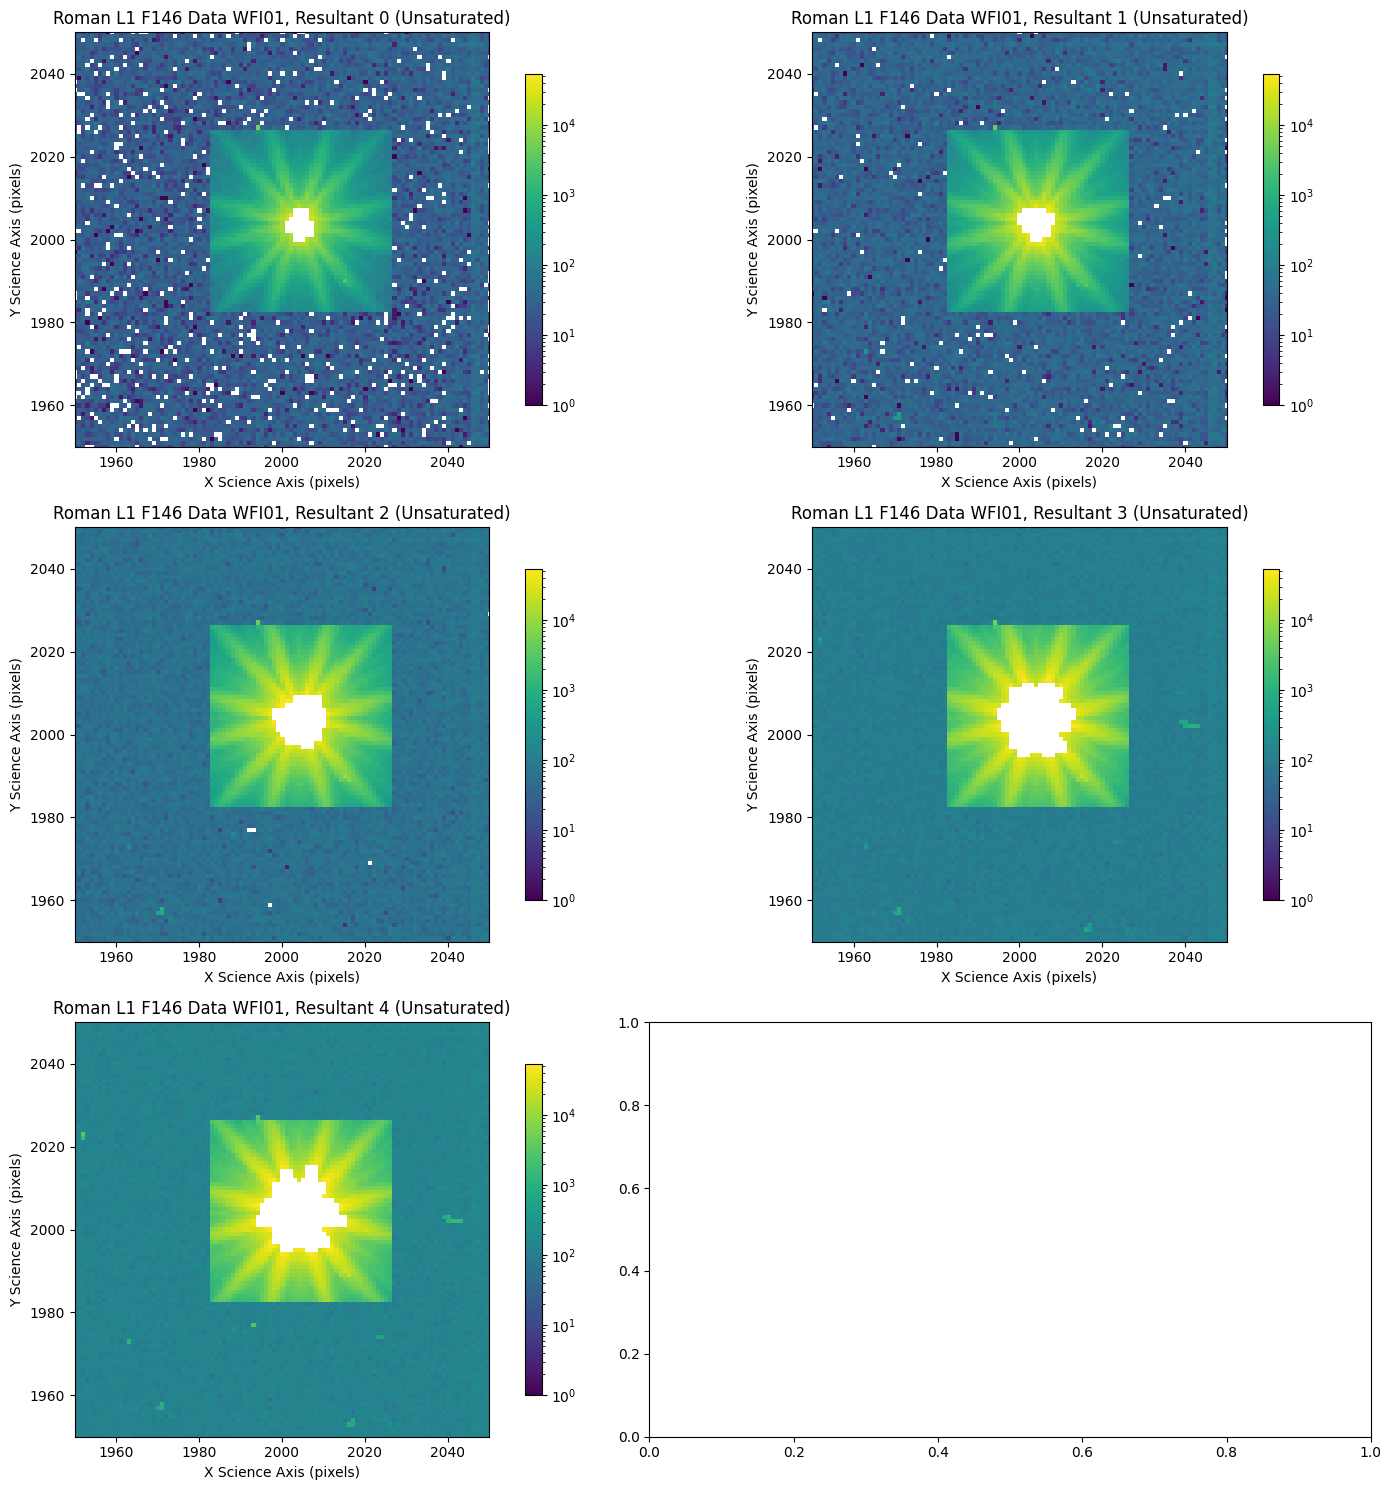

In [24]:
from matplotlib.colors import LogNorm
import pysiaf
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

import matplotlib
matplotlib.set_loglevel("WARNING")


# Make new figure zoomed in on 1750 <= X <= 2250 and 500 <= Y <= 1000:

# list_of_files = get_list_of_asdf_files(SIM_OUTPUT_DIRECTORY) 
list_of_files = get_list_of_asdf_files("./L1_simulation_files") 
for l1 in list_of_files:
    plt.close()
    sat = ''
    file_name = str(l1)
    if 'unsat' in file_name: 
        sat = '(Unsaturated)'

    image_model = get_roman_dm_file(file_name)
    image = image_model.data.copy()
    meta = copy.deepcopy(image_model.meta)

    vmin = np.nanmin(image)
    vmax = np.nanmax(image)
    
    wfi = meta.instrument.detector
    filter = meta.instrument.optical_element

    # Create a 3x3 subplot figure
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Loop through all 9 datasets
    for i in range(image_model.data.shape[0]):
        ax = axes[i]
        
        # Create the image plot for dataset i
        sc = ax.imshow(image_model.data[i, :], norm=LogNorm(vmax=vmax), origin='lower')
        
        # Set labels and title
        ax.set_xlabel('X Science Axis (pixels)')
        ax.set_ylabel('Y Science Axis (pixels)')
        ax.set_title(f'Roman L1 {filter} Data {wfi}, Resultant {i} {sat}')
        
        # Set zoom limits
        ax.set_xlim(1950, 2050)
        ax.set_ylim(1950, 2050)
        
        # Add colorbar for each subplot
        plt.colorbar(sc, ax=ax, shrink=0.8)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the combined plot
    plt.savefig(f'./{OUTPUT_DIRECTORY}/Images/Roman_L1_Data_{wfi}_All_Resultants{pic}{sat}.png', dpi=300, bbox_inches='tight')
    plt.show()

 UNCERTAINTY vs STEPS ANALYSIS

Available plot styles:
1. 'side_by_side' - Two plots side by side on same image
2. 'normalized' - Both uncertainties normalized on single plot
3. 'dual_axis' - Clean dual y-axis plot
4. 'log_ratio' - Comparison and ratio plots
Loading photometry data from ./roman_persistence_analysis/Photometry_Mag_10.csv...
 Loaded 13 measurements from 13 images
 Data overview:
   Images: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]
   Total stars: 13
   Columns: ['image_id', 'id', 'xcentroid', 'ycentroid', 'sum', 'sum_err', 'flux_jy', 'flux_jy_final', 'flux_jy_err', 'magnitude', 'magnitude_err', 'snr']

 Summary statistics by image:
    image_id  n_stars  flux_err_mean  flux_err_std  flux_err_median  \
0          1        1       0.000000           NaN         0.000000   
1          2        1       0.000000           NaN         0.000000   


/tmp/ipykernel_895/335943260.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.errorbar(summary_df['image_id'], summary_df['flux_err_mean'],
/tmp/ipykernel_895/335943260.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bs--" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(summary_df['image_id'], summary_df['flux_err_median'], 'bs--',
/tmp/ipykernel_895/335943260.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.errorbar(summary_df['image_id'], summary_df['mag_err_mean'],
/tmp/ipykernel_895/335943260.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs--" (-> color='r'). The keyword argument will take precedence.
  ax2.plo


 Side-by-side uncertainty plot saved as: ./roman_persistence_analysis/Uncertainty_SideBySide_Mag_10.png


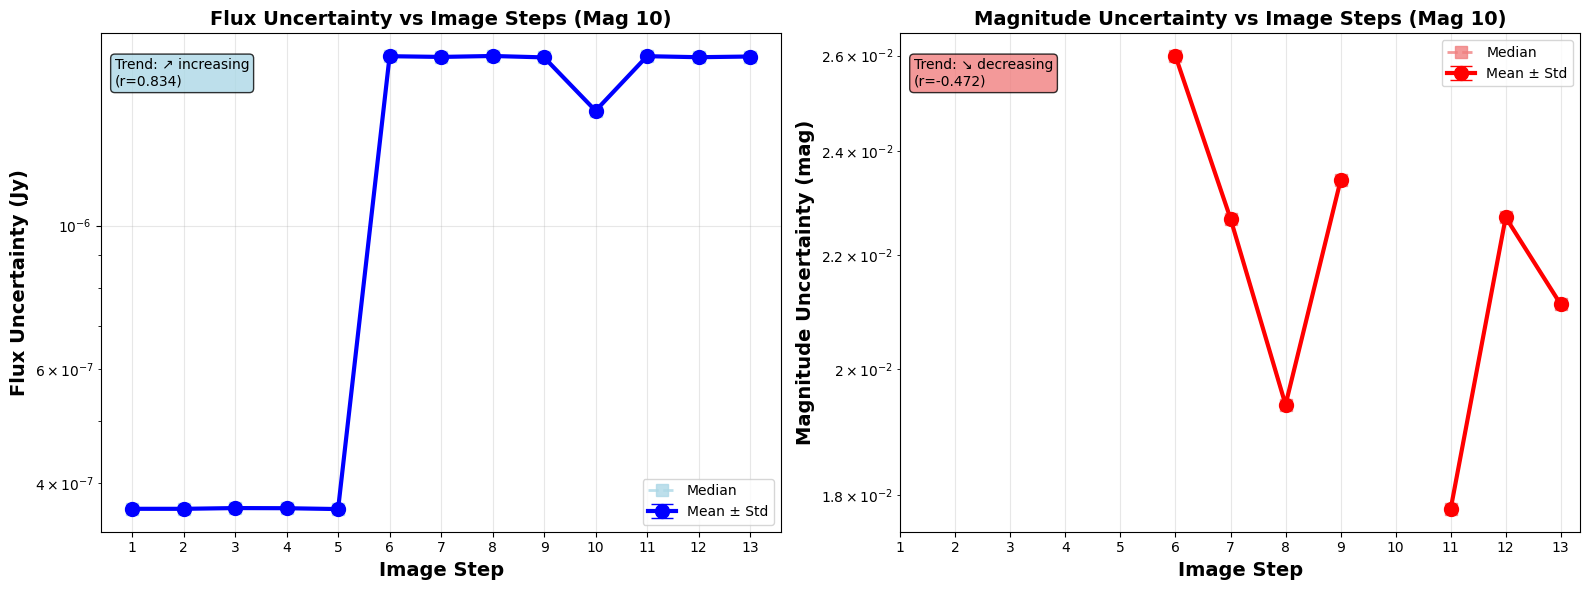


 TREND ANALYSIS:
Flux uncertainty trend:
   Slope: 1.55e-07 Jy/step
   R-correlation: 0.834
   P-value: 0.000
   Overall trend: increasing

Magnitude uncertainty trend:
   Slope: -0.0005 mag/step
   R-correlation: -0.472
   P-value: 0.285
   Overall trend: decreasing

 Summary statistics saved as: ./roman_persistence_analysis/Uncertainty_Summary_by_Steps_Mag_10.csv

 Analysis complete with side_by_side style!

 Quick usage:
   plot_uncertainty_by_steps('Photometry_Mag_10.csv', mag=10, plot_style='side_by_side')
   create_all_plot_styles('Photometry_Mag_10.csv', mag=10)  # Creates all 4 styles

 Available styles: 'side_by_side', 'normalized', 'dual_axis', 'log_ratio'


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

filename = f'./L2_simulation_files/roman_sim_F146_WFI01_L2_32_unsat.asdf'

def plot_uncertainty_by_steps(csv_filename, mag=MAG, plot_style='side_by_side'):
    """
    Plot photometry uncertainties as a function of image steps.
    
    Parameters:
    -----------
    csv_filename : str
        Path to the combined photometry CSV file
    mag : int
        Magnitude value for titles and labels
    plot_style : str
        'side_by_side': Two plots side by side
        'normalized': Both on same plot, normalized 0-1
        'dual_axis': Clean dual y-axis plot (original style)
        'log_ratio': Plot the ratio of uncertainties
    """
    
    print(f"Loading photometry data from {csv_filename}...")
    
    # Read the combined CSV file
    try:
        df = pd.read_csv(csv_filename)
        print(f" Loaded {len(df)} measurements from {len(df['image_id'].unique())} images")
    except FileNotFoundError:
        print(f" Error: Could not find file '{csv_filename}'")
        print("Make sure you've run the photometry analysis first to generate the CSV file.")
        return
    except Exception as e:
        print(f" Error loading CSV: {e}")
        return
    
    # Display data info
    print(f" Data overview:")
    print(f"   Images: {sorted(df['image_id'].unique())}")
    print(f"   Total stars: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    
    # Calculate summary statistics per image
    summary_stats = []
    
    for image_id in sorted(df['image_id'].unique()):
        img_data = df[df['image_id'] == image_id]
        
        # Remove NaN values for calculations
        flux_err = img_data['flux_jy_err'].dropna()
        mag_err = img_data['magnitude_err'].dropna()
        snr_data = img_data['snr'].dropna()
        
        stats_dict = {
            'image_id': image_id,
            'n_stars': len(img_data),
            'flux_err_mean': flux_err.mean() if len(flux_err) > 0 else np.nan,
            'flux_err_std': flux_err.std() if len(flux_err) > 0 else np.nan,
            'flux_err_median': flux_err.median() if len(flux_err) > 0 else np.nan,
            'mag_err_mean': mag_err.mean() if len(mag_err) > 0 else np.nan,
            'mag_err_std': mag_err.std() if len(mag_err) > 0 else np.nan,
            'mag_err_median': mag_err.median() if len(mag_err) > 0 else np.nan,
            'snr_mean': snr_data.mean() if len(snr_data) > 0 else np.nan,
            'snr_std': snr_data.std() if len(snr_data) > 0 else np.nan,
            'snr_median': snr_data.median() if len(snr_data) > 0 else np.nan
        }
        summary_stats.append(stats_dict)
    
    summary_df = pd.DataFrame(summary_stats)
    print(f"\n Summary statistics by image:")
    print(summary_df.round(6))
    
    # Choose plotting style
    if plot_style == 'side_by_side':
        create_side_by_side_plot(summary_df, df, mag)
    elif plot_style == 'normalized':
        create_normalized_plot(summary_df, df, mag)
    elif plot_style == 'dual_axis':
        create_dual_axis_plot(summary_df, df, mag)
    elif plot_style == 'log_ratio':
        create_ratio_plot(summary_df, df, mag)
    else:
        print(f"Unknown plot style: {plot_style}")
        print("Available styles: 'side_by_side', 'normalized', 'dual_axis', 'log_ratio'")
        return
    
    # Trend analysis (same for all styles)
    print_trend_analysis(summary_df)
    
    # Save summary statistics
    summary_filename = f'./roman_persistence_analysis/Uncertainty_Summary_by_Steps_Mag_{mag}.csv'
    summary_df.to_csv(summary_filename, index=False)
    print(f"\n Summary statistics saved as: {summary_filename}")
    
    return summary_df

def create_side_by_side_plot(summary_df, df, mag):
    """Create side-by-side subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Flux Uncertainty
    ax1.errorbar(summary_df['image_id'], summary_df['flux_err_mean'], 
                yerr=summary_df['flux_err_std'], fmt='bo-', markersize=10, 
                linewidth=3, capsize=8, label='Mean ± Std', color='blue')
    ax1.plot(summary_df['image_id'], summary_df['flux_err_median'], 'bs--', 
             markersize=8, linewidth=2, alpha=0.8, color='lightblue', label='Median')
    
    ax1.set_xlabel('Image Step', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Flux Uncertainty (Jy)', fontsize=14, fontweight='bold')
    ax1.set_title(f'Flux Uncertainty vs Image Steps (Mag {mag})', 
                  fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xticks(sorted(df['image_id'].unique()))
    
    # Right plot: Magnitude Uncertainty
    ax2.errorbar(summary_df['image_id'], summary_df['mag_err_mean'], 
                yerr=summary_df['mag_err_std'], fmt='ro-', markersize=10, 
                linewidth=3, capsize=8, label='Mean ± Std', color='red')
    ax2.plot(summary_df['image_id'], summary_df['mag_err_median'], 'rs--', 
             markersize=8, linewidth=2, alpha=0.8, color='lightcoral', label='Median')
    
    ax2.set_xlabel('Image Step', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Magnitude Uncertainty (mag)', fontsize=14, fontweight='bold')
    ax2.set_title(f'Magnitude Uncertainty vs Image Steps (Mag {mag})', 
                  fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xticks(sorted(df['image_id'].unique()))
    
    add_trend_annotations_separate(summary_df, ax1, ax2)
    
    plt.tight_layout()
    plot_filename = f'./roman_persistence_analysis/Uncertainty_SideBySide_Mag_{mag}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\n Side-by-side uncertainty plot saved as: {plot_filename}")
    plt.show()

def create_normalized_plot(summary_df, df, mag):
    """Create single plot with normalized uncertainties"""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Normalize both series to 0-1 range for comparison
    flux_vals = summary_df['flux_err_mean'].dropna()
    mag_vals = summary_df['mag_err_mean'].dropna()
    
    if len(flux_vals) > 1:
        flux_norm = (summary_df['flux_err_mean'] - flux_vals.min()) / (flux_vals.max() - flux_vals.min())
    else:
        flux_norm = summary_df['flux_err_mean']
        
    if len(mag_vals) > 1:
        mag_norm = (summary_df['mag_err_mean'] - mag_vals.min()) / (mag_vals.max() - mag_vals.min())
    else:
        mag_norm = summary_df['mag_err_mean']
    
    # Plot both normalized series
    ax.plot(summary_df['image_id'], flux_norm, 'bo-', markersize=10, 
            linewidth=3, label='Flux Uncertainty (normalized)', color='blue')
    ax.plot(summary_df['image_id'], mag_norm, 'ro-', markersize=10, 
            linewidth=3, label='Magnitude Uncertainty (normalized)', color='red')
    
    # Add original scale annotations
    ax.text(0.02, 0.95, f'Flux range: {flux_vals.min():.2e} - {flux_vals.max():.2e} Jy', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    ax.text(0.02, 0.85, f'Mag range: {mag_vals.min():.4f} - {mag_vals.max():.4f} mag', 
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    ax.set_xlabel('Image Step', fontsize=14, fontweight='bold')
    ax.set_ylabel('Normalized Uncertainty (0-1)', fontsize=14, fontweight='bold')
    ax.set_title(f'Normalized Uncertainties vs Image Steps (Mag {mag})', 
                 fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_xticks(sorted(df['image_id'].unique()))
    ax.set_ylim(-0.1, 1.1)
    
    plt.tight_layout()
    plot_filename = f'Uncertainty_Normalized_Mag_{mag}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\n Normalized uncertainty plot saved as: {plot_filename}")
    plt.show()

def create_dual_axis_plot(summary_df, df, mag):
    """Create clean dual y-axis plot (improved version of original)"""
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx()
    
    # Plot flux uncertainty on left y-axis (blue)
    line1 = ax1.errorbar(summary_df['image_id'], summary_df['flux_err_mean'], 
                        yerr=summary_df['flux_err_std'], fmt='bo-', markersize=10, 
                        linewidth=3, capsize=8, color='blue', alpha=0.8)
    
    # Plot magnitude uncertainty on right y-axis (red)
    line2 = ax2.errorbar(summary_df['image_id'], summary_df['mag_err_mean'], 
                         yerr=summary_df['mag_err_std'], fmt='ro-', markersize=10, 
                         linewidth=3, capsize=8, color='red', alpha=0.8)
    
    # Formatting
    ax1.set_xlabel('Image Step', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Flux Uncertainty (Jy)', color='blue', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Magnitude Uncertainty (mag)', color='red', fontsize=14, fontweight='bold')
    ax1.set_title(f'Flux & Magnitude Uncertainties vs Image Steps (Mag {mag})', 
                  fontsize=16, fontweight='bold')
    
    # Set log scale
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
    # Styling
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_xticks(sorted(df['image_id'].unique()))
    
    # Simple legend
    ax1.text(0.02, 0.95, '● Flux Uncertainty', transform=ax1.transAxes, 
             fontsize=12, color='blue', weight='bold')
    ax1.text(0.02, 0.90, '● Magnitude Uncertainty', transform=ax1.transAxes, 
             fontsize=12, color='red', weight='bold')
    
    plt.tight_layout()
    plot_filename = f'Uncertainty_DualAxis_Mag_{mag}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\n Dual-axis uncertainty plot saved as: {plot_filename}")
    plt.show()

def create_ratio_plot(summary_df, df, mag):
    """Create plot showing the ratio of flux to magnitude uncertainties"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top plot: Both uncertainties on log scale
    ax1.semilogy(summary_df['image_id'], summary_df['flux_err_mean'], 
                 'bo-', markersize=8, linewidth=2, label='Flux Uncertainty (Jy)', color='blue')
    ax1.semilogy(summary_df['image_id'], summary_df['mag_err_mean'] * 1e-6,  # Scale for visibility
                 'ro-', markersize=8, linewidth=2, label='Mag Uncertainty (×1e-6 mag)', color='red')
    
    ax1.set_ylabel('Uncertainty (log scale)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Uncertainties Comparison (Mag {mag})', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xticks(sorted(df['image_id'].unique()))
    
    # Bottom plot: Ratio of uncertainties
    # Calculate ratio (normalize first to avoid scale issues)
    flux_norm = summary_df['flux_err_mean'] / summary_df['flux_err_mean'].max()
    mag_norm = summary_df['mag_err_mean'] / summary_df['mag_err_mean'].max()
    ratio = flux_norm / mag_norm
    
    ax2.plot(summary_df['image_id'], ratio, 'go-', markersize=10, 
             linewidth=3, label='Flux/Mag Uncertainty Ratio (normalized)', color='green')
    ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Ratio = 1')
    
    ax2.set_xlabel('Image Step', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Uncertainty Ratio', fontsize=12, fontweight='bold')
    ax2.set_title('Relative Uncertainty Trends', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xticks(sorted(df['image_id'].unique()))
    
    plt.tight_layout()
    plot_filename = f'./roman_persistence_analysis/Uncertainty_Ratio_Mag_{mag}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\n Ratio uncertainty plot saved as: {plot_filename}")
    plt.show()

def add_trend_annotations_separate(summary_df, ax1, ax2):
    """Add trend annotations to separate plots"""
    if len(summary_df) > 1:
        # Flux trend
        y_flux = summary_df['flux_err_mean'].dropna().values
        x_flux = summary_df.loc[summary_df['flux_err_mean'].notna(), 'image_id'].values
        if len(x_flux) > 1:
            slope_flux, _, r_flux, p_flux, _ = stats.linregress(x_flux, y_flux)
            trend_flux = "↗ increasing" if slope_flux > 0 else "↘ decreasing"
            
            ax1.text(0.02, 0.95, f'Trend: {trend_flux}\n(r={r_flux:.3f})', 
                    transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
        
        # Magnitude trend
        y_mag = summary_df['mag_err_mean'].dropna().values
        x_mag = summary_df.loc[summary_df['mag_err_mean'].notna(), 'image_id'].values
        if len(x_mag) > 1:
            slope_mag, _, r_mag, p_mag, _ = stats.linregress(x_mag, y_mag)
            trend_mag = "↗ increasing" if slope_mag > 0 else "↘ decreasing"
            
            ax2.text(0.02, 0.95, f'Trend: {trend_mag}\n(r={r_mag:.3f})', 
                    transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8))

def print_trend_analysis(summary_df):
    """Print detailed trend analysis"""
    print(f"\n TREND ANALYSIS:")
    print("=" * 50)
    
    # Flux uncertainty trend
    y_flux = summary_df['flux_err_mean'].dropna().values
    x_flux = summary_df.loc[summary_df['flux_err_mean'].notna(), 'image_id'].values
    if len(x_flux) > 1:
        slope_flux, intercept_flux, r_flux, p_flux, _ = stats.linregress(x_flux, y_flux)
        print(f"Flux uncertainty trend:")
        print(f"   Slope: {slope_flux:.2e} Jy/step")
        print(f"   R-correlation: {r_flux:.3f}")
        print(f"   P-value: {p_flux:.3f}")
        trend_flux = "increasing" if slope_flux > 0 else "decreasing"
        print(f"   Overall trend: {trend_flux}")
    
    # Magnitude uncertainty trend
    y_mag = summary_df['mag_err_mean'].dropna().values
    x_mag = summary_df.loc[summary_df['mag_err_mean'].notna(), 'image_id'].values
    if len(x_mag) > 1:
        slope_mag, intercept_mag, r_mag, p_mag, _ = stats.linregress(x_mag, y_mag)
        print(f"\nMagnitude uncertainty trend:")
        print(f"   Slope: {slope_mag:.4f} mag/step")
        print(f"   R-correlation: {r_mag:.3f}")
        print(f"   P-value: {p_mag:.3f}")
        trend_mag = "increasing" if slope_mag > 0 else "decreasing"
        print(f"   Overall trend: {trend_mag}")

# Example usage with different plot styles
if __name__ == "__main__":
    print(" UNCERTAINTY vs STEPS ANALYSIS")
    print("=" * 50)
    
    # Set your parameters
    mag = MAG  # Change this to match your analysis
    csv_file = f'./roman_persistence_analysis/Photometry_Mag_{mag}.csv'  # The combined CSV file
    
    # Try different plot styles:
    print("\nAvailable plot styles:")
    print("1. 'side_by_side' - Two plots side by side on same image")
    print("2. 'normalized' - Both uncertainties normalized on single plot") 
    print("3. 'dual_axis' - Clean dual y-axis plot")
    print("4. 'log_ratio' - Comparison and ratio plots")
    
    # Create the plots with your preferred style
    plot_style = 'side_by_side'  # Change this to your preference
    
    try:
        summary_data = plot_uncertainty_by_steps(csv_file, mag=mag, plot_style=plot_style)
        print(f"\n Analysis complete with {plot_style} style!")
        
    except Exception as e:
        print(f" Error during analysis: {e}")

# Quick function for all styles at once
def create_all_plot_styles(csv_filename, mag=MAG):
    """Create all plot styles for comparison"""
    styles = ['side_by_side', 'normalized', 'dual_axis', 'log_ratio']
    
    for style in styles:
        print(f"\nCreating {style} plot...")
        plot_uncertainty_by_steps(csv_filename, mag=mag, plot_style=style)

print(f"\n Quick usage:")
print(f"   plot_uncertainty_by_steps('Photometry_Mag_{MAG}.csv', mag={MAG}, plot_style='side_by_side')")
print(f"   create_all_plot_styles('Photometry_Mag_{MAG}.csv', mag={MAG})  # Creates all 4 styles")
print(f"\n Available styles: 'side_by_side', 'normalized', 'dual_axis', 'log_ratio'")